In [200]:
#importing packaging
import pandas as pd 
import numpy as np
import json 

# formatting datime 
from datetime import datetime
from datetime import date
from datetime import timedelta

# preprocessing
import re
import preprocessor as p
from nltk.stem import WordNetLemmatizer

# visualising the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter

# topic modelling
import gensim
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
from tomotopy.utils import Corpus
from tomotopy import DTModel

# making the plot
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import itertools

# NLP tools
import spacy
import re  # For preprocessing
from time import time  # To time our operations

# sentiments analyses 
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import multiprocessing
from gensim.models import Word2Vec

# maps
import geopandas
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *
from bokeh.io import output_file, show
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Paragraph
from bokeh.models import Model
from bokeh.models import PreText
from bokeh.io import output_file, show
from bokeh.plotting import figure, output_file, show
from bokeh.models import Panel, Tabs
import numpy as np
import math
 

# others
import random
random.seed(123)
from time import time 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/celinejiang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load the dataset

In [201]:
# uploading the datasets
tweets = pd.read_csv("CombinedTweets.csv")
tweets = tweets.drop('Unnamed: 0', 1)
tweets

<ipython-input-201-fcaef7e17d00>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tweets = tweets.drop('Unnamed: 0', 1)


id         username       user_location  \
0      1536393070501060608           jh1791      South of North   
1      1536344751426875392         alextomo      United Kingdom   
2      1536129427947589633  PaulHig55170875     London, England   
3      1536068863288303621           Tidos6           Liverpool   
4      1536060723452858370        Petchelli  Heywood lancashire   
...                    ...              ...                 ...   
17962   947820855932923904     mcguffiejake                 NaN   
17963   947715089389555712  ShaunPMacmillan           Edinburgh   
17964   947655633301655553           L66six                 NaN   
17965   947629853326630912       ThePollitt             Bristol   
17966   947624679002423296            ttsls    Suffolk, England   

                            date  replyCount  retweetCount  likeCount  \
0      2022-06-13 17:00:27+00:00           0             0          2   
1      2022-06-13 13:48:27+00:00           5            14         35   
2      2022-06-12 23:32:50+00:00           0             0          0   
3      2022-06-12 19:32:10+00:00           1             0          0   
4      2022-06-12 18:59:49+00:00           1             0          6   
...                          ...         ...           ...        ...   
17962  2018-01-01 13:24:36+00:00           0             2         62   
17963  2018-01-01 06:24:19+00:00           0             0          1   
17964  2018-01-01 02:28:04+00:00           0             0          1   
17965  2018-01-01 00:45:37+00:00           0             1         13   
17966  2018-01-01 00:25:04+00:00           0             0          1   

                                                 content           keywords  
0      @bennystarks @jgb00m Oh, hell yes. \nProtip: d...  material shortage  
1      XR offshoot "Roads Rebellion" today targeting ...        green shift  
2      Fuel crisis: thefts on the rise • is it time t...        green shift  
3      @PaulEll70190027 All cars are expensive .. if ...        green shift  
4      @PamelaHensley22 @journey_ev Yep 100%\nFuel co...        green shift  
...                                                  ...                ...  
17962  happy new year only to the person who invented...               fiat  
17963                                   Fiat 500 twitter               fiat  
17964  @tordoff_john #1-@Porsche #speedster,#2-@Lambo...               fiat  
17965  Happy New Year you magnificent swines. \n\nMay...               fiat  
17966  Happy New Year!  Received this earlier from a ...               fiat  

[17967 rows x 9 columns]

In [202]:
# format date (2022-06-13 17:00:27+00:00) to (2022-06-13)
tweets['date'] = pd.to_datetime(tweets['date'], errors='coerce')
tweets['date'] = tweets['date'].dt.strftime('%Y-%m-%d')

In [203]:
# extracting the year out
tweets['date'] = tweets['date'].apply(lambda x: pd.Timestamp(x, tz=None))
tweets.date
tweets['year']=[i.year for i in tweets['date']]
tweets

id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      @bennystarks @jgb00m Oh, hell yes. \nProtip: d...  material shortage   
1      XR offshoot "Roads Rebellion" today targeting ...        green shift   
2      Fuel crisis: thefts on the rise • is it time t...        green shift   
3      @PaulEll70190027 All cars are expensive .. if ...        green shift   
4      @PamelaHensley22 @journey_ev Yep 100%\nFuel co...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   Fiat 500 twitter               fiat   
17964  @tordoff_john #1-@Porsche #speedster,#2-@Lambo...               fiat   
17965  Happy New Year you magnificent swines. \n\nMay...               fiat   
17966  Happy New Year!  Received this earlier from a ...               fiat   

       year  
0      2022  
1      2022  
2      2022  
3      2022  
4      2022  
...     ...  
17962  2018  
17963  2018  
17964  2018  
17965  2018  
17966  2018  

[17967 rows x 10 columns]

# Data Preprocessing

## Data Cleaning

In [204]:
# make the text lower characters
tweets['content'] = tweets['content'].str.lower()

In [205]:
# step 2
#expanding the contractions
#creating the dictionary 
contraction_dict = {"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"they'll": "they will",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"}

# regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contraction_dict.keys()))
def expand_contractions(text,contractions_dict=contraction_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
    
# expanding Contractions in the tweets
tweets['content']=tweets['content'].apply(lambda x:expand_contractions(x))
tweets['content']

0        @bennystarks @jgb00m oh, hell yes. \nprotip: d...
1        xr offshoot "roads rebellion" today targeting ...
2        fuel crisis: thefts on the rise • is it time t...
3        @paulell70190027 all cars are expensive .. if ...
4        @pamelahensley22 @journey_ev yep 100%\nfuel co...
                               ...                        
17962    happy new year only to the person who invented...
17963                                     fiat 500 twitter
17964    @tordoff_john #1-@porsche #speedster,#2-@lambo...
17965    happy new year you magnificent swines. \n\nmay...
17966    happy new year!  received this earlier from a ...
Name: content, Length: 17967, dtype: object

In [206]:
# step 3
# removing hashtags, @'s and url's
import preprocessor as p

# setting opitons to not remove the emojis
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.HASHTAG)

# clean the data 
def preprocess_tweet(tweets):
    text = tweets['content']
    text = p.clean(text)
    return text

#append the preprocess tweet into content 
tweets['content'] = tweets.apply(preprocess_tweet, axis=1)
text = tweets['content']
text

0        oh, hell yes. protip: do not total a 3yr old o...
1        xr offshoot "roads rebellion" today targeting ...
2        fuel crisis: thefts on the rise • is it time t...
3        all cars are expensive .. if replacing switch ...
4        yep 100% fuel costs are rising in the hope it ...
                               ...                        
17962    happy new year only to the person who invented...
17963                                     fiat 500 twitter
17964                            - ,- ,- ,then last of all
17965    happy new year you magnificent swines. may you...
17966    happy new year! received this earlier from a f...
Name: content, Length: 17967, dtype: object

In [207]:
#step 4 - lemmatisation 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
text_1 = list(map(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]),text))

# convert it into the dataframe
lem_1 = pd.DataFrame(text)
lem_1

content
0      oh, hell yes. protip: do not total a 3yr old o...
1      xr offshoot "roads rebellion" today targeting ...
2      fuel crisis: thefts on the rise • is it time t...
3      all cars are expensive .. if replacing switch ...
4      yep 100% fuel costs are rising in the hope it ...
...                                                  ...
17962  happy new year only to the person who invented...
17963                                   fiat 500 twitter
17964                          - ,- ,- ,then last of all
17965  happy new year you magnificent swines. may you...
17966  happy new year! received this earlier from a f...

[17967 rows x 1 columns]

In [208]:
# adding it to the dataframe of tweets
tweets['lemmatised'] = lem_1
tweets

id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise • is it time t...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
1      2022  xr offshoot "roads rebellion" today targeting ...  
2      2022  fuel crisis: thefts on the rise • is it time t...  
3      2022  all cars are expensive .. if replacing switch ...  
4      2022  yep 100% fuel costs are rising in the hope it ...  
...     ...                                                ...  
17962  2018  happy new year only to the person who invented...  
17963  2018                                   fiat 500 twitter  
17964  2018                          - ,- ,- ,then last of all  
17965  2018  happy new year you magnificent swines. may you...  
17966  2018  happy new year! received this earlier from a f...  

[17967 rows x 11 columns]

In [209]:
# setting opitons to not remove the emojis
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.HASHTAG,p.OPT.EMOJI)
tweets_emo = tweets.copy(deep=True)
# clean the data 
def preprocess_tweet(tweets):
    text_2 = tweets['lemmatised']
    text_2 = p.clean(text_2)
    return text_2

#append the preprocess tweet into content 
tweets['lemmatised'] = tweets.apply(preprocess_tweet, axis=1)
text_2 = tweets['lemmatised']
text_2

0        oh, hell yes. protip: do not total a 3yr old o...
1        xr offshoot "roads rebellion" today targeting ...
2        fuel crisis: thefts on the rise is it time to ...
3        all cars are expensive .. if replacing switch ...
4        yep 100% fuel costs are rising in the hope it ...
                               ...                        
17962    happy new year only to the person who invented...
17963                                     fiat 500 twitter
17964                            - ,- ,- ,then last of all
17965    happy new year you magnificent swines. may you...
17966    happy new year! received this earlier from a f...
Name: lemmatised, Length: 17967, dtype: object

In [210]:
#step 4 - lemmatisation 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
text_2 = list(map(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]),text))

# convert it into the dataframe
lem_2 = pd.DataFrame(text)
lem_2

content
0      oh, hell yes. protip: do not total a 3yr old o...
1      xr offshoot "roads rebellion" today targeting ...
2      fuel crisis: thefts on the rise • is it time t...
3      all cars are expensive .. if replacing switch ...
4      yep 100% fuel costs are rising in the hope it ...
...                                                  ...
17962  happy new year only to the person who invented...
17963                                   fiat 500 twitter
17964                          - ,- ,- ,then last of all
17965  happy new year you magnificent swines. may you...
17966  happy new year! received this earlier from a f...

[17967 rows x 1 columns]

In [211]:
# adding it to the dataframe of tweets
tweets_emo['lemmatised'] = lem_2
tweets_emo

id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise • is it time t...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
1      2022  xr offshoot "roads rebellion" today targeting ...  
2      2022  fuel crisis: thefts on the rise • is it time t...  
3      2022  all cars are expensive .. if replacing switch ...  
4      2022  yep 100% fuel costs are rising in the hope it ...  
...     ...                                                ...  
17962  2018  happy new year only to the person who invented...  
17963  2018                                   fiat 500 twitter  
17964  2018                          - ,- ,- ,then last of all  
17965  2018  happy new year you magnificent swines. may you...  
17966  2018  happy new year! received this earlier from a f...  

[17967 rows x 11 columns]

# Data exploratory

### Dividing the keywords by categories

### Substainbilty 
- green shift

In [212]:
# extracting the green shift from the table 
green = tweets[tweets.isin(['green shift']).any(axis=1)]
green

id         username            user_location  \
1      1536344751426875392         alextomo           United Kingdom   
2      1536129427947589633  PaulHig55170875          London, England   
3      1536068863288303621           Tidos6                Liverpool   
4      1536060723452858370        Petchelli       Heywood lancashire   
5      1535965611855052800       bjfletcher            Sheffield, UK   
...                    ...              ...                      ...   
15411  1003960320271048704      eVCentresUK           United Kingdom   
15857   993759113187352576         BrumKong          Birminham #obvs   
16025   989862618348380163     dino5656_180      Chippenham, England   
16202   984836773212803074        sksanglia            East, England   
17877   948843941465554944           BWDDPH  England, United Kingdom   

            date  replyCount  retweetCount  likeCount  \
1     2022-06-13           5            14         35   
2     2022-06-12           0             0          0   
3     2022-06-12           1             0          0   
4     2022-06-12           1             0          6   
5     2022-06-12           1             0          2   
...          ...         ...           ...        ...   
15411 2018-06-05           0             0          0   
15857 2018-05-08           2             0          0   
16025 2018-04-27           0             0          0   
16202 2018-04-13           1             0          1   
17877 2018-01-04           3             7          9   

                                                 content     keywords  year  \
1      xr offshoot "roads rebellion" today targeting ...  green shift  2022   
2      fuel crisis: thefts on the rise • is it time t...  green shift  2022   
3      all cars are expensive .. if replacing switch ...  green shift  2022   
4      yep 100% fuel costs are rising in the hope it ...  green shift  2022   
5      i want to contribute to by switching our car t...  green shift  2022   
...                                                  ...          ...   ...   
15411  switch to electric cars threatens 75,000 germa...  green shift  2018   
15857  aware switch to cycling and public transport i...  green shift  2018   
16025  bosch diesel "breakthrough" great news for aut...  green shift  2018   
16202  they have got to switch to lpg, hydrogen or el...  green shift  2018   
17877  x marks the cross when electric cars will over...  green shift  2018   

                                              lemmatised  
1      xr offshoot "roads rebellion" today targeting ...  
2      fuel crisis: thefts on the rise is it time to ...  
3      all cars are expensive .. if replacing switch ...  
4      yep 100% fuel costs are rising in the hope it ...  
5      i want to contribute to by switching our car t...  
...                                                  ...  
15411  switch to electric cars threatens 75,000 germa...  
15857  aware switch to cycling and public transport i...  
16025  bosch diesel "breakthrough" great news for aut...  
16202  they have got to switch to lpg, hydrogen or el...  
17877  x marks the cross when electric cars will over...  

[249 rows x 11 columns]

In [213]:
# rounding off the years
green["year"].round

<bound method Series.round of 1        2022
2        2022
3        2022
4        2022
5        2022
         ... 
15411    2018
15857    2018
16025    2018
16202    2018
17877    2018
Name: year, Length: 249, dtype: int64>

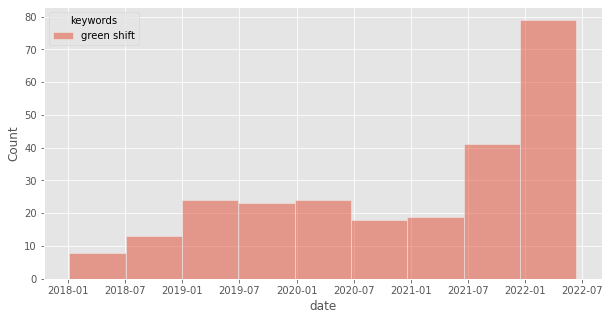

In [214]:
# frequency of comments change across keywords over the timeperiods?
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',data=green[green['year']>=2018]) 
plt.show()

### Supply Chain Disruption 
- waiting time, material shortage, car purchasing

In [215]:
# extracting the keywords from the table
disruption = tweets[tweets.isin(['waiting time','material shortage','car purchasing']).any(axis=1)]
disruption

id        username           user_location       date  \
0      1536393070501060608          jh1791          South of North 2022-06-13   
8      1535896448310689793   PeterLattimer           County Durham 2022-06-12   
12     1535719880850296833     alex_packer        Halifax, England 2022-06-11   
16     1535589553981034496      Orangecroc          United Kingdom 2022-06-11   
22     1535387116447858696     Velocentric       Oxfordshire, UK.  2022-06-10   
...                    ...             ...                     ...        ...   
17554   952546354278133760          DrJagz                  London 2018-01-14   
17571   952143347346493440       evstreets         London, England 2018-01-13   
17734   949972939478372352   oldfarmhorace                Guernsey 2018-01-07   
17849   949047628834263040  mike_catterall  Accrington, Lancashire 2018-01-04   
17850   949038370340179973      livanirina           paris, france 2018-01-04   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
8               0             0          0   
12              1             0          0   
16              1             0          3   
22              0             0          0   
...           ...           ...        ...   
17554           0             1          0   
17571           0             0          0   
17734           0             0          0   
17849           0             0          0   
17850           0             0          0   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
8      perhaps they need the battery capacity either ...  material shortage   
12     the backlog has little to do with batteries an...  material shortage   
16     all used car prices are out of control at the ...  material shortage   
22     it has / it is pretty crazy. my car at 15k mil...  material shortage   
...                                                  ...                ...   
17554  all the more reason to buy an electric car if ...       waiting time   
17571   would you like to buy your new electric car via?       waiting time   
17734  i support the growth initiatives that electric...       waiting time   
17849  easy to spend other people’s money, i’ll drive...       waiting time   
17850  perhaps you can go to madagascar 🇲🇬 and buy ca...       waiting time   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
8      2022  perhaps they need the battery capacity either ...  
12     2022  the backlog has little to do with batteries an...  
16     2022  all used car prices are out of control at the ...  
22     2022  it has / it is pretty crazy. my car at 15k mil...  
...     ...                                                ...  
17554  2018  all the more reason to buy an electric car if ...  
17571  2018   would you like to buy your new electric car via?  
17734  2018  i support the growth initiatives that electric...  
17849  2018  easy to spend other peoples money, ill drive a...  
17850  2018  perhaps you can go to madagascar and buy car o...  

[952 rows x 11 columns]

In [216]:
# rounding off the years
disruption["year"].round

<bound method Series.round of 0        2022
8        2022
12       2022
16       2022
22       2022
         ... 
17554    2018
17571    2018
17734    2018
17849    2018
17850    2018
Name: year, Length: 952, dtype: int64>

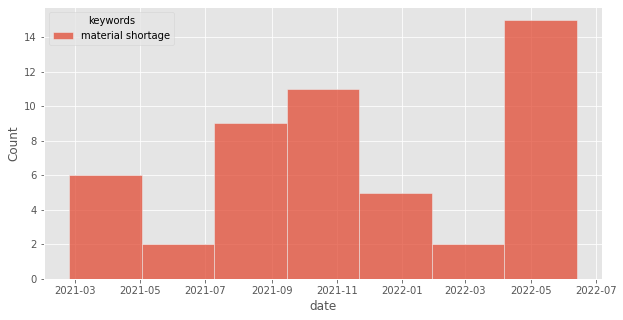

In [217]:
# getting the material shortage only - better understanding for my purpose 
shortage = tweets[tweets.isin(['material shortage']).any(axis=1)]

# frequency of comments change across keywords over the timeperiods?
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',multiple='stack',data=shortage[shortage['year']>=2018]) 
plt.show()

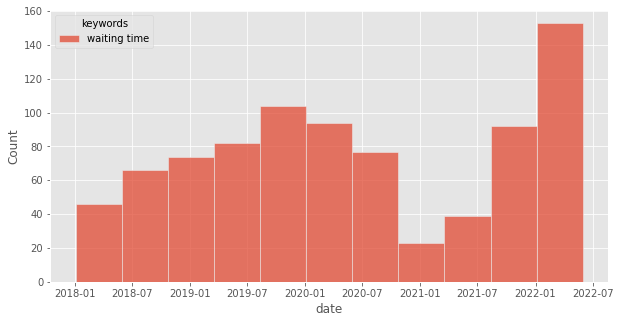

In [218]:
# getting the waiting time only - better understanding for my purpose 
waiting = tweets[tweets.isin(['waiting time']).any(axis=1)]

# frequency of comments change across keywords over the timeperiods?
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',multiple='stack',data=waiting[waiting['year']>=2018]) 
plt.show()

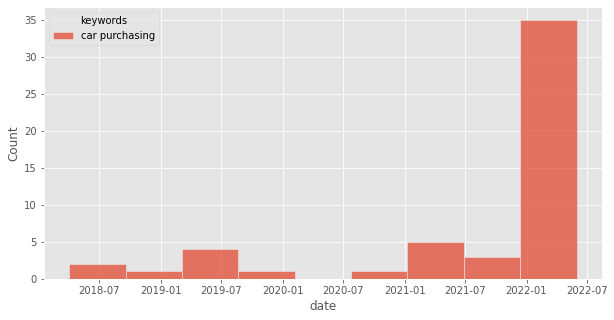

In [219]:
# getting the car purchaing only - better understanding for my purpose 
purchasing = tweets[tweets.isin(['car purchasing']).any(axis=1)]

# frequency of comments change across keywords over the timeperiods?
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',multiple='stack',data=purchasing[purchasing['year']>=2018]) 
plt.show()

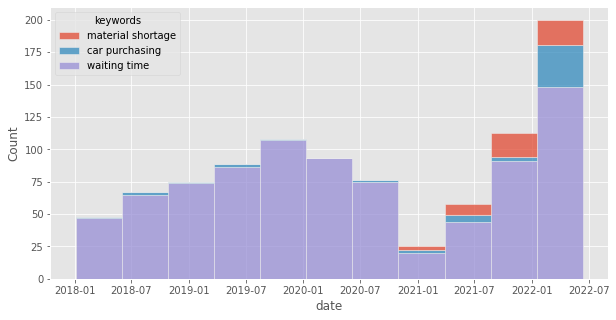

In [220]:
# frequency of comments change across keywords over the timeperiods?
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',multiple='stack',data=disruption[disruption['year']>=2018]) 
plt.show()

### Car brand

In [221]:
brand = tweets[tweets.isin(['fiat']).any(axis=1)]
brand

id         username          user_location       date  \
71     1531771980147576833      MadgeOrrity         United Kingdom 2022-05-31   
72     1531767759683452928   SuriyaSubraman             London, UK 2022-05-31   
73     1531766812253339648      bbc_bitcoin        London, England 2022-05-31   
74     1531766272299606022      markjones41  Wales, United Kingdom 2022-05-31   
75     1531764891593453573    garrethmcdaid       Leitrim, Ireland 2022-05-31   
...                    ...              ...                    ...        ...   
17962   947820855932923904     mcguffiejake                    NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan              Edinburgh 2018-01-01   
17964   947655633301655553           L66six                    NaN 2018-01-01   
17965   947629853326630912       ThePollitt                Bristol 2018-01-01   
17966   947624679002423296            ttsls       Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
71              2             0          2   
72              0             1          1   
73              1             0          0   
74              1             1          5   
75              0             1          7   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content keywords  year  \
71     watch out, eb. before you know it, he shall / ...     fiat  2022   
72     today in fintech: bridging fiat, crypto | : in...     fiat  2022   
73     are you asking me for the use case of hard mon...     fiat  2022   
74     there are 2 things in my life that are certain...     fiat  2022   
75     helicopter money is one of the key milestones ...     fiat  2022   
...                                                  ...      ...   ...   
17962  happy new year only to the person who invented...     fiat  2018   
17963                                   fiat 500 twitter     fiat  2018   
17964                          - ,- ,- ,then last of all     fiat  2018   
17965  happy new year you magnificent swines. may you...     fiat  2018   
17966  happy new year! received this earlier from a f...     fiat  2018   

                                              lemmatised  
71     watch out, eb. before you know it, he shall / ...  
72     today in fintech: bridging fiat, crypto | : in...  
73     are you asking me for the use case of hard mon...  
74     there are 2 things in my life that are certain...  
75     helicopter money is one of the key milestones ...  
...                                                  ...  
17962  happy new year only to the person who invented...  
17963                                   fiat 500 twitter  
17964                          - ,- ,- ,then last of all  
17965  happy new year you magnificent swines. may you...  
17966  happy new year! received this earlier from a f...  

[16766 rows x 11 columns]

In [222]:
# rounding off the years
brand["year"].round

<bound method Series.round of 71       2022
72       2022
73       2022
74       2022
75       2022
         ... 
17962    2018
17963    2018
17964    2018
17965    2018
17966    2018
Name: year, Length: 16766, dtype: int64>

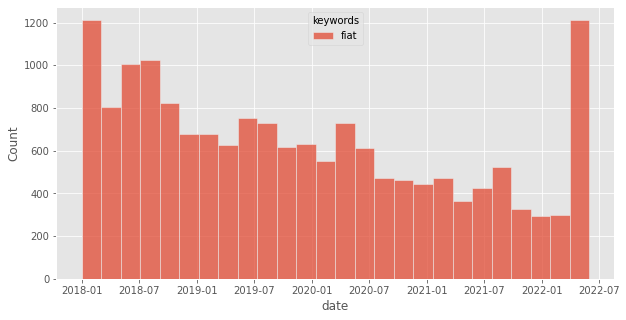

In [223]:
# frequency of comments change across keywords over the timeperiods?
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',multiple='stack',data=brand[brand["year"]>=2018]) 
plt.show()

### Combined keywords excluding fiat

In [224]:
tweets_exclude = tweets[tweets.isin(['green shift','waiting time','car purchasing','material shortage']).any(axis=1)]
tweets_exclude

id         username            user_location  \
0      1536393070501060608           jh1791           South of North   
1      1536344751426875392         alextomo           United Kingdom   
2      1536129427947589633  PaulHig55170875          London, England   
3      1536068863288303621           Tidos6                Liverpool   
4      1536060723452858370        Petchelli       Heywood lancashire   
...                    ...              ...                      ...   
17571   952143347346493440        evstreets          London, England   
17734   949972939478372352    oldfarmhorace                 Guernsey   
17849   949047628834263040   mike_catterall   Accrington, Lancashire   
17850   949038370340179973       livanirina            paris, france   
17877   948843941465554944           BWDDPH  England, United Kingdom   

            date  replyCount  retweetCount  likeCount  \
0     2022-06-13           0             0          2   
1     2022-06-13           5            14         35   
2     2022-06-12           0             0          0   
3     2022-06-12           1             0          0   
4     2022-06-12           1             0          6   
...          ...         ...           ...        ...   
17571 2018-01-13           0             0          0   
17734 2018-01-07           0             0          0   
17849 2018-01-04           0             0          0   
17850 2018-01-04           0             0          0   
17877 2018-01-04           3             7          9   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise • is it time t...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17571   would you like to buy your new electric car via?       waiting time   
17734  i support the growth initiatives that electric...       waiting time   
17849  easy to spend other people’s money, i’ll drive...       waiting time   
17850  perhaps you can go to madagascar 🇲🇬 and buy ca...       waiting time   
17877  x marks the cross when electric cars will over...        green shift   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
1      2022  xr offshoot "roads rebellion" today targeting ...  
2      2022  fuel crisis: thefts on the rise is it time to ...  
3      2022  all cars are expensive .. if replacing switch ...  
4      2022  yep 100% fuel costs are rising in the hope it ...  
...     ...                                                ...  
17571  2018   would you like to buy your new electric car via?  
17734  2018  i support the growth initiatives that electric...  
17849  2018  easy to spend other peoples money, ill drive a...  
17850  2018  perhaps you can go to madagascar and buy car o...  
17877  2018  x marks the cross when electric cars will over...  

[1201 rows x 11 columns]

In [225]:
# rounding of the years
tweets_exclude["year"].round

<bound method Series.round of 0        2022
1        2022
2        2022
3        2022
4        2022
         ... 
17571    2018
17734    2018
17849    2018
17850    2018
17877    2018
Name: year, Length: 1201, dtype: int64>

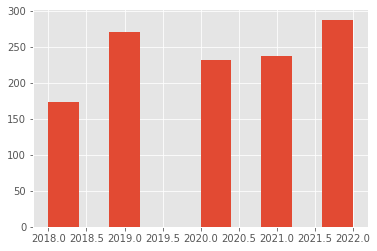

In [226]:
# number of comments across years?
plt.style.use('ggplot')
tweets_exclude.year.hist()
plt.show()

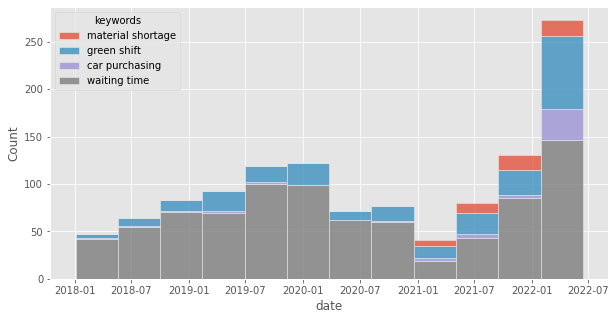

In [227]:
# frequency of comments change across keywords over the timeperiods
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.histplot(x='date', hue='keywords',multiple='stack', data=tweets_exclude[tweets_exclude['year']>=2018]) 
plt.show()

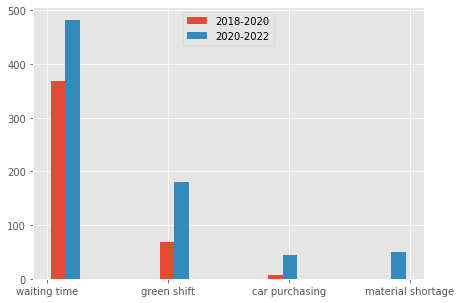

In [228]:
# Number of comments keywords that changed before and after 2018
plt.style.use('ggplot')
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
before = tweets_exclude[(tweets_exclude.year>=2018) & (tweets_exclude.year<2020)]['keywords'].sort_index(ascending=True)
after = tweets_exclude[tweets_exclude.year>=2020]['keywords'].sort_index(ascending=True)
ax.hist([before,after], histtype='bar')
plt.legend(['2018-2020', '2020-2022'], loc='upper center')
plt.show()

### clean again

In [229]:
# step 1
#removal of extra white spaces, punctuation and apply lower casing
tweets['content'] = tweets['content'].str.lower()

In [230]:
# step 2
#expanding the contractions
#creating the dictionary 
contraction_dict = {"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"they'll": "they will",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"}

In [231]:
#step 2
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contraction_dict.keys()))
def expand_contractions(text,contractions_dict=contraction_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the tweets
tweets['content']=tweets['content'].apply(lambda x:expand_contractions(x))
tweets['content']

0        oh, hell yes. protip: do not total a 3yr old o...
1        xr offshoot "roads rebellion" today targeting ...
2        fuel crisis: thefts on the rise • is it time t...
3        all cars are expensive .. if replacing switch ...
4        yep 100% fuel costs are rising in the hope it ...
                               ...                        
17962    happy new year only to the person who invented...
17963                                     fiat 500 twitter
17964                            - ,- ,- ,then last of all
17965    happy new year you magnificent swines. may you...
17966    happy new year! received this earlier from a f...
Name: content, Length: 17967, dtype: object

In [232]:
#step 3 - removing @'s,emojis and urls
# cleaning the text 
def preprocess_tweet(tweets):
    text = tweets['content']
    text = p.clean(text)
    return text
    
#append the preprocess tweet into content 
tweets['content'] = tweets.apply(preprocess_tweet, axis=1)
#extracting the list of text
text = tweets['content']

In [233]:
#step 4 - lemmatisation 
lemmatizer = WordNetLemmatizer()
text = list(map(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]),text))

# convert it into the dataframe
lem = pd.DataFrame(text)
lem

0
0      oh, hell yes. protip: do not total a 3yr old o...
1      xr offshoot "roads rebellion" today target toy...
2      fuel crisis: thefts on the rise be it time to ...
3      all cars be expensive .. if replace switch to ...
4      yep 100% fuel cost be rise in the hope it will...
...                                                  ...
17962  happy new year only to the person who invent t...
17963                                   fiat 500 twitter
17964                          - ,- ,- ,then last of all
17965  happy new year you magnificent swines. may you...
17966  happy new year! receive this earlier from a fr...

[17967 rows x 1 columns]

In [234]:
# adding it to the dataframe of tweets
tweets['lemmatised'] = lem
tweets

id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
1      2022  xr offshoot "roads rebellion" today target toy...  
2      2022  fuel crisis: thefts on the rise be it time to ...  
3      2022  all cars be expensive .. if replace switch to ...  
4      2022  yep 100% fuel cost be rise in the hope it will...  
...     ...                                                ...  
17962  2018  happy new year only to the person who invent t...  
17963  2018                                   fiat 500 twitter  
17964  2018                          - ,- ,- ,then last of all  
17965  2018  happy new year you magnificent swines. may you...  
17966  2018  happy new year! receive this earlier from a fr...  

[17967 rows x 11 columns]

## Descriptive Stats

### Substainabilty 

In [235]:
# extracting green shift from the data 
green = tweets[tweets.isin(['green shift']).any(axis=1)]
green

id         username            user_location  \
1      1536344751426875392         alextomo           United Kingdom   
2      1536129427947589633  PaulHig55170875          London, England   
3      1536068863288303621           Tidos6                Liverpool   
4      1536060723452858370        Petchelli       Heywood lancashire   
5      1535965611855052800       bjfletcher            Sheffield, UK   
...                    ...              ...                      ...   
15411  1003960320271048704      eVCentresUK           United Kingdom   
15857   993759113187352576         BrumKong          Birminham #obvs   
16025   989862618348380163     dino5656_180      Chippenham, England   
16202   984836773212803074        sksanglia            East, England   
17877   948843941465554944           BWDDPH  England, United Kingdom   

            date  replyCount  retweetCount  likeCount  \
1     2022-06-13           5            14         35   
2     2022-06-12           0             0          0   
3     2022-06-12           1             0          0   
4     2022-06-12           1             0          6   
5     2022-06-12           1             0          2   
...          ...         ...           ...        ...   
15411 2018-06-05           0             0          0   
15857 2018-05-08           2             0          0   
16025 2018-04-27           0             0          0   
16202 2018-04-13           1             0          1   
17877 2018-01-04           3             7          9   

                                                 content     keywords  year  \
1      xr offshoot "roads rebellion" today targeting ...  green shift  2022   
2      fuel crisis: thefts on the rise is it time to ...  green shift  2022   
3      all cars are expensive .. if replacing switch ...  green shift  2022   
4      yep 100% fuel costs are rising in the hope it ...  green shift  2022   
5      i want to contribute to by switching our car t...  green shift  2022   
...                                                  ...          ...   ...   
15411  switch to electric cars threatens 75,000 germa...  green shift  2018   
15857  aware switch to cycling and public transport i...  green shift  2018   
16025  bosch diesel "breakthrough" great news for aut...  green shift  2018   
16202  they have got to switch to lpg, hydrogen or el...  green shift  2018   
17877  x marks the cross when electric cars will over...  green shift  2018   

                                              lemmatised  
1      xr offshoot "roads rebellion" today target toy...  
2      fuel crisis: thefts on the rise be it time to ...  
3      all cars be expensive .. if replace switch to ...  
4      yep 100% fuel cost be rise in the hope it will...  
5      i want to contribute to by switch our car to a...  
...                                                  ...  
15411  switch to electric cars threaten 75,000 german...  
15857  aware switch to cycle and public transport be ...  
16025  bosch diesel "breakthrough" great news for aut...  
16202  they have get to switch to lpg, hydrogen or el...  
17877  x mark the cross when electric cars will overt...  

[249 rows x 11 columns]

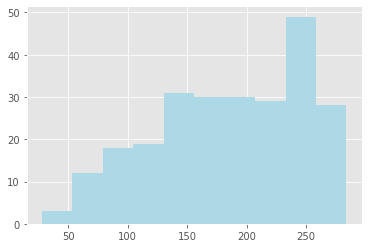

In [236]:
# checking the length of the characters gives us an idea of tweets length 
green['lemmatised'].str.len().hist(color='lightblue')
plt.show()

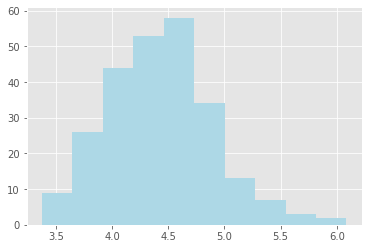

In [237]:
# checking the average word length for each sentences
green['lemmatised'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist(color='lightblue')
plt.show()

In [238]:
# discovering the words that is the most mentioned on twitter out of the four keywords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


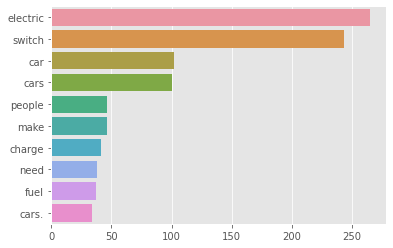

In [239]:
# plotting the graph 
plot_top_non_stopwords_barchart(green['lemmatised'])

In [240]:
# getting the graph with the trigram 
# creating the functions
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

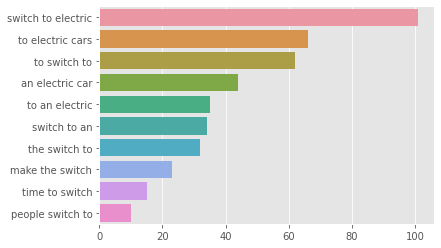

In [241]:
# visualising the trigram 
top_tri_grams=get_top_ngram(green['lemmatised'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

### Disruption in supply chain 

In [242]:
disruption = tweets[tweets.isin(['waiting time','material shortage','car purchasing']).any(axis=1)]
disruption

id        username           user_location       date  \
0      1536393070501060608          jh1791          South of North 2022-06-13   
8      1535896448310689793   PeterLattimer           County Durham 2022-06-12   
12     1535719880850296833     alex_packer        Halifax, England 2022-06-11   
16     1535589553981034496      Orangecroc          United Kingdom 2022-06-11   
22     1535387116447858696     Velocentric       Oxfordshire, UK.  2022-06-10   
...                    ...             ...                     ...        ...   
17554   952546354278133760          DrJagz                  London 2018-01-14   
17571   952143347346493440       evstreets         London, England 2018-01-13   
17734   949972939478372352   oldfarmhorace                Guernsey 2018-01-07   
17849   949047628834263040  mike_catterall  Accrington, Lancashire 2018-01-04   
17850   949038370340179973      livanirina           paris, france 2018-01-04   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
8               0             0          0   
12              1             0          0   
16              1             0          3   
22              0             0          0   
...           ...           ...        ...   
17554           0             1          0   
17571           0             0          0   
17734           0             0          0   
17849           0             0          0   
17850           0             0          0   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
8      perhaps they need the battery capacity either ...  material shortage   
12     the backlog has little to do with batteries an...  material shortage   
16     all used car prices are out of control at the ...  material shortage   
22     it has / it is pretty crazy. my car at 15k mil...  material shortage   
...                                                  ...                ...   
17554  all the more reason to buy an electric car if ...       waiting time   
17571   would you like to buy your new electric car via?       waiting time   
17734  i support the growth initiatives that electric...       waiting time   
17849  easy to spend other peoples money, ill drive a...       waiting time   
17850  perhaps you can go to madagascar and buy car o...       waiting time   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
8      2022  perhaps they need the battery capacity either ...  
12     2022  the backlog have little to do with batteries a...  
16     2022  all use car price be out of control at the mom...  
22     2022  it have / it be pretty crazy. my car at 15k mi...  
...     ...                                                ...  
17554  2018  all the more reason to buy an electric car if ...  
17571  2018   would you like to buy your new electric car via?  
17734  2018  i support the growth initiatives that electric...  
17849  2018  easy to spend other people money, ill drive an...  
17850  2018  perhaps you can go to madagascar and buy car o...  

[952 rows x 11 columns]

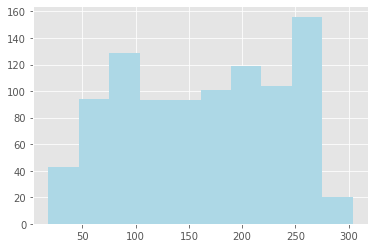

In [243]:
# checking the length of the characters gives us an idea of tweets length 
disruption['lemmatised'].str.len().hist(color='lightblue')
plt.show()

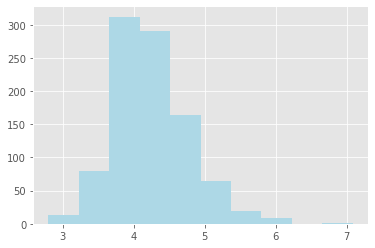

In [244]:
# checking the average word length for each sentences
disruption['lemmatised'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist(color='lightblue')
plt.show()

In [245]:
# discovering the words that is the most mentioned on twitter out of the four keywords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


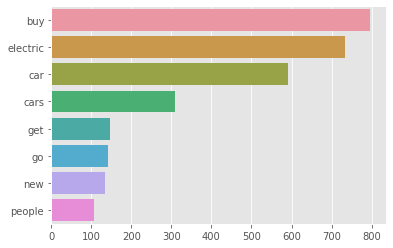

In [246]:
# plotting the graph 
plot_top_non_stopwords_barchart(disruption['lemmatised'])

In [247]:
# getting the graph with the trigram 
# creating the functions
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

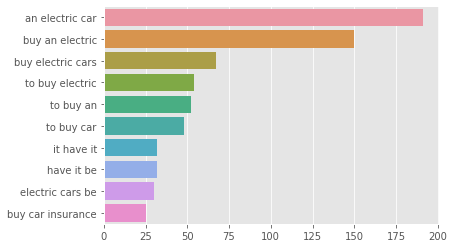

In [248]:
# visualising the trigram 
top_tri_grams=get_top_ngram(disruption['lemmatised'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

### Brands

In [249]:
brands = tweets[tweets.isin(['fiat']).any(axis=1)]
brands

id         username          user_location       date  \
71     1531771980147576833      MadgeOrrity         United Kingdom 2022-05-31   
72     1531767759683452928   SuriyaSubraman             London, UK 2022-05-31   
73     1531766812253339648      bbc_bitcoin        London, England 2022-05-31   
74     1531766272299606022      markjones41  Wales, United Kingdom 2022-05-31   
75     1531764891593453573    garrethmcdaid       Leitrim, Ireland 2022-05-31   
...                    ...              ...                    ...        ...   
17962   947820855932923904     mcguffiejake                    NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan              Edinburgh 2018-01-01   
17964   947655633301655553           L66six                    NaN 2018-01-01   
17965   947629853326630912       ThePollitt                Bristol 2018-01-01   
17966   947624679002423296            ttsls       Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
71              2             0          2   
72              0             1          1   
73              1             0          0   
74              1             1          5   
75              0             1          7   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content keywords  year  \
71     watch out, eb. before you know it, he shall / ...     fiat  2022   
72     today in fintech: bridging fiat, crypto | : in...     fiat  2022   
73     are you asking me for the use case of hard mon...     fiat  2022   
74     there are 2 things in my life that are certain...     fiat  2022   
75     helicopter money is one of the key milestones ...     fiat  2022   
...                                                  ...      ...   ...   
17962  happy new year only to the person who invented...     fiat  2018   
17963                                   fiat 500 twitter     fiat  2018   
17964                          - ,- ,- ,then last of all     fiat  2018   
17965  happy new year you magnificent swines. may you...     fiat  2018   
17966  happy new year! received this earlier from a f...     fiat  2018   

                                              lemmatised  
71     watch out, eb. before you know it, he shall / ...  
72     today in fintech: bridge fiat, crypto | : in t...  
73     be you ask me for the use case of hard money? ...  
74     there be 2 things in my life that be certain: ...  
75     helicopter money be one of the key milestones ...  
...                                                  ...  
17962  happy new year only to the person who invent t...  
17963                                   fiat 500 twitter  
17964                          - ,- ,- ,then last of all  
17965  happy new year you magnificent swines. may you...  
17966  happy new year! receive this earlier from a fr...  

[16766 rows x 11 columns]

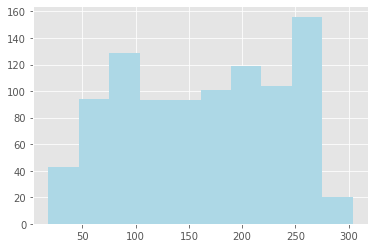

In [250]:
# checking the length of the characters gives us an idea of tweets length 
disruption['lemmatised'].str.len().hist(color='lightblue')
plt.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


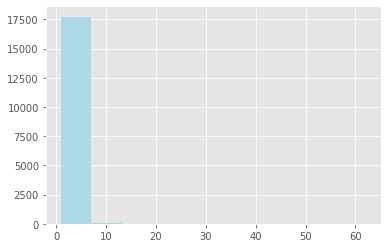

In [251]:
# checking the average word length for each sentences
tweets['lemmatised'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist(color='lightblue')
plt.show()

In [252]:
# discovering the words that is the most mentioned on twitter out of the four keywords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


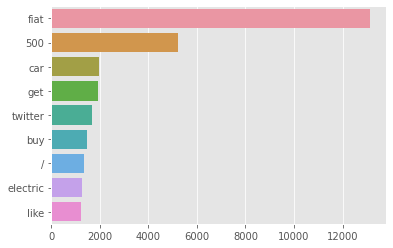

In [253]:
# plotting the graph 
plot_top_non_stopwords_barchart(tweets['lemmatised'])

In [254]:
# getting the graph with the trigram 
# creating the functions
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

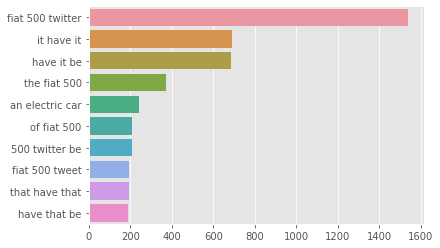

In [255]:
# visualising the trigram 
top_tri_grams=get_top_ngram(tweets['lemmatised'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

### All Keywords combined together (excluding fiat)

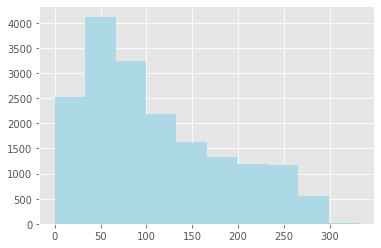

In [256]:
# checking the length of the characters gives us an idea of tweets length 
tweets['lemmatised'].str.len().hist(color='lightblue')
plt.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


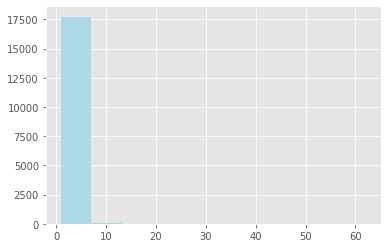

In [257]:
# checking the average word length for each sentences
tweets['lemmatised'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist(color='lightblue')
plt.show()

In [258]:
# discovering the words that is the most mentioned on twitter out of the four keywords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


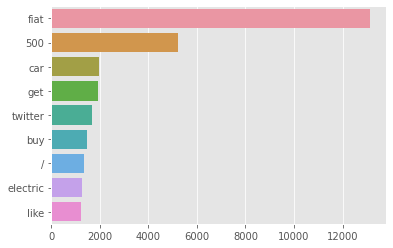

In [259]:
# plotting the graph 
plot_top_non_stopwords_barchart(tweets['lemmatised'])

In [260]:
# getting the graph with the trigram 
# creating the functions
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

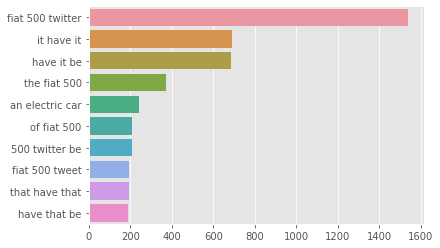

In [261]:
# visualising the trigram 
top_tri_grams=get_top_ngram(tweets['lemmatised'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

# NER

In [262]:
# loading the model
nlp = spacy.load('en_core_web_lg')

### Substainabilty 

In [263]:
# extracting green shift from the data 
green = tweets[tweets.isin(['green shift']).any(axis=1)]
green

id         username            user_location  \
1      1536344751426875392         alextomo           United Kingdom   
2      1536129427947589633  PaulHig55170875          London, England   
3      1536068863288303621           Tidos6                Liverpool   
4      1536060723452858370        Petchelli       Heywood lancashire   
5      1535965611855052800       bjfletcher            Sheffield, UK   
...                    ...              ...                      ...   
15411  1003960320271048704      eVCentresUK           United Kingdom   
15857   993759113187352576         BrumKong          Birminham #obvs   
16025   989862618348380163     dino5656_180      Chippenham, England   
16202   984836773212803074        sksanglia            East, England   
17877   948843941465554944           BWDDPH  England, United Kingdom   

            date  replyCount  retweetCount  likeCount  \
1     2022-06-13           5            14         35   
2     2022-06-12           0             0          0   
3     2022-06-12           1             0          0   
4     2022-06-12           1             0          6   
5     2022-06-12           1             0          2   
...          ...         ...           ...        ...   
15411 2018-06-05           0             0          0   
15857 2018-05-08           2             0          0   
16025 2018-04-27           0             0          0   
16202 2018-04-13           1             0          1   
17877 2018-01-04           3             7          9   

                                                 content     keywords  year  \
1      xr offshoot "roads rebellion" today targeting ...  green shift  2022   
2      fuel crisis: thefts on the rise is it time to ...  green shift  2022   
3      all cars are expensive .. if replacing switch ...  green shift  2022   
4      yep 100% fuel costs are rising in the hope it ...  green shift  2022   
5      i want to contribute to by switching our car t...  green shift  2022   
...                                                  ...          ...   ...   
15411  switch to electric cars threatens 75,000 germa...  green shift  2018   
15857  aware switch to cycling and public transport i...  green shift  2018   
16025  bosch diesel "breakthrough" great news for aut...  green shift  2018   
16202  they have got to switch to lpg, hydrogen or el...  green shift  2018   
17877  x marks the cross when electric cars will over...  green shift  2018   

                                              lemmatised  
1      xr offshoot "roads rebellion" today target toy...  
2      fuel crisis: thefts on the rise be it time to ...  
3      all cars be expensive .. if replace switch to ...  
4      yep 100% fuel cost be rise in the hope it will...  
5      i want to contribute to by switch our car to a...  
...                                                  ...  
15411  switch to electric cars threaten 75,000 german...  
15857  aware switch to cycle and public transport be ...  
16025  bosch diesel "breakthrough" great news for aut...  
16202  they have get to switch to lpg, hydrogen or el...  
17877  x mark the cross when electric cars will overt...  

[249 rows x 11 columns]

In [264]:
text_1 = green['lemmatised']
text_1 = text_1.to_list()
text_1

['xr offshoot "roads rebellion" today target toyota. they refuse to sign uk govt cop26 declaration on zero-emission cars and vans. toyota be last month rank the most anti-climate lobbyist in the sector and slowest to switch to electric vehicles.',
 'fuel crisis: thefts on the rise be it time to switch to an electric car?',
 'all cars be expensive .. if replace switch to a use ev far fewer problems as electric motor less expensive to service, fewer part ..no road tax to.. ..vroooom',
 'yep 100% fuel cost be rise in the hope it will force people to go electric so they can hit their target they forget that public transport in the uk be not like londons public transportation and not everyone lease a car so the switch could be a huge initial outlay for most',
 'i want to contribute to by switch our car to an electric one. to do that we need a new double pole isolation switch. i understand that only my energy supplier can do it. they be .',
 "hammersmith &amp; fulham already have the most el

In [265]:
# extract entities for comments
named_entities_1 = []
for content in text_1:
    temp_entity_name = ''
    temp_named_entity = None
    content = nlp(content)
    for word in content:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities_1.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame_1 = pd.DataFrame(named_entities_1, 
                            columns=['Entity Name', 'Entity Type'])
entity_frame_1

Entity Name Entity Type
0               xr         ORG
1            today        DATE
2           toyota         ORG
3             zero    CARDINAL
4           toyota         ORG
..             ...         ...
285             15    CARDINAL
286  75,000 german        NORP
287   bosch diesel         ORG
288            lpg         ORG
289             uk         GPE

[290 rows x 2 columns]

In [266]:
# extracting the entity of "ORG"
vehicle_brands_1 = entity_frame_1.loc[entity_frame_1["Entity Type"]=="ORG"]

# removing ORG entities that are not a vehicle brand
df_1 = vehicle_brands_1[vehicle_brands_1["Entity Name"].str.contains("eu|reg|eta|great news|pfft|pkp intercity|pch an electric car|nfu|mt marion|mt cattlin") == False]

# create a dataframe for vehicle entities
vehicles_entities_1 =(df_1.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

# converting into the dataframe
vehicles_entities_2 = pd.DataFrame(vehicles_entities_1)
# getting the top 10 
vehicles_entities_2[:10]

#note
#pch - used cars
#opel car brand 
#nevs- manufacturing in sweden 
#daimler- mecerdes car brand 

Entity Name Entity Type  Frequency
0                       evs         ORG          4
1                    nissan         ORG          3
2                    toyota         ORG          2
3  scotland ev electric car         ORG          2
4                       mx5         ORG          2
5          allegra stratton         ORG          1
6        mick mullane & amp         ORG          1
7                        xr         ORG          1
8                volkswagen         ORG          1
9                  uk house         ORG          1

In [267]:
# extracting the entity of "ORG"
vehicle_brands_1= entity_frame_1.loc[entity_frame_1["Entity Type"]=="ORG"]

# removing ORG entities that are not a vehicle brand
df_1 = vehicle_brands_1[vehicle_brands_1["Entity Name"].str.contains("eu|reg|eta|great news|pfft|pkp intercity|pch an electric car|nfu|mt marion|mt cattlin|uk house|treasury|snp") == False]

# create a dataframe for vehicle entities
vehicles_entities_1 =(df_1.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

# converting into the dataframe
vehicles_entities_1 = pd.DataFrame(vehicles_entities_1)
# getting the top 10 
vehicles_entities_1[:10]

Entity Name Entity Type  Frequency
0                       evs         ORG          4
1                    nissan         ORG          3
2                    toyota         ORG          2
3  scotland ev electric car         ORG          2
4                       mx5         ORG          2
5          allegra stratton         ORG          1
6                     mazda         ORG          1
7                        xr         ORG          1
8                volkswagen         ORG          1
9                   qashqai         ORG          1

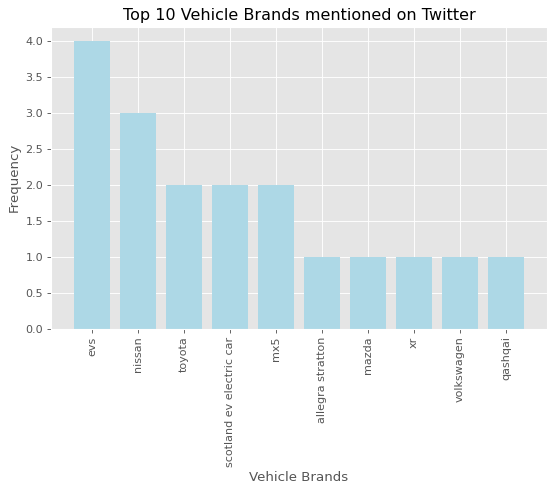

In [268]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.style.use('ggplot')

fig = figure(figsize=(8, 5), dpi=80)

plt.bar(vehicles_entities_1["Entity Name"][:10],vehicles_entities_1["Frequency"][:10],color='lightblue')
plt.xlabel("Vehicle Brands")
plt.ylabel("Frequency")
plt.title("Top 10 Vehicle Brands mentioned on Twitter")
plt.xticks(vehicles_entities_1["Entity Name"][:10],vehicles_entities_1["Entity Name"][:10],rotation=90)
plt.show()

### Supply Chain Disruption

In [269]:
disruption = tweets[tweets.isin(['waiting time','material shortage','car purchasing']).any(axis=1)]
disruption

id        username           user_location       date  \
0      1536393070501060608          jh1791          South of North 2022-06-13   
8      1535896448310689793   PeterLattimer           County Durham 2022-06-12   
12     1535719880850296833     alex_packer        Halifax, England 2022-06-11   
16     1535589553981034496      Orangecroc          United Kingdom 2022-06-11   
22     1535387116447858696     Velocentric       Oxfordshire, UK.  2022-06-10   
...                    ...             ...                     ...        ...   
17554   952546354278133760          DrJagz                  London 2018-01-14   
17571   952143347346493440       evstreets         London, England 2018-01-13   
17734   949972939478372352   oldfarmhorace                Guernsey 2018-01-07   
17849   949047628834263040  mike_catterall  Accrington, Lancashire 2018-01-04   
17850   949038370340179973      livanirina           paris, france 2018-01-04   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
8               0             0          0   
12              1             0          0   
16              1             0          3   
22              0             0          0   
...           ...           ...        ...   
17554           0             1          0   
17571           0             0          0   
17734           0             0          0   
17849           0             0          0   
17850           0             0          0   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
8      perhaps they need the battery capacity either ...  material shortage   
12     the backlog has little to do with batteries an...  material shortage   
16     all used car prices are out of control at the ...  material shortage   
22     it has / it is pretty crazy. my car at 15k mil...  material shortage   
...                                                  ...                ...   
17554  all the more reason to buy an electric car if ...       waiting time   
17571   would you like to buy your new electric car via?       waiting time   
17734  i support the growth initiatives that electric...       waiting time   
17849  easy to spend other peoples money, ill drive a...       waiting time   
17850  perhaps you can go to madagascar and buy car o...       waiting time   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
8      2022  perhaps they need the battery capacity either ...  
12     2022  the backlog have little to do with batteries a...  
16     2022  all use car price be out of control at the mom...  
22     2022  it have / it be pretty crazy. my car at 15k mi...  
...     ...                                                ...  
17554  2018  all the more reason to buy an electric car if ...  
17571  2018   would you like to buy your new electric car via?  
17734  2018  i support the growth initiatives that electric...  
17849  2018  easy to spend other people money, ill drive an...  
17850  2018  perhaps you can go to madagascar and buy car o...  

[952 rows x 11 columns]

In [270]:
text_2 = disruption['lemmatised']
text_2 = text_2.tolist()
text_2

['oh, hell yes. protip: do not total a 3yr old outback and have to buy a new car during a chip shortage....',
 'perhaps they need the battery capacity either for themselves or for extra income? and id guess they arent expand their range because 1. few people really want them, and 2. the chip shortage be hamper it as, i assume, they require even more chip than ice cars',
 "the backlog have little to do with batteries and everything to do with the chip shortage, which also affect fossil fuel cars like toyota hybrids. the world's largest carmaker be capable of offer a swathe of battery electric vehicles in europe, the us and china, but they do not.",
 'all use car price be out of control at the moment because of the chip shortage affect new car supply.',
 'it have / it be pretty crazy. my car at 15k miles be worth more than new because of the spec vs the chip shortage.',
 'shiply see use car shipments soar since semi-conductor chip shortage',
 'thank to the automobile club de louest, ther

In [271]:
# extract entities for comments
named_entities_2 = []
for content in text_2:
    temp_entity_name = ''
    temp_named_entity = None
    content = nlp(content)
    for word in content:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities_2.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame_2 = pd.DataFrame(named_entities_2, 
                            columns=['Entity Name', 'Entity Type'])
entity_frame_2

Entity Name Entity Type
0                  1    CARDINAL
1                  2    CARDINAL
2             toyota         ORG
3             europe         LOC
4                 us         GPE
...              ...         ...
1050         30 days        DATE
1051             138    CARDINAL
1052       about 3 %     PERCENT
1053  many years ago        DATE
1054      madagascar         GPE

[1055 rows x 2 columns]

In [272]:
# extracting the entity of "ORG"
vehicle_brands_2 = entity_frame_2.loc[entity_frame_2["Entity Type"]=="ORG"]

# removing ORG entities that are not a vehicle brand
df_2 = vehicle_brands_2[vehicle_brands_2["Entity Name"].str.contains("eu|reg|eta|great news|pfft|pkp intercity|pch an electric car|nfu|mt marion|mt cattlin") == False]

# create a dataframe for vehicle entities
vehicles_entities_2 =(df_2.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

# converting into the dataframe
vehicles_entities_2 = pd.DataFrame(vehicles_entities_2)
# getting the top 10 
vehicles_entities_2[:10]

#note
#pch - used cars
#opel car brand 
#nevs- manufacturing in sweden 
#daimler- mecerdes car brand 

Entity Name Entity Type  Frequency
0                     evs         ORG          6
1                    ford         ORG          5
2                   tesla         ORG          5
3                  nissan         ORG          4
4                     bev         ORG          3
5                    phev         ORG          3
6                 daimler         ORG          2
7  20,000 jaguar electric         ORG          2
8                     bmw         ORG          2
9        kind***meliorist         ORG          1

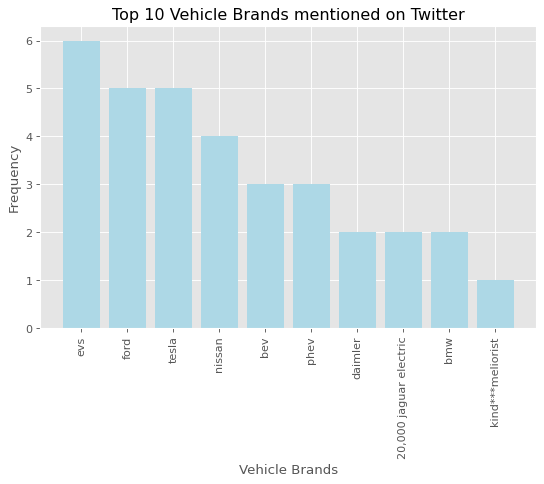

In [273]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.style.use('ggplot')

fig = figure(figsize=(8, 5), dpi=80)

plt.bar(vehicles_entities_2["Entity Name"][:10],vehicles_entities_2["Frequency"][:10],color='lightblue')
plt.xlabel("Vehicle Brands")
plt.ylabel("Frequency")
plt.title("Top 10 Vehicle Brands mentioned on Twitter")
plt.xticks(vehicles_entities_2["Entity Name"][:10],vehicles_entities_2["Entity Name"][:10],rotation=90)
plt.show()

### Combining keywords excluding fiats 

In [274]:
# excluding fiat keywords
fiat_exclude = tweets[tweets.isin(['waiting time','material shortage','car purchasing','green shift']).any(axis=1)]
fiat_exclude

id         username            user_location  \
0      1536393070501060608           jh1791           South of North   
1      1536344751426875392         alextomo           United Kingdom   
2      1536129427947589633  PaulHig55170875          London, England   
3      1536068863288303621           Tidos6                Liverpool   
4      1536060723452858370        Petchelli       Heywood lancashire   
...                    ...              ...                      ...   
17571   952143347346493440        evstreets          London, England   
17734   949972939478372352    oldfarmhorace                 Guernsey   
17849   949047628834263040   mike_catterall   Accrington, Lancashire   
17850   949038370340179973       livanirina            paris, france   
17877   948843941465554944           BWDDPH  England, United Kingdom   

            date  replyCount  retweetCount  likeCount  \
0     2022-06-13           0             0          2   
1     2022-06-13           5            14         35   
2     2022-06-12           0             0          0   
3     2022-06-12           1             0          0   
4     2022-06-12           1             0          6   
...          ...         ...           ...        ...   
17571 2018-01-13           0             0          0   
17734 2018-01-07           0             0          0   
17849 2018-01-04           0             0          0   
17850 2018-01-04           0             0          0   
17877 2018-01-04           3             7          9   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17571   would you like to buy your new electric car via?       waiting time   
17734  i support the growth initiatives that electric...       waiting time   
17849  easy to spend other peoples money, ill drive a...       waiting time   
17850  perhaps you can go to madagascar and buy car o...       waiting time   
17877  x marks the cross when electric cars will over...        green shift   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
1      2022  xr offshoot "roads rebellion" today target toy...  
2      2022  fuel crisis: thefts on the rise be it time to ...  
3      2022  all cars be expensive .. if replace switch to ...  
4      2022  yep 100% fuel cost be rise in the hope it will...  
...     ...                                                ...  
17571  2018   would you like to buy your new electric car via?  
17734  2018  i support the growth initiatives that electric...  
17849  2018  easy to spend other people money, ill drive an...  
17850  2018  perhaps you can go to madagascar and buy car o...  
17877  2018  x mark the cross when electric cars will overt...  

[1201 rows x 11 columns]

In [275]:
# extracting the lemmatised texts
text_3 = fiat_exclude['lemmatised']
text_3 = text_3.to_list()
text_3

['oh, hell yes. protip: do not total a 3yr old outback and have to buy a new car during a chip shortage....',
 'xr offshoot "roads rebellion" today target toyota. they refuse to sign uk govt cop26 declaration on zero-emission cars and vans. toyota be last month rank the most anti-climate lobbyist in the sector and slowest to switch to electric vehicles.',
 'fuel crisis: thefts on the rise be it time to switch to an electric car?',
 'all cars be expensive .. if replace switch to a use ev far fewer problems as electric motor less expensive to service, fewer part ..no road tax to.. ..vroooom',
 'yep 100% fuel cost be rise in the hope it will force people to go electric so they can hit their target they forget that public transport in the uk be not like londons public transportation and not everyone lease a car so the switch could be a huge initial outlay for most',
 'i want to contribute to by switch our car to an electric one. to do that we need a new double pole isolation switch. i unde

In [276]:
# extract entities for comments
named_entities_3 = []
for content in text_3:
    temp_entity_name = ''
    temp_named_entity = None
    content = nlp(content)
    for word in content:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities_3.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame_3 = pd.DataFrame(named_entities_3, 
                            columns=['Entity Name', 'Entity Type'])
entity_frame_3

Entity Name Entity Type
0                 xr         ORG
1              today        DATE
2             toyota         ORG
3               zero    CARDINAL
4             toyota         ORG
...              ...         ...
1340             138    CARDINAL
1341       about 3 %     PERCENT
1342  many years ago        DATE
1343      madagascar         GPE
1344              uk         GPE

[1345 rows x 2 columns]

In [277]:
# extracting the entity of "ORG"
vehicle_brands_3 = entity_frame_3.loc[entity_frame_3["Entity Type"]=="ORG"]

# removing ORG entities that are not a vehicle brand
df_3 = vehicle_brands_3[vehicle_brands_3["Entity Name"].str.contains("eu|/2|congress|great news|eta") == False]

# create a dataframe for vehicle entities
vehicles_entities_3 = (df_3.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

# converting into the dataframe
vehicles_entities_3 = pd.DataFrame(vehicles_entities_3)
# getting the top 10 
vehicles_entities_3[:10]

Entity Name Entity Type  Frequency
0         evs         ORG         10
1      nissan         ORG          7
2        ford         ORG          5
3       tesla         ORG          5
4         bev         ORG          3
5      toyota         ORG          3
6        phev         ORG          3
7  volkswagen         ORG          2
8     daimler         ORG          2
9         mx5         ORG          2

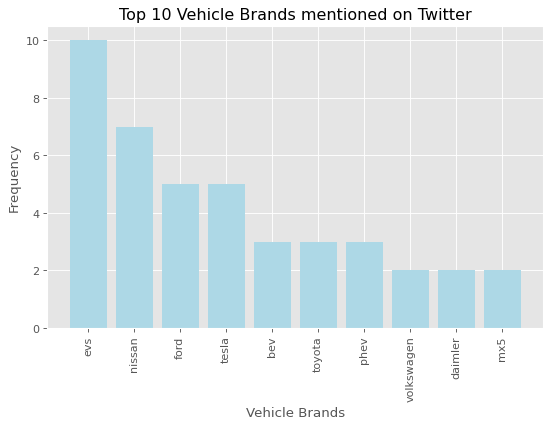

In [278]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.style.use('ggplot')

fig = figure(figsize=(8, 5), dpi=80)

plt.bar(vehicles_entities_3["Entity Name"][:10],vehicles_entities_3["Frequency"][:10],color='lightblue')
plt.xlabel("Vehicle Brands")
plt.ylabel("Frequency")
plt.title("Top 10 Vehicle Brands mentioned on Twitter")
plt.xticks(vehicles_entities_3["Entity Name"][:10],vehicles_entities_3["Entity Name"][:10],rotation=90)
plt.show()

# mx5 - Mazda MX5
# evs - manufacturing company 
# dailmer - merceded benz 
# phev - plug in hybrid 

# Topic Modelling

In [279]:
# extracting the lemmatised text out 
text_2 = tweets['lemmatised']
text_2

0        oh, hell yes. protip: do not total a 3yr old o...
1        xr offshoot "roads rebellion" today target toy...
2        fuel crisis: thefts on the rise be it time to ...
3        all cars be expensive .. if replace switch to ...
4        yep 100% fuel cost be rise in the hope it will...
                               ...                        
17962    happy new year only to the person who invent t...
17963                                     fiat 500 twitter
17964                            - ,- ,- ,then last of all
17965    happy new year you magnificent swines. may you...
17966    happy new year! receive this earlier from a fr...
Name: lemmatised, Length: 17967, dtype: object

In [280]:
#creating the tokens - 2mins
docs_tkns_1 = []
for doc in text_2:
    tmp = [
        token.lemma_
        for token in nlp(doc)
        if (not token.is_stop) & (not token.is_punct) & (not token.like_num) & (not token.is_currency) & (not token.pos_ == "PROPN")
        ]
    docs_tkns_1.append(tmp)
    del tmp

In [281]:
# getting the trigrams and bigrams
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
# find phrases
# finding the bigrams
bigram = Phrases(
    docs_tkns_1,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
#finding the trigrams
trigram = Phrases(
    bigram[docs_tkns_1],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased = [trigram[bigram[line]] for line in docs_tkns_1]

In [282]:
# using tomotopy 
import tomotopy as tp
# create a corpus using tp utilities
corpus = tp.utils.Corpus()
# populate the corpus
for item in docs_tkns_1:
    corpus.add_doc(words=item)

In [283]:
# estimate a model with 100 topics 
lda = tp.LDAModel(k=101, corpus=corpus, rm_top=1,seed=127)
# train the model
import random
random_state= 101
for i in range(0, 100, 10):
    lda.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, lda.ll_per_word))

Iteration: 0	Log-likelihood: -9.892397617202617
Iteration: 10	Log-likelihood: -9.465020140726459
Iteration: 20	Log-likelihood: -9.29303420558394
Iteration: 30	Log-likelihood: -9.179794389065183
Iteration: 40	Log-likelihood: -9.097764333729593
Iteration: 50	Log-likelihood: -9.044869503330517
Iteration: 60	Log-likelihood: -9.009455255128413
Iteration: 70	Log-likelihood: -8.964034943810914
Iteration: 80	Log-likelihood: -8.9271254653974
Iteration: 90	Log-likelihood: -8.910631699810237


In [284]:
# inspecting topic themes
random.seed(123)
values = {}
for k in range(lda.k):
    values['Topic {}'.format(k)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in lda.get_topic_words(k)]
    # print the table
    #return (table)
topics = pd.DataFrame(values) 
topics

Topic 0        Topic 1          Topic 2          Topic 3  \
0     air,(0.081)   seat,(0.041)    clean,(0.035)      not,(0.056)   
1  engine,(0.034)  start,(0.027)     roof,(0.028)     park,(0.042)   
2    twin,(0.029)    lot,(0.026)    track,(0.023)      wait,(0.04)   
3   litre,(0.025)   sure,(0.025)     wash,(0.021)  morning,(0.031)   
4   water,(0.025)   real,(0.021)    abarth,(0.02)     join,(0.029)   
5    unit,(0.023)  advert,(0.02)      wrap,(0.02)   ticket,(0.027)   
6     con,(0.023)  sting,(0.016)   factory,(0.02)    thank,(0.024)   
7  strong,(0.021)   shop,(0.016)  italian,(0.019)     away,(0.023)   
8     kit,(0.019)  catch,(0.016)   detail,(0.017)     game,(0.021)   
9     fit,(0.018)   soon,(0.016)    sport,(0.017)    great,(0.019)   

            Topic 4           Topic 5           Topic 6           Topic 7  \
0     value,(0.053)       new,(0.056)       car,(0.156)        day,(0.05)   
1    crypto,(0.049)     panda,(0.046)  electric,(0.127)         m,(0.047)   
2  currency,(0.047)       van,(0.042)       buy,(0.055)     happy,(0.045)   
3      money,(0.04)  original,(0.027)    switch,(0.052)      look,(0.041)   
4       use,(0.032)   feature,(0.027)    charge,(0.039)        wee,(0.04)   
5  exchange,(0.026)    double,(0.022)    people,(0.027)     today,(0.034)   
6     world,(0.025)     stick,(0.022)       fuel,(0.02)   finally,(0.024)   
7    system,(0.023)      look,(0.022)   vehicle,(0.018)      head,(0.021)   
8      real,(0.019)     ducato,(0.02)     point,(0.017)      pick,(0.018)   
9    people,(0.019)   upgrade,(0.019)   battery,(0.014)  birthday,(0.017)   

          Topic 8         Topic 9  ...         Topic 91        Topic 92  \
0     try,(0.051)    look,(0.089)  ...    panda,(0.087)    good,(0.125)   
1     bad,(0.039)    like,(0.058)  ...    thing,(0.049)    body,(0.041)   
2      ve,(0.031)    nice,(0.041)  ...    think,(0.045)  colour,(0.038)   
3    half,(0.029)   black,(0.029)  ...      way,(0.029)    luck,(0.032)   
4    help,(0.028)     ask,(0.026)  ...      big,(0.028)   paint,(0.028)   
5    fast,(0.026)  abarth,(0.025)  ...    watch,(0.026)     amp,(0.018)   
6    read,(0.025)     rip,(0.023)  ...      sit,(0.022)     job,(0.018)   
7    race,(0.019)   night,(0.022)  ...   minute,(0.021)   issue,(0.018)   
8    time,(0.019)      way,(0.02)  ...  chinese,(0.021)    love,(0.017)   
9  street,(0.018)   cause,(0.018)  ...    crave,(0.016)   stick,(0.016)   

              Topic 93         Topic 94       Topic 95         Topic 96  \
0           la,(0.028)  twitter,(0.099)    not,(0.102)  twitter,(0.108)   
1         idea,(0.024)     girl,(0.063)   know,(0.078)     dark,(0.102)   
2        issue,(0.024)     fuck,(0.047)      m,(0.073)    fruit,(0.076)   
3         know,(0.024)    tweet,(0.045)   like,(0.067)      come,(0.02)   
4       brexit,(0.022)      man,(0.038)     ve,(0.046)   racism,(0.019)   
5          area,(0.02)       not,(0.03)   feel,(0.035)    drink,(0.018)   
6         cost,(0.015)    thing,(0.026)   need,(0.034)     grey,(0.016)   
7  reliability,(0.014)  fiat500,(0.021)  think,(0.029)    group,(0.014)   
8         road,(0.014)       boy,(0.02)   want,(0.025)   colour,(0.013)   
9          amp,(0.014)        u,(0.018)   good,(0.022)   forget,(0.012)   

         Topic 97          Topic 98           Topic 99          Topic 100  
0    fuck,(0.066)       way,(0.047)        amp,(0.151)     family,(0.061)  
1    girl,(0.065)       let,(0.037)       book,(0.049)      thank,(0.043)  
2   white,(0.059)      turn,(0.037)        car,(0.029)  beautiful,(0.027)  
3   basic,(0.047)     start,(0.032)     design,(0.028)       roof,(0.023)  
4       x,(0.043)      time,(0.028)  available,(0.025)       time,(0.023)  
5   bitch,(0.034)  multipla,(0.027)      valet,(0.024)      member,(0.02)  
6        m,(0.03)       try,(0.024)      limit,(0.018)    morning,(0.017)  
7  twitter,(0.03)      good,(0.024)       view,(0.018)       open,(0.017)  
8    know,(0.028)      know,(0.018)     online,(0.014) 

In [285]:
# getting the umass coherecne score- 6mins
cvs = {}
for topic_number in range(1, 101, 1):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus,seed=127)
    for i in range(0, 100, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score()

Iteration: 0	Log-likelihood: -7.970824768788511
Iteration: 10	Log-likelihood: -7.970824768788511
Iteration: 20	Log-likelihood: -7.970824768788511
Iteration: 30	Log-likelihood: -7.970824768788511
Iteration: 40	Log-likelihood: -7.970824768788511
Iteration: 50	Log-likelihood: -7.970824768788511
Iteration: 60	Log-likelihood: -7.970824768788511
Iteration: 70	Log-likelihood: -7.970824768788511
Iteration: 80	Log-likelihood: -7.970824768788511
Iteration: 90	Log-likelihood: -7.970824768788511
Iteration: 0	Log-likelihood: -8.270972052829194
Iteration: 10	Log-likelihood: -8.262927035827381
Iteration: 20	Log-likelihood: -8.202112290976814
Iteration: 30	Log-likelihood: -8.132119962600004
Iteration: 40	Log-likelihood: -8.098773745502141
Iteration: 50	Log-likelihood: -8.077304309843262
Iteration: 60	Log-likelihood: -8.062705395425661
Iteration: 70	Log-likelihood: -8.05515660259974
Iteration: 80	Log-likelihood: -8.049386846929835
Iteration: 90	Log-likelihood: -8.045139581998749
Iteration: 0	Log-likeli

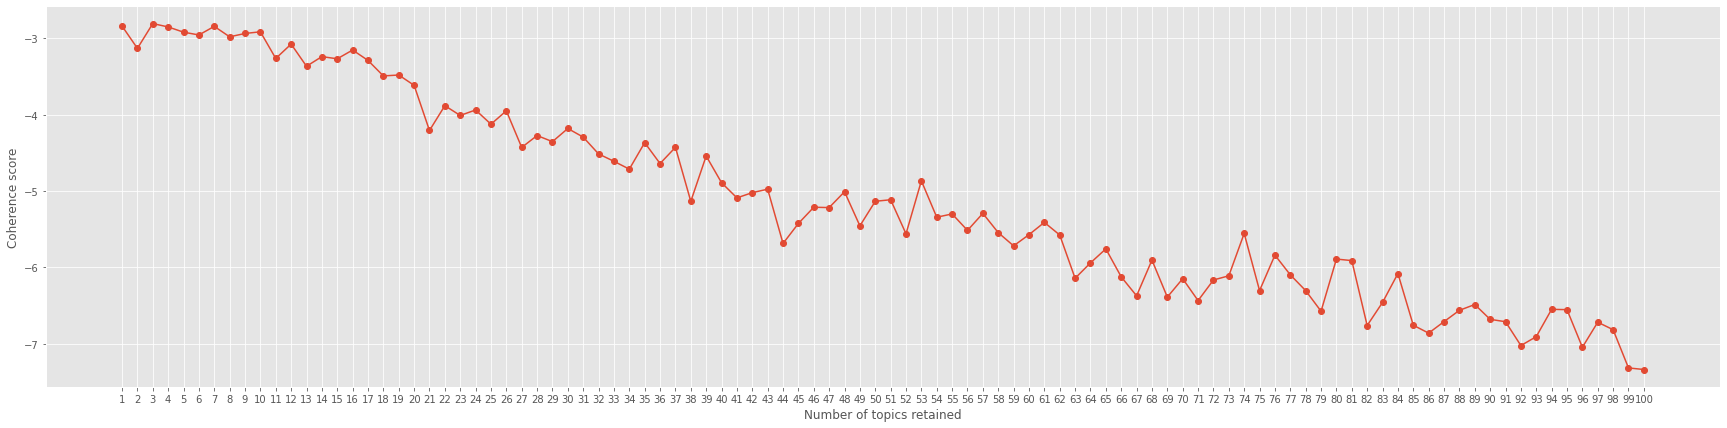

In [286]:
# plot coherence scores
fig = plt.figure(figsize=(30, 7))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 101, 1))
plt.show()

In [287]:
# create the model with  topics- based on the cohesion score 
lda_1 = tp.LDAModel(k=18, corpus=corpus, min_cf=2, rm_top=1,seed=127)
# train the model
random_state= 101
for i in range(0, 100, 10):
    lda_1.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, lda_1.ll_per_word))

Iteration: 0	Log-likelihood: -8.77039980446807
Iteration: 10	Log-likelihood: -8.437864512864591
Iteration: 20	Log-likelihood: -8.301390296456177
Iteration: 30	Log-likelihood: -8.227874249690942
Iteration: 40	Log-likelihood: -8.177287962236123
Iteration: 50	Log-likelihood: -8.147152956570508
Iteration: 60	Log-likelihood: -8.113966698950737
Iteration: 70	Log-likelihood: -8.101943512426267
Iteration: 80	Log-likelihood: -8.083735291414971
Iteration: 90	Log-likelihood: -8.07141123840999


In [288]:
#  getting the word probabilty 
random.seed(123)
values = {}
for k in range(lda_1.k):
    values['Topic {}'.format(k)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in lda_1.get_topic_words(k)]
    # print the table
    # return (table)
final_topics = pd.DataFrame(values) 
final_topics

Topic 0           Topic 1        Topic 2          Topic 3  \
0       car,(0.113)       buy,(0.031)   look,(0.039)       go,(0.026)   
1       buy,(0.062)       want,(0.02)   good,(0.023)       to,(0.021)   
2  electric,(0.034)     crypto,(0.02)   like,(0.023)  interest,(0.02)   
3    charge,(0.027)     price,(0.019)  great,(0.018)   people,(0.019)   
4       new,(0.018)       use,(0.017)  right,(0.014)     like,(0.018)   
5     point,(0.016)      sell,(0.014)  think,(0.012)     time,(0.012)   
6       not,(0.016)       pay,(0.013)      d,(0.012)    think,(0.012)   
7      year,(0.015)  exchange,(0.012)   know,(0.012)  support,(0.011)   
8      need,(0.015)      card,(0.011)   come,(0.011)      pay,(0.011)   
9    people,(0.012)    convert,(0.01)  thing,(0.011)   problem,(0.01)   

          Topic 4        Topic 5          Topic 6         Topic 7  \
0  little,(0.028)   look,(0.035)  twitter,(0.105)   drive,(0.053)   
1     day,(0.023)   like,(0.035)      not,(0.072)     car,(0.047)   
2    love,(0.022)  think,(0.025)     love,(0.031)     year,(0.02)   
3   today,(0.022)   good,(0.025)    tweet,(0.021)    park,(0.018)   
4     new,(0.017)  panda,(0.022)        s,(0.019)    road,(0.016)   
5    year,(0.017)  drive,(0.018)   island,(0.014)  little,(0.015)   
6    time,(0.015)   sure,(0.016)        x,(0.014)  driver,(0.014)   
7    good,(0.014)    not,(0.015)     know,(0.013)     day,(0.013)   
8   great,(0.013)   bite,(0.014)     girl,(0.012)   panda,(0.013)   
9    life,(0.012)    yes,(0.014)        m,(0.011)    time,(0.013)   

            Topic 8           Topic 9         Topic 10         Topic 11  \
0       car,(0.039)       car,(0.126)  twitter,(0.077)      car,(0.059)   
1      year,(0.031)  electric,(0.109)     like,(0.037)    drive,(0.058)   
2       old,(0.025)        buy,(0.07)    tweet,(0.031)    offer,(0.053)   
3      like,(0.021)    switch,(0.028)      not,(0.027)       buy,(0.05)   
4       day,(0.016)   vehicle,(0.018)     girl,(0.026)    stock,(0.049)   
5      good,(0.016)    petrol,(0.018)        m,(0.025)      end,(0.048)   
6     great,(0.016)    diesel,(0.016)     fuck,(0.022)     stay,(0.047)   
7     panda,(0.015)    people,(0.014)     want,(0.015)     free,(0.046)   
8      look,(0.015)      fuel,(0.013)       ve,(0.015)      amp,(0.046)   
9  probably,(0.015)      cost,(0.011)  fiat500,(0.014)  classic,(0.044)   

        Topic 12        Topic 13         Topic 14            Topic 15  \
0    new,(0.031)   wheel,(0.026)      new,(0.041)    currency,(0.054)   
1    amp,(0.026)    turn,(0.019)  service,(0.029)       money,(0.053)   
2    car,(0.024)  engine,(0.017)      amp,(0.021)      bitcoin,(0.02)   
3  check,(0.019)    time,(0.016)      car,(0.017)        bank,(0.017)   
4  coupe,(0.017)       =,(0.016)    month,(0.014)        gold,(0.016)   
5   come,(0.012)   light,(0.013)     sell,(0.013)  government,(0.015)   
6  today,(0.012)   drive,(0.013)     need,(0.012)       value,(0.015)   
7  think,(0.012)   blast,(0.013)      day,(0.011)      system,(0.012)   
8  guess,(0.012)    rear,(0.012)     time,(0.011)        need,(0.011)   
9   know,(0.011)   paint,(0.011)     week,(0.011)      crypto,(0.011)   

           Topic 16        Topic 17  
0       key,(0.042)     not,(0.028)  
1        car,(0.03)       s,(0.019)  
2       amp,(0.026)     way,(0.016)  
3       new,(0.023)    know,(0.016)  
4    abarth,(0.022)       m,(0.016)  
5       cut,(0.019)     use,(0.015)  
6       van,(0.014)   think,(0.015)  
7      auto,(0.014)  people,(0.015)  
8       fit,(0.013)    need,(0.015)  
9  customer,(0.012)  change,(0.014)

### Selecting the optimum model (LDA)

In [289]:
# optimum topic model
mdl_1 = tp.LDAModel(min_df=2, rm_top=1, k=18, corpus=corpus, min_cf=1,seed=127)
mdl_1.train(0)

print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(mdl_1.docs), len(mdl_1.used_vocabs), mdl_1.num_words
))
print('Removed Top words: ', *mdl_1.removed_top_words)

Num docs:17381, Num Vocabs:6929, Total Words:140852
Removed Top words:  fiat


In [290]:
# visualise the model 
topic_term_dists = np.stack([mdl_1.get_topic_word_dist(k) for k in range(mdl_1.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl_1.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc_1.words) for doc_1 in mdl_1.docs])
vocab = list(mdl_1.used_vocabs)
term_frequency = mdl_1.used_vocab_freq

# producing the graph
import pyLDAvis
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    # start_index=0, 
    sort_topics=False 
)

pyLDAvis.display(prepared_data)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


### Second round of filtering the topics 

In [291]:
# further insights in what the topic are saying 
# getting the topic modelling based on the top probabity 
from pandas import option_context
random.seed(123)
import tmplot
topics = tmplot.get_top_docs(docs=text_2, model=mdl_1)
with option_context('display.max_colwidth', 400):
    display(topics.head())

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic0  \
0                                                                                                                                                                                                 i get take over by a fiat 500 on the m6 and i may as well give up drive at this point   
1  you mean you do not want to invest in the people. you can create 400 billion to bail the bank out 2019. 37 billion for a worthless track and trace. the stock market be a ponzi scheme and everything out of the word. real money be create interest on money that do not exist fiat   
2                                                                                                                                                                                                                                                               well its not a fiat lol   
3                                                                                                          any claim of democratic authority long go - rule by fiat. i'm really conflict by the leak though. vital but i hope it have / it be not someone break the civil service code.   
4                                                                                                                                                                                                                                                             i fully turn into fiat500   

                                                                                                                                                                                                               topic1  \
0                                                                                                                                                           we go gardening.... also i have a fiat panda garden bench   
1  you preach mental health, but be the first to mock the love island contestants as soon as theyre reveal for cheap retweets. fiat 500 twitter truly be a disgustingly toxic place. get off your high horse please x   
2                                                                                        in the next 3 months i've 2 huge trip to complete in old tiny fiat's i'll be a bite more smug after i've those under my belt   
3                                                                                                                                                           find this fiat moretti 850 sportiva 50 horse power of fun   
4                                                                                                                               this sting and fiat advert be horrendous, seriously a song about unleaded petrol haha   

                                                                                                                                                                                                                                                      topic2  \
0                                                                                                                                                                     its turn into a fiat500 tweet see load of bird moan about others not stay indoors bore   
1                                                                                                                                                                                       please explain to this fiat 500 tweet the point of have a apprentice   
2                                                                                                                                                                                                                     what in the fiat 500 be a little moon?   
3                                                                                                                                                                                       blimey, get well soon chap, i think fiat's be better for your h

In [292]:
# getting all the docs
from pandas import option_context
random.seed(123)
import tmplot
topics_p = tmplot.get_top_docs(docs=text_2, model=mdl_1,docs_num=17967)
with option_context('display.max_colwidth', 400):
    display(topics_p)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic0  \
0                                                                                                                                                                                                     i get take over by a fiat 500 on the m6 and i may as well give up drive at this point   
1      you mean you do not want to invest in the people. you can create 400 billion to bail the bank out 2019. 37 billion for a worthless track and trace. the stock market be a ponzi scheme and everything out of the word. real money be create interest on money that do not exist fiat   
2                                                                                                                                                                                                                                                                   well its not a fiat lol   
3                                                                                                              any claim of democratic authority long go - rule by fiat. i'm really conflict by the leak though. vital but i hope it have / it be not someone break the civil service code.   
4                                                                                                                                                                                                                                                                 i fully turn into fiat500   
...                                                                                                                                                                                                                                                                                     ...   
17376               let us say i sell you a service for 10 bsv. bsv be at 150$ when we sign come the time to pay, bsv be at 130$ silly me i ask for payment in bsv instead of fiat now i win 1300$ instead of 1500$ but that will never happen again cause i will not charge in bsv anymore   
17377                                                                                                                                                                                                               fast, faster, fastest: the electric vehicle charge station race heat up   
17378                                                                                                                                                                                                                         use their greatest weapon against them fiat500 days be number   
17379                                   drive down duel carriageway do 65 on the outside lane. woman in her wank fiat 500 pull out at 50, last min, signal. naturally i'm immediately up her arse. she shake her head and contunes at 50 give me the wtf hand in her mirror. learn to drive   
17380                                                                                                                                                                                                            when bf and gf go to race each other back to birmingham! ranger vs fiat500   

                                                                                                                                                                                                                                                               topic1  \
0                                                                                                                                                                                                           we go gardening.... also i have a fiat panda garden bench   
1                                                  you preach mental health, but be the first to mock the love island contestants as soon as theyre reveal for cheap retweets. fiat 500 twitter truly be a disgustingly toxic place. get off your high horse please x   
2                                    

#### Notes - based on the topic 5 doc probabilty
- 0 - fiat (fiat)
- 1 - fiat model (fiat)
- 2 - fiat 500 (fiat)
- 3 - dealers (dealers)
- 4 - drop
- 5 - opinon on fiat 500 (fiat)
- 6 - drop
- 7 - fiat electric vehicle (EV)
- 8 - drop
- 9 - feelings about fiat (fiat)
- 10 - drop
- 11 - drop
- 12 - drop
- 13 - fiat production line(Production line)
- 14 - electric car general(EV)
- 15 - drop
- 16 - Fiat brands and enviorment(EV)
- 17 - drop

In [293]:
# retained topics
# convert it intop the dataframe 
topics_p = pd.DataFrame(topics_p)

# dropping some of the topics
df_retain = topics_p.drop(['topic4','topic6','topic8','topic10','topic11','topic12','topic15','topic17'], axis=1)
# renaming the topics 
df_retain = df_retain.rename(columns={'topic0':"Fiat",'topic1':"Fiat_Model",'topic2':"Fiat_500",'topic3':"Dealers",'topic5':"Opinons_Fiat",'topic7':"Fiat_EV",'topic9':"Feelings_EV",'topic13':"Fiat_Production",'topic14':"EV",'topic16':"FiatBrands_Green"})
df_retain

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat  \
0      i get take over by a fiat 500 on the m6 and i ...   
1      you mean you do not want to invest in the peop...   
2                                well its not a fiat lol   
3      any claim of democratic authority long go - ru...   
4                              i fully turn into fiat500   
...                                                  ...   
17376  let us say i sell you a service for 10 bsv. bs...   
17377  fast, faster, fastest: the electric vehicle ch...   
17378  use their greatest weapon against them fiat500...   
17379  drive down duel carriageway do 65 on the outsi...   
17380  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                                 Dealers  \
0      superb customer service from richard at the ca...   
1      i look through your idea on tax base money con...   
2                      look like racist fiat 500 twitter   
3      the car dealership have give me a courtesy car...   
4      2020-2021 fiat, equity, property correction wi...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377                           it get mark as very good   
17378  i may be wrong but most car journey be less th...   
17379  couldnt you have at least fill that fine new f...   
17380  the 10th vehicle for our best customer, a 1 da...   

                                            Opinons_Fiat  \
0      panicking! can i fit everything in my fiat 500...   
1      surprise fiat 500 do not moan about the cast f...   
2                all i see be fiat 500 girls come for me   
3      because at the moment i'm unclear on your uniq...   
4            it look more like a kei car than a fiat 500   
...                                                  ...   
17376  fast, faster, fastest: the electric vehicle ch...   
17377  not to sound all fiat 500 but i be crave chine...   
17378                           it get mark as very good   
17379  high fuel rake in cost of vaccines &amp; lockd...   
17380  i may be wrong but most car journey be less th...   

                                                 Fiat_EV  \
0      ebay, come as a kit with the adaptor cable and...   
1      theoretically the gold supply in the universe ...   
2                               fiat 500 tweet this mate   
3      at least we have power, unlike texas and calif...   
4      from 15-26 june we be host our fiat electric e...   
...                                                  ...   
17376  i agree!!! my little

### Making the features for Sales Model

In [294]:
# get topic probabilities for all documents
prob = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in mdl_1.docs]),
    columns=["topic_{}".format(i + 1) for i in range(mdl_1.k)],
)

# getting the proability
prob

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0      0.085938  0.085938  0.007812  0.007812  0.085938  0.085938  0.007812   
1      0.004808  0.052885  0.052885  0.052885  0.100962  0.052885  0.004808   
2      0.010204  0.010204  0.010204  0.010204  0.010204  0.010204  0.112245   
3      0.117978  0.061798  0.005618  0.061798  0.117978  0.174157  0.061798   
4      0.092105  0.004386  0.092105  0.092105  0.092105  0.048246  0.004386   
...         ...       ...       ...       ...       ...       ...       ...   
17376  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
17377  0.011364  0.238636  0.011364  0.011364  0.011364  0.011364  0.125000   
17378  0.035714  0.035714  0.035714  0.392857  0.035714  0.035714  0.035714   
17379  0.012821  0.141026  0.012821  0.012821  0.141026  0.012821  0.141026   
17380  0.011364  0.011364  0.125000  0.125000  0.125000  0.125000  0.011364   

        topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  topic_14  \
0      0.007812  0.242187  0.085938  0.007812  0.164062  0.007812  0.007812   
1      0.197115  0.149038  0.100962  0.100962  0.004808  0.004808  0.004808   
2      0.214286  0.112245  0.112245  0.010204  0.010204  0.112245  0.112245   
3      0.061798  0.005618  0.005618  0.061798  0.005618  0.061798  0.117978   
4      0.004386  0.048246  0.135965  0.004386  0.048246  0.048246  0.048246   
...         ...       ...       ...       ...       ...       ...       ...   
17376  0.289474  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
17377  0.011364  0.011364  0.011364  0.011364  0.011364  0.238636  0.125000   
17378  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714   
17379  0.012821  0.141026  0.141026  0.012821  0.012821  0.012821  0.012821   
17380  0.011364  0.125000  0.011364  0.011364  0.011364  0.011364  0.125000   

       topic_15  topic_16  topic_17  topic_18  
0      0.007812  0.007812  0.085938  0.007812  
1      0.052885  0.004808  0.004808  0.052885  
2      0.010204  0.112245  0.010204  0.010204  
3      0.005618  0.061798  0.005618  0.005618  
4      0.135965  0.048246  0.048246  0.004386  
...         ...       ...       ...       ...  
17376  0.026316  0.289474  0.026316  0.026316  
17377  0.011364  0.011364  0.125000  0.011364  
17378  0.035714  0.035714  0.035714  0.035714  
17379  0.012821  0.141026  0.012821  0.012821  
17380  0.011364  0.011364  0.125000  0.011364  

[17381 rows x 18 columns]

In [295]:
 # dropping the topics that are not relevant to fiat
df_final = prob.drop(['topic_4','topic_6','topic_8','topic_10','topic_11','topic_12','topic_15','topic_17'], axis=1)
df_final

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_1   topic_2   topic_3   topic_5   topic_7   topic_9  topic_13  \
0      0.085938  0.085938  0.007812  0.085938  0.007812  0.242187  0.007812   
1      0.004808  0.052885  0.052885  0.100962  0.004808  0.149038  0.004808   
2      0.010204  0.010204  0.010204  0.010204  0.112245  0.112245  0.112245   
3      0.117978  0.061798  0.005618  0.117978  0.061798  0.005618  0.061798   
4      0.092105  0.004386  0.092105  0.092105  0.004386  0.048246  0.048246   
...         ...       ...       ...       ...       ...       ...       ...   
17376  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
17377  0.011364  0.238636  0.011364  0.011364  0.125000  0.011364  0.238636   
17378  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714   
17379  0.012821  0.141026  0.012821  0.141026  0.141026  0.141026  0.012821   
17380  0.011364  0.011364  0.125000  0.125000  0.011364  0.125000  0.011364   

       topic_14  topic_16  topic_18  
0      0.007812  0.007812  0.007812  
1      0.004808  0.004808  0.052885  
2      0.112245  0.112245  0.010204  
3      0.117978  0.061798  0.005618  
4      0.048246  0.048246  0.004386  
...         ...       ...       ...  
17376  0.026316  0.289474  0.026316  
17377  0.125000  0.011364  0.011364  
17378  0.035714  0.035714  0.035714  
17379  0.012821  0.141026  0.012821  
17380  0.125000  0.011364  0.011364  

[17381 rows x 10 columns]

In [296]:
# appending final topic modelling and probabilty 
g = df_final.filter(like='topic')
df_final['final_topic'] = g.idxmax(axis=1)
df_final["final_topic_prob"] = df_final.max(axis=1)
df_final

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-296-988e89d8f02a>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_final["final_topic_prob"] = df_final.max(axis=1)


topic_1   topic_2   topic_3   topic_5   topic_7   topic_9  topic_13  \
0      0.085938  0.085938  0.007812  0.085938  0.007812  0.242187  0.007812   
1      0.004808  0.052885  0.052885  0.100962  0.004808  0.149038  0.004808   
2      0.010204  0.010204  0.010204  0.010204  0.112245  0.112245  0.112245   
3      0.117978  0.061798  0.005618  0.117978  0.061798  0.005618  0.061798   
4      0.092105  0.004386  0.092105  0.092105  0.004386  0.048246  0.048246   
...         ...       ...       ...       ...       ...       ...       ...   
17376  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
17377  0.011364  0.238636  0.011364  0.011364  0.125000  0.011364  0.238636   
17378  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714   
17379  0.012821  0.141026  0.012821  0.141026  0.141026  0.141026  0.012821   
17380  0.011364  0.011364  0.125000  0.125000  0.011364  0.125000  0.011364   

       topic_14  topic_16  topic_18 final_topic  final_topic_prob  
0      0.007812  0.007812  0.007812     topic_9          0.242187  
1      0.004808  0.004808  0.052885     topic_9          0.149038  
2      0.112245  0.112245  0.010204     topic_7          0.112245  
3      0.117978  0.061798  0.005618     topic_1          0.117978  
4      0.048246  0.048246  0.004386     topic_1          0.092105  
...         ...       ...       ...         ...               ...  
17376  0.026316  0.289474  0.026316    topic_16          0.289474  
17377  0.125000  0.011364  0.011364     topic_2          0.238636  
17378  0.035714  0.035714  0.035714     topic_1          0.035714  
17379  0.012821  0.141026  0.012821     topic_2          0.141026  
17380  0.125000  0.011364  0.011364     topic_3          0.125000  

[17381 rows x 12 columns]

In [297]:
# creating an empty data coloumns
df_final['Topics_labels'] = ''
df_final

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_1   topic_2   topic_3   topic_5   topic_7   topic_9  topic_13  \
0      0.085938  0.085938  0.007812  0.085938  0.007812  0.242187  0.007812   
1      0.004808  0.052885  0.052885  0.100962  0.004808  0.149038  0.004808   
2      0.010204  0.010204  0.010204  0.010204  0.112245  0.112245  0.112245   
3      0.117978  0.061798  0.005618  0.117978  0.061798  0.005618  0.061798   
4      0.092105  0.004386  0.092105  0.092105  0.004386  0.048246  0.048246   
...         ...       ...       ...       ...       ...       ...       ...   
17376  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
17377  0.011364  0.238636  0.011364  0.011364  0.125000  0.011364  0.238636   
17378  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714   
17379  0.012821  0.141026  0.012821  0.141026  0.141026  0.141026  0.012821   
17380  0.011364  0.011364  0.125000  0.125000  0.011364  0.125000  0.011364   

       topic_14  topic_16  topic_18 final_topic  final_topic_prob  \
0      0.007812  0.007812  0.007812     topic_9          0.242187   
1      0.004808  0.004808  0.052885     topic_9          0.149038   
2      0.112245  0.112245  0.010204     topic_7          0.112245   
3      0.117978  0.061798  0.005618     topic_1          0.117978   
4      0.048246  0.048246  0.004386     topic_1          0.092105   
...         ...       ...       ...         ...               ...   
17376  0.026316  0.289474  0.026316    topic_16          0.289474   
17377  0.125000  0.011364  0.011364     topic_2          0.238636   
17378  0.035714  0.035714  0.035714     topic_1          0.035714   
17379  0.012821  0.141026  0.012821     topic_2          0.141026   
17380  0.125000  0.011364  0.011364     topic_3          0.125000   

      Topics_labels  
0                    
1                    
2                    
3                    
4                    
...             ...  
17376                
17377                
17378                
17379                
17380                

[17381 rows x 13 columns]

In [298]:
# creating a dictionary to append the conceptual groups
# my_dict = {'topic_1': 'Fiat', 'topic_2': 'Fiat_Model','topic_3':'Fiat_500','topic_5':'Dealers','topic_7':'Opinons_Fiat','topic_9':'Fiat_EV','topic_13':'Feelings_EV','topic_14':'Fiat_Production','topic_16':'EV','topic_18':'FiatBrands_Green'}
my_dict = {'topic_1': 'Fiat', 'topic_2': 'Fiat','topic_3':'Fiat','topic_5':'Dealers','topic_7':'Fiat','topic_9':'EV&Substanbilty','topic_13':'EV&Substanbilty','topic_14':'Fiat_Production','topic_16':'EV&Substanbilty','topic_18':'EV&Substanbilty'}

i=0 
for i in range(len(df_final)):
    my_key=df_final.at[i,'final_topic']
    my_label=my_dict.get(my_key)
    df_final.at[i,'Topics_labels']=my_label

    i+=1

df_final

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_1   topic_2   topic_3   topic_5   topic_7   topic_9  topic_13  \
0      0.085938  0.085938  0.007812  0.085938  0.007812  0.242187  0.007812   
1      0.004808  0.052885  0.052885  0.100962  0.004808  0.149038  0.004808   
2      0.010204  0.010204  0.010204  0.010204  0.112245  0.112245  0.112245   
3      0.117978  0.061798  0.005618  0.117978  0.061798  0.005618  0.061798   
4      0.092105  0.004386  0.092105  0.092105  0.004386  0.048246  0.048246   
...         ...       ...       ...       ...       ...       ...       ...   
17376  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
17377  0.011364  0.238636  0.011364  0.011364  0.125000  0.011364  0.238636   
17378  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714  0.035714   
17379  0.012821  0.141026  0.012821  0.141026  0.141026  0.141026  0.012821   
17380  0.011364  0.011364  0.125000  0.125000  0.011364  0.125000  0.011364   

       topic_14  topic_16  topic_18 final_topic  final_topic_prob  \
0      0.007812  0.007812  0.007812     topic_9          0.242187   
1      0.004808  0.004808  0.052885     topic_9          0.149038   
2      0.112245  0.112245  0.010204     topic_7          0.112245   
3      0.117978  0.061798  0.005618     topic_1          0.117978   
4      0.048246  0.048246  0.004386     topic_1          0.092105   
...         ...       ...       ...         ...               ...   
17376  0.026316  0.289474  0.026316    topic_16          0.289474   
17377  0.125000  0.011364  0.011364     topic_2          0.238636   
17378  0.035714  0.035714  0.035714     topic_1          0.035714   
17379  0.012821  0.141026  0.012821     topic_2          0.141026   
17380  0.125000  0.011364  0.011364     topic_3          0.125000   

         Topics_labels  
0      EV&Substanbilty  
1      EV&Substanbilty  
2                 Fiat  
3                 Fiat  
4                 Fiat  
...                ...  
17376  EV&Substanbilty  
17377             Fiat  
17378             Fiat  
17379             Fiat  
17380             Fiat  

[17381 rows x 13 columns]

In [299]:
# combining the probabilty with the years 
# exctracting the years
years = tweets['date']
years = pd.DataFrame(tweets['date'])
# resetting the index 
years=years.reset_index(drop=True)
years

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date
0     2022-06-13
1     2022-06-13
2     2022-06-12
3     2022-06-12
4     2022-06-12
...          ...
17962 2018-01-01
17963 2018-01-01
17964 2018-01-01
17965 2018-01-01
17966 2018-01-01

[17967 rows x 1 columns]

In [300]:
# converting it into a dataframe
df_final = pd.concat([df_final,years],ignore_index=True,sort=False,axis=1)
df_final = df_final.rename(columns={13:"date"})

# fill in the missing columns 
import random
random.seed(100)
df_final.fillna(method='ffill',inplace=True)
df_final.fillna(method='bfill',inplace=True)
df_final.isna().sum()

# renaming the coulmns by topics
df_final = df_final.rename(columns={0:"Fiat",1:"Fiat_Model",2:"Fiat_500",3:"Dealers",4:"Opinons_Fiat",5:"Fiat_EV",6:"Feelings_EV",7:"Fiat_Production",8:"EV",9:"FiatBrands_Green",10:'final_topic',11:"final_prob",12:"Topics_label"})
# print the dataframe
df_final

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat  Fiat_Model  Fiat_500   Dealers  Opinons_Fiat   Fiat_EV  \
0      0.085938    0.085938  0.007812  0.085938      0.007812  0.242187   
1      0.004808    0.052885  0.052885  0.100962      0.004808  0.149038   
2      0.010204    0.010204  0.010204  0.010204      0.112245  0.112245   
3      0.117978    0.061798  0.005618  0.117978      0.061798  0.005618   
4      0.092105    0.004386  0.092105  0.092105      0.004386  0.048246   
...         ...         ...       ...       ...           ...       ...   
17962  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17963  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17964  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17965  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17966  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   

       Feelings_EV  Fiat_Production        EV  FiatBrands_Green final_topic  \
0         0.007812         0.007812  0.007812          0.007812     topic_9   
1         0.004808         0.004808  0.004808          0.052885     topic_9   
2         0.112245         0.112245  0.112245          0.010204     topic_7   
3         0.061798         0.117978  0.061798          0.005618     topic_1   
4         0.048246         0.048246  0.048246          0.004386     topic_1   
...            ...              ...       ...               ...         ...   
17962     0.011364         0.125000  0.011364          0.011364     topic_3   
17963     0.011364         0.125000  0.011364          0.011364     topic_3   
17964     0.011364         0.125000  0.011364          0.011364     topic_3   
17965     0.011364         0.125000  0.011364          0.011364     topic_3   
17966     0.011364         0.125000  0.011364          0.011364     topic_3   

       final_prob     Topics_label       date  
0        0.242187  EV&Substanbilty 2022-06-13  
1        0.149038  EV&Substanbilty 2022-06-13  
2        0.112245             Fiat 2022-06-12  
3        0.117978             Fiat 2022-06-12  
4        0.092105             Fiat 2022-06-12  
...           ...              ...        ...  
17962    0.125000             Fiat 2018-01-01  
17963    0.125000             Fiat 2018-01-01  
17964    0.125000             Fiat 2018-01-01  
17965    0.125000             Fiat 2018-01-01  
17966    0.125000             Fiat 2018-01-01  

[17967 rows x 14 columns]

In [301]:
df_final['month']=df_final['date'].dt.strftime('%Y-%m')
df_final

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat  Fiat_Model  Fiat_500   Dealers  Opinons_Fiat   Fiat_EV  \
0      0.085938    0.085938  0.007812  0.085938      0.007812  0.242187   
1      0.004808    0.052885  0.052885  0.100962      0.004808  0.149038   
2      0.010204    0.010204  0.010204  0.010204      0.112245  0.112245   
3      0.117978    0.061798  0.005618  0.117978      0.061798  0.005618   
4      0.092105    0.004386  0.092105  0.092105      0.004386  0.048246   
...         ...         ...       ...       ...           ...       ...   
17962  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17963  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17964  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17965  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   
17966  0.011364    0.011364  0.125000  0.125000      0.011364  0.125000   

       Feelings_EV  Fiat_Production        EV  FiatBrands_Green final_topic  \
0         0.007812         0.007812  0.007812          0.007812     topic_9   
1         0.004808         0.004808  0.004808          0.052885     topic_9   
2         0.112245         0.112245  0.112245          0.010204     topic_7   
3         0.061798         0.117978  0.061798          0.005618     topic_1   
4         0.048246         0.048246  0.048246          0.004386     topic_1   
...            ...              ...       ...               ...         ...   
17962     0.011364         0.125000  0.011364          0.011364     topic_3   
17963     0.011364         0.125000  0.011364          0.011364     topic_3   
17964     0.011364         0.125000  0.011364          0.011364     topic_3   
17965     0.011364         0.125000  0.011364          0.011364     topic_3   
17966     0.011364         0.125000  0.011364          0.011364     topic_3   

       final_prob     Topics_label       date    month  
0        0.242187  EV&Substanbilty 2022-06-13  2022-06  
1        0.149038  EV&Substanbilty 2022-06-13  2022-06  
2        0.112245             Fiat 2022-06-12  2022-06  
3        0.117978             Fiat 2022-06-12  2022-06  
4        0.092105             Fiat 2022-06-12  2022-06  
...           ...              ...        ...      ...  
17962    0.125000             Fiat 2018-01-01  2018-01  
17963    0.125000             Fiat 2018-01-01  2018-01  
17964    0.125000             Fiat 2018-01-01  2018-01  
17965    0.125000             Fiat 2018-01-01  2018-01  
17966    0.125000             Fiat 2018-01-01  2018-01  

[17967 rows x 15 columns]

In [302]:
# feature 2: dominant conceptual group per month (BEV Sales Model)
max_concept_group = []
for month in df_final['month'].to_list():
    max_concept_group.append(df_final.groupby(['month'])['Topics_label'].value_counts()[month].idxmax())

# create dataframe
prob_t = {'month':df_final['month'].to_list(),'conceptual_group':max_concept_group}
df_concept_prob = pd.DataFrame(prob_t, columns=["month","conceptual_group"])

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [303]:
# getting the dataframe 
df_concept_prob

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


month conceptual_group
0      2022-06             Fiat
1      2022-06             Fiat
2      2022-06             Fiat
3      2022-06             Fiat
4      2022-06             Fiat
...        ...              ...
17962  2018-01             Fiat
17963  2018-01             Fiat
17964  2018-01             Fiat
17965  2018-01             Fiat
17966  2018-01             Fiat

[17967 rows x 2 columns]

In [304]:
# value coutning the month and conceputal group 
df_group_sum_ym = df_concept_prob.copy(deep=True)
df_group_sum_ym = df_group_sum_ym.groupby(['month','conceptual_group']).count()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [305]:
# indentified the conceputal groups 
df_group_sum_ym = pd.DataFrame(df_group_sum_ym)
df_group_sum_ym

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Empty DataFrame
Columns: []
Index: [(2018-01, Fiat), (2018-02, Fiat), (2018-03, Fiat), (2018-04, Fiat), (2018-05, Fiat), (2018-06, Fiat), (2018-07, Fiat), (2018-08, Fiat), (2018-09, Fiat), (2018-10, Fiat), (2018-11, Fiat), (2018-12, Fiat), (2019-01, Fiat), (2019-02, Fiat), (2019-03, Fiat), (2019-04, Fiat), (2019-05, Fiat), (2019-06, Fiat), (2019-07, Fiat), (2019-08, Fiat), (2019-09, Fiat), (2019-10, Fiat), (2019-11, Fiat), (2019-12, Fiat), (2020-01, Fiat), (2020-02, Fiat), (2020-03, Fiat), (2020-04, Fiat), (2020-05, Fiat), (2020-06, Fiat), (2020-07, Fiat), (2020-08, Fiat), (2020-09, Fiat), (2020-10, Fiat), (2020-11, Fiat), (2020-12, Fiat), (2021-01, Fiat), (2021-02, Fiat), (2021-03, Fiat), (2021-04, Fiat), (2021-05, Fiat), (2021-06, Fiat), (2021-07, Fiat), (2021-08, Fiat), (2021-09, Fiat), (2021-10, Fiat), (2021-11, Fiat), (2021-12, Fiat), (2022-01, Fiat), (2022-02, Fiat), (2022-03, Fiat), (2022-04, Fiat), (2022-05, Fiat), (2022-06, Fiat)]

In [306]:
# # convert it into a csv 
# df_group_sum_ym.to_csv('(Twitter)Concepts_Group_2.csv')

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [307]:
### Features 1 (Sales Model)
# creating a conceptual groups columns
df_group_sum=df_final.copy(deep=True)
df_group_sum=df_group_sum[['date','Fiat', 'Fiat_Model', 'Fiat_500', 'Dealers', 'Opinons_Fiat', 'Fiat_EV',
       'Feelings_EV', 'Fiat_Production', 'EV', 'FiatBrands_Green']]

# adding the conceptual grpup prbabiltiy together 
df_group_sum['Fiat_con']=(df_group_sum['Fiat']+df_group_sum['Fiat_Model']+df_group_sum['Fiat_500']+df_group_sum['Opinons_Fiat'])
df_group_sum['Substanabilty_con']=(df_group_sum['Fiat_EV']+df_group_sum['Feelings_EV']+df_group_sum['EV']+df_group_sum['FiatBrands_Green'])
df_group_sum['Dealer_con']=df_group_sum['Dealers']
df_group_sum['Production_con']=df_group_sum['Fiat_Production']
df_group_sum=df_group_sum[['date', 'Fiat_con', 'Substanabilty_con', 'Dealer_con', 'Production_con']]

df_group_sum

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date  Fiat_con  Substanabilty_con  Dealer_con  Production_con
0     2022-06-13  0.187500           0.265625    0.085938        0.007812
1     2022-06-13  0.115385           0.211538    0.100962        0.004808
2     2022-06-12  0.142857           0.346939    0.010204        0.112245
3     2022-06-12  0.247191           0.134831    0.117978        0.117978
4     2022-06-12  0.192982           0.149123    0.092105        0.048246
...          ...       ...                ...         ...             ...
17962 2018-01-01  0.159091           0.159091    0.125000        0.125000
17963 2018-01-01  0.159091           0.159091    0.125000        0.125000
17964 2018-01-01  0.159091           0.159091    0.125000        0.125000
17965 2018-01-01  0.159091           0.159091    0.125000        0.125000
17966 2018-01-01  0.159091           0.159091    0.125000        0.125000

[17967 rows x 5 columns]

In [308]:
# sorting the date from 2018 onwards (sales model)
df_group_sum = df_group_sum.sort_values(by='date')
df_group_sum = df_group_sum.reset_index(drop=True)

df_group_sum['Year'] = df_group_sum['date'].dt.year.astype(int)
df_group_sum['Month'] = df_group_sum['date'].dt.month.astype(int)

df_group_sum

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date  Fiat_con  Substanabilty_con  Dealer_con  Production_con  \
0     2018-01-01  0.159091           0.159091    0.125000        0.125000   
1     2018-01-01  0.159091           0.159091    0.125000        0.125000   
2     2018-01-01  0.159091           0.159091    0.125000        0.125000   
3     2018-01-01  0.159091           0.159091    0.125000        0.125000   
4     2018-01-01  0.159091           0.159091    0.125000        0.125000   
...          ...       ...                ...         ...             ...   
17962 2022-06-12  0.192982           0.149123    0.092105        0.048246   
17963 2022-06-12  0.247191           0.134831    0.117978        0.117978   
17964 2022-06-12  0.142857           0.346939    0.010204        0.112245   
17965 2022-06-13  0.115385           0.211538    0.100962        0.004808   
17966 2022-06-13  0.187500           0.265625    0.085938        0.007812   

       Year  Month  
0      2018      1  
1      2018      1  
2      2018      1  
3      2018      1  
4      2018      1  
...     ...    ...  
17962  2022      6  
17963  2022      6  
17964  2022      6  
17965  2022      6  
17966  2022      6  

[17967 rows x 7 columns]

In [309]:
# grouping it by month (sales model)
df_group_sum_ym = df_group_sum.copy(deep=True)
df_group_sum_ym = df_group_sum_ym.groupby(['Year','Month'])[['Fiat_con','Substanabilty_con','Dealer_con','Production_con']].mean()
df_group_sum_ym

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat_con  Substanabilty_con  Dealer_con  Production_con
Year Month                                                         
2018 1      0.177407           0.170826    0.109093        0.108917
     2      0.224489           0.226471    0.049737        0.057819
     3      0.220197           0.212793    0.062188        0.050292
     4      0.212133           0.230396    0.063154        0.060494
     5      0.219457           0.225818    0.055921        0.049932
     6      0.215223           0.224276    0.059541        0.054432
     7      0.219555           0.215147    0.058547        0.057851
     8      0.227552           0.225758    0.054105        0.054073
     9      0.216035           0.213352    0.056483        0.057281
     10     0.210903           0.224566    0.057836        0.060321
     11     0.229675           0.226482    0.053996        0.049069
     12     0.238111           0.217415    0.055108        0.059905
2019 1      0.218511           0.214269    0.055812        0.062001
     2      0.211594           0.237281    0.052119        0.060182
     3      0.233766           0.206898    0.061737        0.054472
     4      0.200364           0.231580    0.057846        0.053550
     5      0.219345           0.219953    0.058528        0.061003
     6      0.218573           0.222446    0.052321        0.053455
     7      0.227587           0.223913    0.049292        0.057617
     8      0.208906           0.231005    0.053533        0.054766
     9      0.220976           0.235551    0.053678        0.052375
     10     0.223823           0.223270    0.054265        0.054576
     11     0.220568           0.227502    0.053227        0.059302
     12     0.224327           0.217064    0.054935        0.056197
2020 1      0.225430           0.220503    0.051347        0.057900
     2      0.217856           0.220265    0.049360        0.053936
     3      0.228577           0.222627    0.051241        0.058807
     4      0.228754           0.219634    0.057780        0.054266
     5      0.214740           0.228412    0.062415        0.053580
     6      0.217145           0.219746    0.059385        0.058681
     7      0.219572           0.213537    0.058456        0.060676
     8      0.213709           0.214775    0.057180        0.053439
     9      0.222505           0.219258    0.064364        0.053947
     10     0.225650           0.218616    0.055003        0.054590
     11     0.239611           0.207588    0.061133        0.054667
     12     0.229742           0.222712    0.059397        0.060582
2021 1      0.224339           0.218820    0.060295        0.061112
     2      0.224293           0.219598    0.057874        0.053829
     3      0.214384           0.226859    0.055705        0.053558
     4      0.231475           0.224036    0.049569        0.049261
     5      0.218906           0.214457    0.051861        0.054774
     6      0.238406           0.220070    0.057417        0.053243
     7      0.231764           0.217094    0.053237        0.061980
     8      0.221780           0.230773    0.051736        0.051600
     9      0.211778           0.216958    0.057196        0.057177
     10     0.228280           0.224256    0.051319        0.056629
     11     0.231097           0.225393    0.064889        0.050843
     12     0.217564           0.194849    0.067356        0.048487
2022 1      0.225739           0.229735    0.056321        0.047377
     2      0.219845           0.225921    0.061945        0.048947
     3      0.224319           0.218620    0.050931        0.055616
     4      0.215787           0.226221    0.052328        0.055277
     5      0.216710           0.220283    0.054431        0.052369
     6      0.219958           0.227198    0.062502        0.060030

In [310]:
# resetting th index 
df_group_sum_ym = df_group_sum_ym.reset_index(level=[0,1])
df_group_sum_ym

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Year  Month  Fiat_con  Substanabilty_con  Dealer_con  Production_con
0   2018      1  0.177407           0.170826    0.109093        0.108917
1   2018      2  0.224489           0.226471    0.049737        0.057819
2   2018      3  0.220197           0.212793    0.062188        0.050292
3   2018      4  0.212133           0.230396    0.063154        0.060494
4   2018      5  0.219457           0.225818    0.055921        0.049932
5   2018      6  0.215223           0.224276    0.059541        0.054432
6   2018      7  0.219555           0.215147    0.058547        0.057851
7   2018      8  0.227552           0.225758    0.054105        0.054073
8   2018      9  0.216035           0.213352    0.056483        0.057281
9   2018     10  0.210903           0.224566    0.057836        0.060321
10  2018     11  0.229675           0.226482    0.053996        0.049069
11  2018     12  0.238111           0.217415    0.055108        0.059905
12  2019      1  0.218511           0.214269    0.055812        0.062001
13  2019      2  0.211594           0.237281    0.052119        0.060182
14  2019      3  0.233766           0.206898    0.061737        0.054472
15  2019      4  0.200364           0.231580    0.057846        0.053550
16  2019      5  0.219345           0.219953    0.058528        0.061003
17  2019      6  0.218573           0.222446    0.052321        0.053455
18  2019      7  0.227587           0.223913    0.049292        0.057617
19  2019      8  0.208906           0.231005    0.053533        0.054766
20  2019      9  0.220976           0.235551    0.053678        0.052375
21  2019     10  0.223823           0.223270    0.054265        0.054576
22  2019     11  0.220568           0.227502    0.053227        0.059302
23  2019     12  0.224327           0.217064    0.054935        0.056197
24  2020      1  0.225430           0.220503    0.051347        0.057900
25  2020      2  0.217856           0.220265    0.049360        0.053936
26  2020      3  0.228577           0.222627    0.051241        0.058807
27  2020      4  0.228754           0.219634    0.057780        0.054266
28  2020      5  0.214740           0.228412    0.062415        0.053580
29  2020      6  0.217145           0.219746    0.059385        0.058681
30  2020      7  0.219572           0.213537    0.058456        0.060676
31  2020      8  0.213709           0.214775    0.057180        0.053439
32  2020      9  0.222505           0.219258    0.064364        0.053947
33  2020     10  0.225650           0.218616    0.055003        0.054590
34  2020     11  0.239611           0.207588    0.061133        0.054667
35  2020     12  0.229742           0.222712    0.059397        0.060582
36  2021      1  0.224339           0.218820    0.060295        0.061112
37  2021      2  0.224293           0.219598    0.057874        0.053829
38  2021      3  0.214384           0.226859    0.055705        0.053558
39  2021      4  0.231475           0.224036    0.049569        0.049261
40  2021      5  0.218906           0.214457    0.051861        0.054774
41  2021      6  0.238406           0.220070    0.057417        0.053243
42  2021      7  0.231764           0.217094    0.053237        0.061980
43  2021      8  0.221780           0.230773    0.051736        0.051600
44  2021      9  0.211778           0.216958    0.057196        0.057177
45  2021     10  0.228280           0.224256    0.051319        0.056629
46  2021     11  0.231097           0.225393    0.064889        0.050843
47  2021     12  0.217564           0.194849    0.067356        0.048487
48  2022      1  0.225739           0.229735    0.056321        0.047377
49  2022      2  0.219845           0.225921    0.061945        0.048947
50  2022      3  0.224319           0.218620    0.050931        0.055616
51  2022      4  0.215787           0.226221    0.052328        0.055277
52  2022      5  0.216710           0.220283    0.054431        0.052369
53  2022      6  0.219958           0.227198    0.062502      

In [311]:
# # save to csv 
# df_group_sum_ym.to_csv('Highest_Conceptual_Group.csv')

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dynamic Topic Modelling (Events occured each quarters)
- How events occur each time 

In [312]:
tweets_1 = tweets.copy()
tweets_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised  
0      2022  oh, hell yes. protip: do not total a 3yr old o...  
1      2022  xr offshoot "roads rebellion" today target toy...  
2      2022  fuel crisis: thefts on the rise be it time to ...  
3      2022  all cars be expensive .. if replace switch to ...  
4      2022  yep 100% fuel cost be rise in the hope it will...  
...     ...                                                ...  
17962  2018  happy new year only to the person who invent t...  
17963  2018                                   fiat 500 twitter  
17964  2018                          - ,- ,- ,then last of all  
17965  2018  happy new year you magnificent swines. may you...  
17966  2018  happy new year! receive this earlier from a fr...  

[17967 rows x 11 columns]

In [313]:
# appending the tokens to the text 
tweets_1['tokenised_text']=''

i=0
for i in range(len(docs_tkns_1)):
    tweets_1.iloc[i:i+1,11:12] = str(docs_tkns_1[i])
    # print(i,text)
    i = i+1

tweets_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised  \
0      2022  oh, hell yes. protip: do not total a 3yr old o...   
1      2022  xr offshoot "roads rebellion" today target toy...   
2      2022  fuel crisis: thefts on the rise be it time to ...   
3      2022  all cars be expensive .. if replace switch to ...   
4      2022  yep 100% fuel cost be rise in the hope it will...   
...     ...                                                ...   
17962  2018  happy new year only to the person who invent t...   
17963  2018                                   fiat 500 twitter   
17964  2018                          - ,- ,- ,then last of all   
17965  2018  happy new year you magnificent swines. may you...   
17966  2018  happy new year! receive this earlier from a fr...   

                                          tokenised_text  
0      ['oh', 'hell', 'yes', 'protip', 'total', '3yr'...  
1      ['offshoot', 'road', 'rebellion', 'today', 'ta...  
2      ['fuel', 'crisis', 'theft', 'rise', 'time', 's...  
3      ['car', 'expensive', 'replace', 'switch', 'use...  
4      ['yep', 'fuel', 'cost', 'rise', 'hope', 'force...  
...                                                  ...  
17962  ['happy', 'new', 'year', 'person', 'invent', '...  
17963                                        ['twitter']  
17964                                                 []  
17965  ['happy', 'new', 'year', 'magnificent', 'swine...  
17966  ['happy', 'new', 'year', 'receive', 'early', '...  

[17967 rows x 12 columns]

In [314]:
# extracting the year and month out
# getting the monthly data out
tweets_1['date'] = pd.to_datetime(tweets_1['date'],format ='%Y-%m-%d').dt.strftime('%Y-%m-%d')
tweets_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id         username       user_location        date  \
0      1536393070501060608           jh1791      South of North  2022-06-13   
1      1536344751426875392         alextomo      United Kingdom  2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England  2022-06-12   
3      1536068863288303621           Tidos6           Liverpool  2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire  2022-06-12   
...                    ...              ...                 ...         ...   
17962   947820855932923904     mcguffiejake                 NaN  2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh  2018-01-01   
17964   947655633301655553           L66six                 NaN  2018-01-01   
17965   947629853326630912       ThePollitt             Bristol  2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England  2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised  \
0      2022  oh, hell yes. protip: do not total a 3yr old o...   
1      2022  xr offshoot "roads rebellion" today target toy...   
2      2022  fuel crisis: thefts on the rise be it time to ...   
3      2022  all cars be expensive .. if replace switch to ...   
4      2022  yep 100% fuel cost be rise in the hope it will...   
...     ...                                                ...   
17962  2018  happy new year only to the person who invent t...   
17963  2018                                   fiat 500 twitter   
17964  2018                          - ,- ,- ,then last of all   
17965  2018  happy new year you magnificent swines. may you...   
17966  2018  happy new year! receive this earlier from a fr...   

                                          tokenised_text  
0      ['oh', 'hell', 'yes', 'protip', 'total', '3yr'...  
1      ['offshoot', 'road', 'rebellion', 'today', 'ta...  
2      ['fuel', 'crisis', 'theft', 'rise', 'time', 's...  
3      ['car', 'expensive', 'replace', 'switch', 'use...  
4      ['yep', 'fuel', 'cost', 'rise', 'hope', 'force...  
...                                                  ...  
17962  ['happy', 'new', 'year', 'person', 'invent', '...  
17963                                        ['twitter']  
17964                                                 []  
17965  ['happy', 'new', 'year', 'magnificent', 'swine...  
17966  ['happy', 'new', 'year', 'receive', 'early', '...  

[17967 rows x 12 columns]

In [315]:
# organsing the date from 2018 onwards 
tweets_1['date'] = pd.to_datetime(tweets_1['date'],format='%Y-%m-%d')
tweets_1 = tweets_1.sort_values(by='date')
tweets_1 = tweets_1.reset_index(drop=True)
tweets_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id         username  \
0       947624679002423296            ttsls   
1       947976038742708224   Caitlin_Phoebe   
2       947975749658660865         rregaann   
3       947965354634108934    watson_sorcha   
4       947958941903966208      grayheath56   
...                    ...              ...   
17962  1536060723452858370        Petchelli   
17963  1536068863288303621           Tidos6   
17964  1536129427947589633  PaulHig55170875   
17965  1536344751426875392         alextomo   
17966  1536393070501060608           jh1791   

                           user_location       date  replyCount  retweetCount  \
0                       Suffolk, England 2018-01-01           0             0   
1      Yorkshire and The Humber, England 2018-01-01           1             0   
2               Scotland, United Kingdom 2018-01-01           0             0   
3                      Islington, London 2018-01-01           1             0   
4                  Maidstone, South East 2018-01-01           0             0   
...                                  ...        ...         ...           ...   
17962                 Heywood lancashire 2022-06-12           1             0   
17963                          Liverpool 2022-06-12           1             0   
17964                    London, England 2022-06-12           0             0   
17965                     United Kingdom 2022-06-13           5            14   
17966                     South of North 2022-06-13           0             0   

       likeCount                                            content  \
0              1  happy new year! received this earlier from a f...   
1              1                  im a fiat 500 girl without a fiat   
2             26  when a stopped bein indie and became a fiat 50...   
3              0  leave it out ill run you over with my fiat 500...   
4              0                             fiat coupe non turbo ?   
...          ...                                                ...   
17962          6  yep 100% fuel costs are rising in the hope it ...   
17963          0  all cars are expensive .. if replacing switch ...   
17964          0  fuel crisis: thefts on the rise is it time to ...   
17965         35  xr offshoot "roads rebellion" today targeting ...   
17966          2  oh, hell yes. protip: do not total a 3yr old o...   

                keywords  year  \
0                   fiat  2018   
1                   fiat  2018   
2                   fiat  2018   
3                   fiat  2018   
4                   fiat  2018   
...                  ...   ...   
17962        green shift  2022   
17963        green shift  2022   
17964        green shift  2022   
17965        green shift  2022   
17966  material shortage  2022   

                                              lemmatised  \
0      happy new year! receive this earlier from a fr...   
1                      im a fiat 500 girl without a fiat   
2      when a stop bein indie and become a fiat 500 t...   
3      leave it out ill run you over with my fiat 500...   
4                                 fiat coupe non turbo ?   
...                                                  ...   
17962  yep 100% fuel cost be rise in the hope it will...   
17963  all cars be expensive .. if replace switch to ...   
17964  fuel crisis: thefts on the rise be it time to ...   
17965  xr offshoot "roads rebellion" today target toy...   
17966  oh, hell yes. protip: do not total a 3yr old o...   

                                          tokenised_text  
0      ['happy', 'new', 'year', 'receive', 'early', '...  
1                                  ['m', 'girl', 'fiat']  
2           ['stop', 'bein', 'indie', 'fiat', 'twitter']  
3      ['leave', 'ill', 'run', 'fiat', 'carry', 'suns...  
4                                                     []  
...                                                  ...  
17962  ['yep', 'fuel', 'cost', 'rise', 'hope', 'force...  
17963  ['car', 'expensive', 're

In [316]:
# getting the quarters
tweets_1['quarters'] = tweets_1['date'].dt.quarter.astype(int)
tweets_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id         username  \
0       947624679002423296            ttsls   
1       947976038742708224   Caitlin_Phoebe   
2       947975749658660865         rregaann   
3       947965354634108934    watson_sorcha   
4       947958941903966208      grayheath56   
...                    ...              ...   
17962  1536060723452858370        Petchelli   
17963  1536068863288303621           Tidos6   
17964  1536129427947589633  PaulHig55170875   
17965  1536344751426875392         alextomo   
17966  1536393070501060608           jh1791   

                           user_location       date  replyCount  retweetCount  \
0                       Suffolk, England 2018-01-01           0             0   
1      Yorkshire and The Humber, England 2018-01-01           1             0   
2               Scotland, United Kingdom 2018-01-01           0             0   
3                      Islington, London 2018-01-01           1             0   
4                  Maidstone, South East 2018-01-01           0             0   
...                                  ...        ...         ...           ...   
17962                 Heywood lancashire 2022-06-12           1             0   
17963                          Liverpool 2022-06-12           1             0   
17964                    London, England 2022-06-12           0             0   
17965                     United Kingdom 2022-06-13           5            14   
17966                     South of North 2022-06-13           0             0   

       likeCount                                            content  \
0              1  happy new year! received this earlier from a f...   
1              1                  im a fiat 500 girl without a fiat   
2             26  when a stopped bein indie and became a fiat 50...   
3              0  leave it out ill run you over with my fiat 500...   
4              0                             fiat coupe non turbo ?   
...          ...                                                ...   
17962          6  yep 100% fuel costs are rising in the hope it ...   
17963          0  all cars are expensive .. if replacing switch ...   
17964          0  fuel crisis: thefts on the rise is it time to ...   
17965         35  xr offshoot "roads rebellion" today targeting ...   
17966          2  oh, hell yes. protip: do not total a 3yr old o...   

                keywords  year  \
0                   fiat  2018   
1                   fiat  2018   
2                   fiat  2018   
3                   fiat  2018   
4                   fiat  2018   
...                  ...   ...   
17962        green shift  2022   
17963        green shift  2022   
17964        green shift  2022   
17965        green shift  2022   
17966  material shortage  2022   

                                              lemmatised  \
0      happy new year! receive this earlier from a fr...   
1                      im a fiat 500 girl without a fiat   
2      when a stop bein indie and become a fiat 500 t...   
3      leave it out ill run you over with my fiat 500...   
4                                 fiat coupe non turbo ?   
...                                                  ...   
17962  yep 100% fuel cost be rise in the hope it will...   
17963  all cars be expensive .. if replace switch to ...   
17964  fuel crisis: thefts on the rise be it time to ...   
17965  xr offshoot "roads rebellion" today target toy...   
17966  oh, hell yes. protip: do not total a 3yr old o...   

                                          tokenised_text  quarters  
0      ['happy', 'new', 'year', 'receive', 'early', '...         1  
1                                  ['m', 'girl', 'fiat']         1  
2           ['stop', 'bein', 'indie', 'fiat', 'twitter']         1  
3      ['leave', 'ill', 'run', 'fiat', 'carry', 'suns...         1  
4                                                     []         1  
...                                                  ...       ...  
17962  ['yep', 'fuel

In [317]:
# combing the year and quarters together
tweets_1['quarter_key'] = tweets_1['year'].astype(str) + '-' + tweets_1['quarters'].astype(str)
tweets_1.head()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id        username                      user_location  \
0  947624679002423296           ttsls                   Suffolk, England   
1  947976038742708224  Caitlin_Phoebe  Yorkshire and The Humber, England   
2  947975749658660865        rregaann           Scotland, United Kingdom   
3  947965354634108934   watson_sorcha                  Islington, London   
4  947958941903966208     grayheath56              Maidstone, South East   

        date  replyCount  retweetCount  likeCount  \
0 2018-01-01           0             0          1   
1 2018-01-01           1             0          1   
2 2018-01-01           0             0         26   
3 2018-01-01           1             0          0   
4 2018-01-01           0             0          0   

                                             content keywords  year  \
0  happy new year! received this earlier from a f...     fiat  2018   
1                  im a fiat 500 girl without a fiat     fiat  2018   
2  when a stopped bein indie and became a fiat 50...     fiat  2018   
3  leave it out ill run you over with my fiat 500...     fiat  2018   
4                             fiat coupe non turbo ?     fiat  2018   

                                          lemmatised  \
0  happy new year! receive this earlier from a fr...   
1                  im a fiat 500 girl without a fiat   
2  when a stop bein indie and become a fiat 500 t...   
3  leave it out ill run you over with my fiat 500...   
4                             fiat coupe non turbo ?   

                                      tokenised_text  quarters quarter_key  
0  ['happy', 'new', 'year', 'receive', 'early', '...         1      2018-1  
1                              ['m', 'girl', 'fiat']         1      2018-1  
2       ['stop', 'bein', 'indie', 'fiat', 'twitter']         1      2018-1  
3  ['leave', 'ill', 'run', 'fiat', 'carry', 'suns...         1      2018-1  
4                                                 []         1      2018-1

In [318]:
# getting the time point 
tweets_1['timepoint'] = ''
i=0 
for i in range(len(tweets_1)):

    if i == 0:
        tweets_1.iloc[i:i+1,14:15] = 0
        # print(f"ok: {tweets_1.iloc[i:i+1,13:14].values}")
    else:

        A=tweets_1.iloc[i:i+1,13:14].values
        B=tweets_1.iloc[i-1:i,13:14].values
        
        if A == B:
            tweets_1.iloc[i:i+1,14:15]= tweets_1.iloc[i-1:i,14:15].values
        else:
            n=tweets_1.iloc[i-1:i,14:15].values+1
            tweets_1.iloc[i:i+1,14:15]= n
            # print(n,A,B)
            # print(f"my k value: {k+1}")
    i+=1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [319]:
# getting the dataframe out 
tweets_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id         username  \
0       947624679002423296            ttsls   
1       947976038742708224   Caitlin_Phoebe   
2       947975749658660865         rregaann   
3       947965354634108934    watson_sorcha   
4       947958941903966208      grayheath56   
...                    ...              ...   
17962  1536060723452858370        Petchelli   
17963  1536068863288303621           Tidos6   
17964  1536129427947589633  PaulHig55170875   
17965  1536344751426875392         alextomo   
17966  1536393070501060608           jh1791   

                           user_location       date  replyCount  retweetCount  \
0                       Suffolk, England 2018-01-01           0             0   
1      Yorkshire and The Humber, England 2018-01-01           1             0   
2               Scotland, United Kingdom 2018-01-01           0             0   
3                      Islington, London 2018-01-01           1             0   
4                  Maidstone, South East 2018-01-01           0             0   
...                                  ...        ...         ...           ...   
17962                 Heywood lancashire 2022-06-12           1             0   
17963                          Liverpool 2022-06-12           1             0   
17964                    London, England 2022-06-12           0             0   
17965                     United Kingdom 2022-06-13           5            14   
17966                     South of North 2022-06-13           0             0   

       likeCount                                            content  \
0              1  happy new year! received this earlier from a f...   
1              1                  im a fiat 500 girl without a fiat   
2             26  when a stopped bein indie and became a fiat 50...   
3              0  leave it out ill run you over with my fiat 500...   
4              0                             fiat coupe non turbo ?   
...          ...                                                ...   
17962          6  yep 100% fuel costs are rising in the hope it ...   
17963          0  all cars are expensive .. if replacing switch ...   
17964          0  fuel crisis: thefts on the rise is it time to ...   
17965         35  xr offshoot "roads rebellion" today targeting ...   
17966          2  oh, hell yes. protip: do not total a 3yr old o...   

                keywords  year  \
0                   fiat  2018   
1                   fiat  2018   
2                   fiat  2018   
3                   fiat  2018   
4                   fiat  2018   
...                  ...   ...   
17962        green shift  2022   
17963        green shift  2022   
17964        green shift  2022   
17965        green shift  2022   
17966  material shortage  2022   

                                              lemmatised  \
0      happy new year! receive this earlier from a fr...   
1                      im a fiat 500 girl without a fiat   
2      when a stop bein indie and become a fiat 500 t...   
3      leave it out ill run you over with my fiat 500...   
4                                 fiat coupe non turbo ?   
...                                                  ...   
17962  yep 100% fuel cost be rise in the hope it will...   
17963  all cars be expensive .. if replace switch to ...   
17964  fuel crisis: thefts on the rise be it time to ...   
17965  xr offshoot "roads rebellion" today target toy...   
17966  oh, hell yes. protip: do not total a 3yr old o...   

                                          tokenised_text  quarters  \
0      ['happy', 'new', 'year', 'receive', 'early', '...         1   
1                                  ['m', 'girl', 'fiat']         1   
2           ['stop', 'bein', 'indie', 'fiat', 'twitter']         1   
3      ['leave', 'ill', 'run', 'fiat', 'carry', 'suns...         1   
4                                                     []         1   
...                                                  ...       ...   
17962  ['yep'

In [320]:
# creating the list of timepoint
t = tweets_1['timepoint']

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
# dynamic topic modelling
def get_corpus(preprocessed_docs_, years_, inplace=False, outPath='corpus_xxx.cps'):
    print("def1")
    """
    params:
        processed_docs_: list of pre-processed text 
        years_: list of years (t = 0, 1, ...)
        inplace: save the file (default: False)
    outcome:
        corpus for the topic modeling
    """
    corpus = Corpus()
    for i in range(len(preprocessed_docs_)):
        corpus.add_doc(words=preprocessed_docs_[i], timepoint=int(years_[i]))
        print(i,corpus)
    # save for reuse
    if inplace == True:
        corpus.save(outPath)
    # return
    
    return corpus

def dtm(corpus_, k_, t_, seed=345):
    # model
    model = DTModel(corpus=corpus_, k=k_, t=t_, seed=seed)
    model.train(0)
    # model train
    for i in range(0, 100, 10):
        model.train(10)
    # model summary
    model.summary()

    return model

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
# getting the corpus 
corpus = get_corpus(preprocessed_docs_= docs_phrased, years_=t,inplace=False,outPath='corpus_xxx.cps')

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


def1
0 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
1 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
2 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
3 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
4 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
5 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
6 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
7 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
8 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
9 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
10 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
11 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
12 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
13 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
14 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
15 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
16 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
17 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
18 <tomotopy.utils.Corpus object at 0x7fc95c027c40>
19 <tomotopy.util

In [323]:
# training the model 
mdl_2 = dtm(corpus_=corpus, k_=18, t_=18,seed=345)
mdl_2

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Basic Info>
| DTModel (current version: 0.12.2)
| 17381 docs, 150691 words
| Total Vocabs: 14264, Used Vocabs: 14264
| Entropy of words: 7.63419
| Entropy of term-weighted words: 7.63419
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -5.14599
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 18 (the number of topics between 1 ~ 32767)
| t: 18 (the number of timpoints)
| alpha_var: 0.1 (transition variance of alpha (per-document topic distribution))
| eta_var: 0.1 (variance of eta (topic distribution of each document) from its alpha )
| phi_var: 0.1 (transition variance of phi (word distribution of each topic))
| lr_a: 0.01 (shape parameter `a` greater than zero, for SGLD step size calculated as `e_i = a * (b + i) ^ (-c)`)
| lr_b: 0.1 (shape parameter 

In [324]:
# getting the topic list out 
text_list=[]

for k in range(mdl_2.k):
    # print('Topic #{}'.format(k), *(w for w, _ in mdl_2.get_topic_words(k, 0, top_n=9)))
    A='Topic #{}'.format(k), *(w for w, _ in mdl_2.get_topic_words(k, 0, top_n=9))
    text_list.append(A)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [325]:
# converting it into a datframe 
# each topics are done by quarters for the timepoint 
df_dynamics=pd.DataFrame(text_list)
df_dynamics = df_dynamics.rename(columns={'0': 'topics'})
df_dynamics

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     1     2         3         4         5         6         7  \
0    Topic #0  fiat   car       buy       amp  currency    people     money   
1    Topic #1  fiat   buy       car      like     money  currency       not   
2    Topic #2  fiat   car       not      like  currency    people       new   
3    Topic #3  fiat   car     money      want       buy  currency      need   
4    Topic #4  fiat   car       buy     money       use      like       day   
5    Topic #5  fiat   car     money  currency       buy       use    people   
6    Topic #6  fiat   car     money    people       buy      like    crypto   
7    Topic #7   car  fiat       buy       not     money    people      time   
8    Topic #8  fiat   buy       car       not       new  currency       amp   
9    Topic #9  fiat   car     drive     think  currency       new      need   
10  Topic #10  fiat   car       amp       buy       new      want    people   
11  Topic #11   car  fiat     money    people       new      like       buy   
12  Topic #12  fiat   car     money  currency      like       new      want   
13  Topic #13   car  fiat       buy     money       not      time  currency   
14  Topic #14  fiat   car       buy     money    people  currency       not   
15  Topic #15   car  fiat       buy       use     money      like  currency   
16  Topic #16  fiat   car       buy       not       new  currency     money   
17  Topic #17  fiat   car  currency       not       buy      good         m   

          8         9  
0     price       not  
1      good      need  
2      good       way  
3      time       not  
4       not       new  
5       not      like  
6       way      nice  
7      like     think  
8   bitcoin  electric  
9      work       buy  
10     time  currency  
11      not      look  
12      buy       not  
13   crypto    switch  
14     good     drive  
15      day    people  
16  bitcoin    system  
17      use       new

# Sentiments Analysis

## Getting the sentiments score

## Breaking them down in terms of conceptual groups

### Fiat

In [128]:
# extracting the topics that is related to fiat 
fiat = df_retain[['Fiat', 'Fiat_Model','Fiat_500','Opinons_Fiat']]
fiat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat  \
0      i get take over by a fiat 500 on the m6 and i ...   
1      you mean you do not want to invest in the peop...   
2                                well its not a fiat lol   
3      any claim of democratic authority long go - ru...   
4                              i fully turn into fiat500   
...                                                  ...   
17376  let us say i sell you a service for 10 bsv. bs...   
17377  fast, faster, fastest: the electric vehicle ch...   
17378  use their greatest weapon against them fiat500...   
17379  drive down duel carriageway do 65 on the outsi...   
17380  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                            Opinons_Fiat  
0      panicking! can i fit everything in my fiat 500...  
1      surprise fiat 500 do not moan about the cast f...  
2                all i see be fiat 500 girls come for me  
3      because at the moment i'm unclear on your uniq...  
4            it look more like a kei car than a fiat 500  
...                                                  ...  
17376  fast, faster, fastest: the electric vehicle ch...  
17377  not to sound all fiat 500 but i be crave chine...  
17378                           it get mark as very good  
17379  high fuel rake in cost of vaccines &amp; lockd...  
17380  i may be wrong but most car journey be less th...  

[17381 rows x 4 columns]

In [129]:
# appendign the compund to the dataframe
col_list = list(fiat.columns)
col_list

for col_name in col_list:
# creating new names of columns 
    header_1 = str(col_name) + '_sent'
    header_2 = str(col_name) + '_comp'

# getting the sentiments
    sid = SIA()
    fiat[header_1] = fiat[col_name].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
    fiat[header_2]   = fiat[header_1].apply(lambda x: x['compound']+1*(10**-6))

fiat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-129-fa06e6cf69f6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fiat[header_1] = fiat[col_name].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
<ipython-input-129-fa06e6cf69f6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

Fiat  \
0      i get take over by a fiat 500 on the m6 and i ...   
1      you mean you do not want to invest in the peop...   
2                                well its not a fiat lol   
3      any claim of democratic authority long go - ru...   
4                              i fully turn into fiat500   
...                                                  ...   
17376  let us say i sell you a service for 10 bsv. bs...   
17377  fast, faster, fastest: the electric vehicle ch...   
17378  use their greatest weapon against them fiat500...   
17379  drive down duel carriageway do 65 on the outsi...   
17380  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                            Opinons_Fiat  \
0      panicking! can i fit everything in my fiat 500...   
1      surprise fiat 500 do not moan about the cast f...   
2                all i see be fiat 500 girls come for me   
3      because at the moment i'm unclear on your uniq...   
4            it look more like a kei car than a fiat 500   
...                                                  ...   
17376  fast, faster, fastest: the electric vehicle ch...   
17377  not to sound all fiat 500 but i be crave chine...   
17378                           it get mark as very good   
17379  high fuel rake in cost of vaccines &amp; lockd...   
17380  i may be wrong but most car journey be less th...   

                                               Fiat_sent  Fiat_comp  \
0      {'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'comp...   0.273201   
1      {'neg': 0.069, 'neu': 0.809, 'pos': 0.121, 'co...   0.472801   
2      {'neg': 0.314, 'neu': 0.404, 'pos': 0.283, 'co...  -0.059799   
3      {'neg': 0.1, 'neu': 0.712, 'pos': 0.188, 'comp...   0.477301   
4      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   0.000001   
...                                                  ...        ...   
17376  {'neg': 0.022, 'neu': 0.916, 'pos': 0.062, 'co...   0.307101   
17377  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   0.000001   
17378  {'neg': 0.15, 'neu': 0.476, 'pos': 0.374, 'com...   0.510601   
17379  {'neg': 0.104, 'neu': 0.835, 'pos': 0.061, 'co...  -0.318199   
17380  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   0.000001   

                                         Fiat_Model_sent  Fiat_Model_comp  \
0      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...         0.000001   
1      {'neg': 0.172, 'neu': 0.589, 'pos': 0.239, 'co...         0.549901   
2      {'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'comp...         0.525601   
3      

In [130]:
# getting the compound and sentiments labels
df_fiat = fiat.copy(deep=True)
df_fiat = df_fiat[['Fiat', 'Fiat_Model', 'Fiat_500', 'Opinons_Fiat',
       'Fiat_comp', 'Fiat_Model_comp',
       'Fiat_500_comp', 'Opinons_Fiat_comp']]
df_fiat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat  \
0      i get take over by a fiat 500 on the m6 and i ...   
1      you mean you do not want to invest in the peop...   
2                                well its not a fiat lol   
3      any claim of democratic authority long go - ru...   
4                              i fully turn into fiat500   
...                                                  ...   
17376  let us say i sell you a service for 10 bsv. bs...   
17377  fast, faster, fastest: the electric vehicle ch...   
17378  use their greatest weapon against them fiat500...   
17379  drive down duel carriageway do 65 on the outsi...   
17380  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                            Opinons_Fiat  Fiat_comp  \
0      panicking! can i fit everything in my fiat 500...   0.273201   
1      surprise fiat 500 do not moan about the cast f...   0.472801   
2                all i see be fiat 500 girls come for me  -0.059799   
3      because at the moment i'm unclear on your uniq...   0.477301   
4            it look more like a kei car than a fiat 500   0.000001   
...                                                  ...        ...   
17376  fast, faster, fastest: the electric vehicle ch...   0.307101   
17377  not to sound all fiat 500 but i be crave chine...   0.000001   
17378                           it get mark as very good   0.510601   
17379  high fuel rake in cost of vaccines &amp; lockd...  -0.318199   
17380  i may be wrong but most car journey be less th...   0.000001   

       Fiat_Model_comp  Fiat_500_comp  Opinons_Fiat_comp  
0             0.000001       0.036101           0.273201  
1             0.549901       0.318201           0.370301  
2             0.525601       0.000001           0.000001  
3             0.510601       0.612401          -0.670499  
4            -0.361199       0.318201           0.420101  
...                ...            ...                ...  
17376         0.000001      -0.630999           0.000001  
17377         0.510601      -0.585899          -0.630999  
17378        -0.318199       0.492701           0.492701  
17379         0.202301       0.526701           0.200801  
17380        -0.140599      -0.140599          -0.261699  

[17381 rows x 8 columns]

In [131]:
# getting the minimum and max scores
# getting the topic labels 
df_fiat[['max_score_topic']]= pd.DataFrame(df_fiat[['Fiat_comp', 'Fiat_Model_comp','Fiat_500_comp', 'Opinons_Fiat_comp']].apply(np.argmax,axis=1))
df_fiat[['min_score_topic']]= pd.DataFrame(df_fiat[['Fiat_comp', 'Fiat_Model_comp','Fiat_500_comp', 'Opinons_Fiat_comp']].apply(np.argmin,axis=1))

# getting the topic sentiments
df_fiat[['max_score']]= pd.DataFrame(df_fiat[['Fiat_comp', 'Fiat_Model_comp','Fiat_500_comp', 'Opinons_Fiat_comp']].apply(max,axis=1))
df_fiat[['min_score']]= pd.DataFrame(df_fiat[['Fiat_comp', 'Fiat_Model_comp','Fiat_500_comp', 'Opinons_Fiat_comp']].apply(min,axis=1))

# getting the labels
df_fiat['max_score_topic']=df_fiat['max_score_topic'].apply(lambda x: "Fiat" if x==0 else "Fiat_Model" if x==1 else "Fiat_500" if x==2 else "Opinons_Fiat")
df_fiat['min_score_topic']=df_fiat['min_score_topic'].apply(lambda x: "Fiat" if x==0 else "Fiat_Model" if x==1 else "Fiat_500" if x==2 else "Opinons_Fiat")
df_fiat


/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat  \
0      i get take over by a fiat 500 on the m6 and i ...   
1      you mean you do not want to invest in the peop...   
2                                well its not a fiat lol   
3      any claim of democratic authority long go - ru...   
4                              i fully turn into fiat500   
...                                                  ...   
17376  let us say i sell you a service for 10 bsv. bs...   
17377  fast, faster, fastest: the electric vehicle ch...   
17378  use their greatest weapon against them fiat500...   
17379  drive down duel carriageway do 65 on the outsi...   
17380  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                            Opinons_Fiat  Fiat_comp  \
0      panicking! can i fit everything in my fiat 500...   0.273201   
1      surprise fiat 500 do not moan about the cast f...   0.472801   
2                all i see be fiat 500 girls come for me  -0.059799   
3      because at the moment i'm unclear on your uniq...   0.477301   
4            it look more like a kei car than a fiat 500   0.000001   
...                                                  ...        ...   
17376  fast, faster, fastest: the electric vehicle ch...   0.307101   
17377  not to sound all fiat 500 but i be crave chine...   0.000001   
17378                           it get mark as very good   0.510601   
17379  high fuel rake in cost of vaccines &amp; lockd...  -0.318199   
17380  i may be wrong but most car journey be less th...   0.000001   

       Fiat_Model_comp  Fiat_500_comp  Opinons_Fiat_comp max_score_topic  \
0             0.000001       0.036101           0.273201            Fiat   
1             0.549901       0.318201           0.370301      Fiat_Model   
2             0.525601       0.000001           0.000001      Fiat_Model   
3             0.510601       0.612401          -0.670499        Fiat_500   
4            -0.361199       0.318201           0.420101    Opinons_Fiat   
...                ...            ...                ...             ...   
17376         0.000001      -0.630999           0.000001            Fiat   
17377         0.510601      -0.585899          -0.630999      Fiat_Model   
17378        -0.318199       0.492701           0.492701            Fiat   
17379         0.202301       0.526701           0.200801        Fiat_500   
17380        -0.140599      -0.140599          -0.261699            Fiat   

      min_score_topic  max_score  min_score  
0          Fiat_Model   0.273201   0.000001  
1            Fiat_500   0.54990

In [132]:
# getting the postives and negatives sentiments 
# creating an empty columns
df_fiat['Max_Score_Label'] = ''
df_fiat['Min_Score_Label'] = ''

#
i=0
for i in range(len(df_fiat)):
    if df_fiat.iloc[i:i+1,10:11].values[0] >= 0:
        df_fiat.iloc[i:i+1,12:13] = 'HP_'+ df_fiat.iloc[i:i+1,8:9].values[0]
    else:
       df_fiat.iloc[i:i+1,12:13] = 'LN_'+ df_fiat.iloc[i:i+1,8:9].values[0]

    if df_fiat.iloc[i:i+1,11:12].values[0] >= 0:
        df_fiat.iloc[i:i+1,13:14] = 'LP_'+ df_fiat.iloc[i:i+1,9:10].values[0]
    else:
       df_fiat.iloc[i:i+1,13:14] = 'HN_'+ df_fiat.iloc[i:i+1,9:10].values[0]
    
i+=1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
# converting it into a dataframe
df_fiat = pd.concat([years,df_fiat],ignore_index=True,sort=False,axis=1)
df_fiat = df_fiat.rename(columns={0:'date', 1:'Fiat', 2:'Fiat_Model', 3:'Fiat_500', 4:'Opinons_Fiat', 5:'Fiat_comp',
       6:'Fiat_Model_comp', 7:'Fiat_500_comp', 8:'Opinons_Fiat_comp', 9:'max_score_topic', 10:'min_score_topic', 11:'max_score', 12:'min_score',
       13:'Max_Score_Label', 14:'Min_Score_Label'})

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
# dropping any NaN's
df_fiat = df_fiat.dropna()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:
# extracting the years only 
df_fiat['year']=df_fiat['date'].dt.year.astype(int)
df_fiat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                               Fiat  \
0     2022-06-13  i get take over by a fiat 500 on the m6 and i ...   
1     2022-06-13  you mean you do not want to invest in the peop...   
2     2022-06-12                            well its not a fiat lol   
3     2022-06-12  any claim of democratic authority long go - ru...   
4     2022-06-12                          i fully turn into fiat500   
...          ...                                                ...   
17376 2018-01-22  let us say i sell you a service for 10 bsv. bs...   
17377 2018-01-22  fast, faster, fastest: the electric vehicle ch...   
17378 2018-01-22  use their greatest weapon against them fiat500...   
17379 2018-01-22  drive down duel carriageway do 65 on the outsi...   
17380 2018-01-22  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                            Opinons_Fiat  Fiat_comp  \
0      panicking! can i fit everything in my fiat 500...   0.273201   
1      surprise fiat 500 do not moan about the cast f...   0.472801   
2                all i see be fiat 500 girls come for me  -0.059799   
3      because at the moment i'm unclear on your uniq...   0.477301   
4            it look more like a kei car than a fiat 500   0.000001   
...                                                  ...        ...   
17376  fast, faster, fastest: the electric vehicle ch...   0.307101   
17377  not to sound all fiat 500 but i be crave chine...   0.000001   
17378                           it get mark as very good   0.510601   
17379  high fuel rake in cost of vaccines &amp; lockd...  -0.318199   
17380  i may be wrong but most car journey be less th...   0.000001   

       Fiat_Model_comp  Fiat_500_comp  Opinons_Fiat_comp max_score_topic  \
0             0.000001       0.036101           0.273201            Fiat   
1             0.549901       0.318201           0.370301      Fiat_Model   
2             0.525601       0.000001           0.000001      Fiat_Model   
3             0.510601       0.612401          -0.670499        Fiat_500   
4            -0.361199       0.318201           0.420101    Opinons_Fiat   
...                ...            ...                ...             ...   
17376         0.000001      -0.630999           0.000001            Fiat   
17377         0.510601      -0.585899          -0.630999      Fiat_Model   
17378        -0.318199       0.492701           0.492701            Fiat   
17379         0.202301       0.526701           0.200801        Fiat_500   
17380        -0.140599      

In [136]:
df_fiat_year = df_fiat.copy()
df_fiat_year

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                               Fiat  \
0     2022-06-13  i get take over by a fiat 500 on the m6 and i ...   
1     2022-06-13  you mean you do not want to invest in the peop...   
2     2022-06-12                            well its not a fiat lol   
3     2022-06-12  any claim of democratic authority long go - ru...   
4     2022-06-12                          i fully turn into fiat500   
...          ...                                                ...   
17376 2018-01-22  let us say i sell you a service for 10 bsv. bs...   
17377 2018-01-22  fast, faster, fastest: the electric vehicle ch...   
17378 2018-01-22  use their greatest weapon against them fiat500...   
17379 2018-01-22  drive down duel carriageway do 65 on the outsi...   
17380 2018-01-22  when bf and gf go to race each other back to b...   

                                              Fiat_Model  \
0      we go gardening.... also i have a fiat panda g...   
1      you preach mental health, but be the first to ...   
2      in the next 3 months i've 2 huge trip to compl...   
3      find this fiat moretti 850 sportiva 50 horse p...   
4      this sting and fiat advert be horrendous, seri...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377  use their greatest weapon against them fiat500...   
17378  drive down duel carriageway do 65 on the outsi...   
17379  couldnt you have at least fill that fine new f...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                Fiat_500  \
0      its turn into a fiat500 tweet see load of bird...   
1      please explain to this fiat 500 tweet the poin...   
2                 what in the fiat 500 be a little moon?   
3      blimey, get well soon chap, i think fiat's be ...   
4      as if that be not much..... tallis, gibbons, p...   
...                                                  ...   
17376  not to sound all fiat 500 but i be crave chine...   
17377                     wtf be u send me fiat 500s for   
17378  i just find a mobile, mainchain hot wallet w. ...   
17379               im in a fabulous white fiat 500 now.   
17380  wdym lool they be all sick cars. classic beetl...   

                                            Opinons_Fiat  Fiat_comp  \
0      panicking! can i fit everything in my fiat 500...   0.273201   
1      surprise fiat 500 do not moan about the cast f...   0.472801   
2                all i see be fiat 500 girls come for me  -0.059799   
3      because at the moment i'm unclear on your uniq...   0.477301   
4            it look more like a kei car than a fiat 500   0.000001   
...                                                  ...        ...   
17376  fast, faster, fastest: the electric vehicle ch...   0.307101   
17377  not to sound all fiat 500 but i be crave chine...   0.000001   
17378                           it get mark as very good   0.510601   
17379  high fuel rake in cost of vaccines &amp; lockd...  -0.318199   
17380  i may be wrong but most car journey be less th...   0.000001   

       Fiat_Model_comp  Fiat_500_comp  Opinons_Fiat_comp max_score_topic  \
0             0.000001       0.036101           0.273201            Fiat   
1             0.549901       0.318201           0.370301      Fiat_Model   
2             0.525601       0.000001           0.000001      Fiat_Model   
3             0.510601       0.612401          -0.670499        Fiat_500   
4            -0.361199       0.318201           0.420101    Opinons_Fiat   
...                ...            ...                ...             ...   
17376         0.000001      -0.630999           0.000001            Fiat   
17377         0.510601      -0.585899          -0.630999      Fiat_Model   
17378        -0.318199       0.492701           0.492701            Fiat   
17379         0.202301       0.526701           0.200801        Fiat_500   
17380        -0.140599      

In [137]:
# producing a pearson correlations
pear_corr_1 = df_fiat_year[['Fiat_comp','Fiat_Model_comp','Fiat_500_comp','Opinons_Fiat_comp']].corr(method='pearson')
pear_corr_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fiat_comp  Fiat_Model_comp  Fiat_500_comp  \
Fiat_comp           1.000000        -0.006761      -0.003418   
Fiat_Model_comp    -0.006761         1.000000      -0.001718   
Fiat_500_comp      -0.003418        -0.001718       1.000000   
Opinons_Fiat_comp   0.006094        -0.002116      -0.002679   

                   Opinons_Fiat_comp  
Fiat_comp                   0.006094  
Fiat_Model_comp            -0.002116  
Fiat_500_comp              -0.002679  
Opinons_Fiat_comp           1.000000

In [138]:
# visalise the heatmap 
import plotly.express as px

fig_5 = px.imshow(pear_corr_1.corr(), text_auto=True, aspect="auto")
fig_5.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [139]:
# query by years
# 2018 
df_fiat_2018= df_fiat_year.query("year == 2018")
df_fiat_2018 = df_fiat_2018.reset_index(drop=True)

#2019
df_fiat_2019= df_fiat_year.query("year == 2019")
df_fiat_2019 = df_fiat_2019.reset_index(drop=True)

#2020
df_fiat_2020= df_fiat_year.query("year == 2020")
df_fiat_2020 = df_fiat_2020.reset_index(drop=True)

#2021
df_fiat_2021= df_fiat_year.query("year == 2021")
df_fiat_2021 = df_fiat_2021.reset_index(drop=True)

#2022
df_fiat_2022= df_fiat_year.query("year == 2022")
df_fiat_2022 = df_fiat_2022.reset_index(drop=True)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [140]:
# getting the minimum and maxmimum frequency of 2018 
df_fiat_max = pd.DataFrame(df_fiat_2018['Max_Score_Label'].value_counts())
df_fiat_min = pd.DataFrame(df_fiat_2018['Min_Score_Label'].value_counts())
df_fiat_max= df_fiat_max.rename(columns={'Max_Score_Label':'label'})
df_fiat_min= df_fiat_min.rename(columns={'Min_Score_Label':'label'})
df_fiat_2018 =pd.concat([df_fiat_max,df_fiat_min],ignore_index=False,sort=False)
df_fiat_2018 = df_fiat_2018.reset_index()
df_fiat_2018.columns = ['Labels', 'Frequency']
df_fiat_2018=df_fiat_2018.sort_values(by=['Frequency'],ascending=False)
df_fiat_2018

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0           HP_Fiat       1442
1     HP_Fiat_Model       1268
2       HP_Fiat_500       1206
3   HP_Opinons_Fiat       1130
8           HN_Fiat        868
9       HN_Fiat_500        844
10    HN_Fiat_Model        836
11  HN_Opinons_Fiat        808
12          LP_Fiat        782
13    LP_Fiat_Model        464
14      LP_Fiat_500        291
15  LP_Opinons_Fiat        174
4   LN_Opinons_Fiat          9
5     LN_Fiat_Model          7
6           LN_Fiat          3
7       LN_Fiat_500          2

In [141]:
# getting the minimum and maxmimum frequency of 2019
df_fiat_max = pd.DataFrame(df_fiat_2019['Max_Score_Label'].value_counts())
df_fiat_min = pd.DataFrame(df_fiat_2019['Min_Score_Label'].value_counts())
df_fiat_max= df_fiat_max.rename(columns={'Max_Score_Label':'label'})
df_fiat_min= df_fiat_min.rename(columns={'Min_Score_Label':'label'})
df_fiat_2019 =pd.concat([df_fiat_max,df_fiat_min],ignore_index=False,sort=False)
df_fiat_2019 = df_fiat_2019.reset_index()
df_fiat_2019.columns = ['Labels', 'Frequency']
df_fiat_2019=df_fiat_2019.sort_values(by=['Frequency'],ascending=False)
df_fiat_2019

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0           HP_Fiat       1207
1     HP_Fiat_Model       1055
2       HP_Fiat_500        978
3   HP_Opinons_Fiat        974
8   HN_Opinons_Fiat        721
9           HN_Fiat        714
10      HN_Fiat_500        682
11    HN_Fiat_Model        658
12          LP_Fiat        656
13    LP_Fiat_Model        392
14      LP_Fiat_500        258
15  LP_Opinons_Fiat        149
4     LN_Fiat_Model          8
5   LN_Opinons_Fiat          4
6           LN_Fiat          2
7       LN_Fiat_500          2

In [142]:
# getting the minimum and maxmimum frequency of 2020
df_fiat_max = pd.DataFrame(df_fiat_2020['Max_Score_Label'].value_counts())
df_fiat_min = pd.DataFrame(df_fiat_2020['Min_Score_Label'].value_counts())
df_fiat_max= df_fiat_max.rename(columns={'Max_Score_Label':'label'})
df_fiat_min= df_fiat_min.rename(columns={'Min_Score_Label':'label'})
df_fiat_2020 =pd.concat([df_fiat_max,df_fiat_min],ignore_index=False,sort=False)
df_fiat_2020 = df_fiat_2020.reset_index()
df_fiat_2020.columns = ['Labels', 'Frequency']
df_fiat_2020=df_fiat_2020.sort_values(by=['Frequency'],ascending=False)
df_fiat_2020

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0           HP_Fiat       1023
1     HP_Fiat_Model        861
2       HP_Fiat_500        802
3   HP_Opinons_Fiat        781
8       HN_Fiat_500        607
9     HN_Fiat_Model        585
10          HN_Fiat        584
11  HN_Opinons_Fiat        574
12          LP_Fiat        507
13    LP_Fiat_Model        340
14      LP_Fiat_500        186
15  LP_Opinons_Fiat        100
4           LN_Fiat          8
5     LN_Fiat_Model          4
6   LN_Opinons_Fiat          3
7       LN_Fiat_500          1

In [143]:
# getting the minimum and maxmimum frequency of 2021
df_fiat_max = pd.DataFrame(df_fiat_2021['Max_Score_Label'].value_counts())
df_fiat_min = pd.DataFrame(df_fiat_2021['Min_Score_Label'].value_counts())
df_fiat_max= df_fiat_max.rename(columns={'Max_Score_Label':'label'})
df_fiat_min= df_fiat_min.rename(columns={'Min_Score_Label':'label'})
df_fiat_2021 =pd.concat([df_fiat_max,df_fiat_min],ignore_index=False,sort=False)
df_fiat_2021 = df_fiat_2021.reset_index()
df_fiat_2021.columns = ['Labels', 'Frequency']
df_fiat_2021=df_fiat_2021.sort_values(by=['Frequency'],ascending=False)
df_fiat_2021

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0           HP_Fiat        749
1     HP_Fiat_Model        645
2       HP_Fiat_500        640
3   HP_Opinons_Fiat        631
7     HN_Fiat_Model        460
8       HN_Fiat_500        442
9   HN_Opinons_Fiat        436
10          HN_Fiat        432
11          LP_Fiat        376
12    LP_Fiat_Model        254
13      LP_Fiat_500        157
14  LP_Opinons_Fiat        114
4           LN_Fiat          3
5       LN_Fiat_500          2
6   LN_Opinons_Fiat          1

In [144]:
# getting the minimum and maxmimum frequency of 2022
df_fiat_max = pd.DataFrame(df_fiat_2022['Max_Score_Label'].value_counts())
df_fiat_min = pd.DataFrame(df_fiat_2022['Min_Score_Label'].value_counts())
df_fiat_max= df_fiat_max.rename(columns={'Max_Score_Label':'label'})
df_fiat_min= df_fiat_min.rename(columns={'Min_Score_Label':'label'})
df_fiat_2022 =pd.concat([df_fiat_max,df_fiat_min],ignore_index=False,sort=False)
df_fiat_2022 = df_fiat_2022.reset_index()
df_fiat_2022.columns = ['Labels', 'Frequency']
df_fiat_2022=df_fiat_2022.sort_values(by=['Frequency'],ascending=False)
df_fiat_2022

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0           HP_Fiat        531
1     HP_Fiat_Model        494
2       HP_Fiat_500        470
3   HP_Opinons_Fiat        429
8     HN_Fiat_Model        338
9       HN_Fiat_500        317
10          LP_Fiat        314
11          HN_Fiat        312
12  HN_Opinons_Fiat        296
13    LP_Fiat_Model        172
14      LP_Fiat_500        110
15  LP_Opinons_Fiat         71
4           LN_Fiat          3
5     LN_Fiat_Model          1
6       LN_Fiat_500          1
7   LN_Opinons_Fiat          1

In [145]:
# combining all the years over time 
df_fiat_evo = pd.concat([df_fiat_2018,df_fiat_2019,df_fiat_2020,df_fiat_2021,df_fiat_2022],ignore_index=True,sort=False,axis=1)
df_fiat_evo = df_fiat_evo.rename(columns={0:'label_2018',1:'freq_2018',2:'label_2019',3:'freq_2019',4:'label_2020',5:'freq_2020',6:'label_2021',7:'freq_2021',8:'label_2022',9:'freq_2022'})
df_fiat_evo

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



label_2018  freq_2018       label_2019  freq_2019       label_2020  \
0           HP_Fiat       1442          HP_Fiat       1207          HP_Fiat   
1     HP_Fiat_Model       1268    HP_Fiat_Model       1055    HP_Fiat_Model   
2       HP_Fiat_500       1206      HP_Fiat_500        978      HP_Fiat_500   
3   HP_Opinons_Fiat       1130  HP_Opinons_Fiat        974  HP_Opinons_Fiat   
8           HN_Fiat        868  HN_Opinons_Fiat        721      HN_Fiat_500   
9       HN_Fiat_500        844          HN_Fiat        714    HN_Fiat_Model   
10    HN_Fiat_Model        836      HN_Fiat_500        682          HN_Fiat   
11  HN_Opinons_Fiat        808    HN_Fiat_Model        658  HN_Opinons_Fiat   
12          LP_Fiat        782          LP_Fiat        656          LP_Fiat   
13    LP_Fiat_Model        464    LP_Fiat_Model        392    LP_Fiat_Model   
14      LP_Fiat_500        291      LP_Fiat_500        258      LP_Fiat_500   
15  LP_Opinons_Fiat        174  LP_Opinons_Fiat        149  LP_Opinons_Fiat   
4   LN_Opinons_Fiat          9    LN_Fiat_Model          8          LN_Fiat   
5     LN_Fiat_Model          7  LN_Opinons_Fiat          4    LN_Fiat_Model   
6           LN_Fiat          3          LN_Fiat          2  LN_Opinons_Fiat   
7       LN_Fiat_500          2      LN_Fiat_500          2      LN_Fiat_500   

    freq_2020       label_2021  freq_2021       label_2022  freq_2022  
0        1023          HP_Fiat      749.0          HP_Fiat        531  
1         861    HP_Fiat_Model      645.0    HP_Fiat_Model        494  
2         802      HP_Fiat_500      640.0      HP_Fiat_500        470  
3         781  HP_Opinons_Fiat      631.0  HP_Opinons_Fiat        429  
8         607      HN_Fiat_500      442.0    HN_Fiat_Model        338  
9         585  HN_Opinons_Fiat      436.0      HN_Fiat_500        317  
10        584          HN_Fiat      432.0          LP_Fiat        314  
11        574          LP_Fiat      376.0          HN_Fiat        312  
12        507    LP_Fiat_Model      254.0  HN_Opinons_Fiat        296  
13        340      LP_Fiat_500      157.0    LP_Fiat_Model        172  
14        186  LP_Opinons_Fiat      114.0      LP_Fiat_500        110  
15        100              NaN        NaN  LP_Opinons_Fiat         71  
4           8          LN_Fiat        3.0          LN_Fiat          3  
5           4      LN_Fiat_500        2.0    LN_Fiat_Model          1  
6           3  LN_Opinons_Fiat        1.0      LN_Fiat_500          1  
7           1    HN_Fiat_Model      460.0  LN_Opinons_Fiat          1

In [146]:
# creating max score and min dictionary 
## making max score label dictionary
## Count unqiue values of "Max_Score_Label"
df_fiat_max_score=df_fiat['Max_Score_Label'].value_counts(ascending=False)

## Convert tuple to dataframe
df_fiat_max_score = pd.DataFrame(df_fiat_max_score)
df_fiat_max_score= df_fiat_max_score.reset_index()
df_fiat_max_score.columns = ['Max_Score_Label', 'Frequency'] # change column names

# convert dataframe to tuple dictionary
max_score_dict=df_fiat_max_score.set_index('Max_Score_Label')['Frequency'].to_dict() # max_score_dict


## making min score label dictionary

## Count unqiue values of "Min_Score_Label"
df_fiat_min_score=df_fiat['Min_Score_Label'].value_counts(ascending=False)

## Convert tuple to dataframe
df_fiat_min_score = pd.DataFrame(df_fiat_min_score)
df_fiat_min_score= df_fiat_min_score.reset_index()
df_fiat_min_score.columns = ['Min_Score_Label', 'Frequency'] # change column names

##convert dataframe to tuple dictionary
min_score_dict=df_fiat_min_score.set_index('Min_Score_Label')['Frequency'].to_dict()# min_score_dict

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



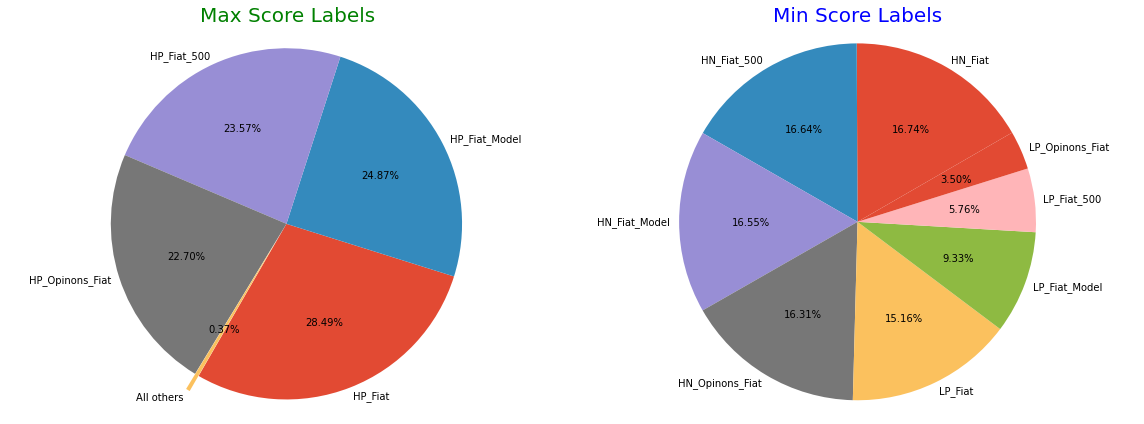

In [147]:
# plotting the pie chart 
# Configure subplots row=1, col=2, and size: width = 16 ,height = 6
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(16,6))

# plotting first pie in ax_1
newdic={}
for key, group in itertools.groupby(max_score_dict, lambda k: 'All others' if (max_score_dict[k]<50) else k):
     newdic[key] = sum([max_score_dict[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()


ax_1.pie(sizes, labels=labels, autopct='%0.2f%%', explode=(0,0,0,0,0.1), startangle=240,labeldistance=1.05)
ax_1.axis('equal')
ax_1.set_title("Max Score Labels",fontsize=20, color='g')
plt.tight_layout()
plt.title('Max Score Labels')


# plotting second pie in ax_2
newdic={}
for key, group in itertools.groupby(min_score_dict, lambda k: 'All others' if (min_score_dict[k]<50) else k):
     newdic[key] = sum([min_score_dict[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()


ax_2.pie(sizes, labels=labels, autopct='%0.2f%%', shadow=False, startangle=30,labeldistance=1.05)
ax_2.axis('equal')
ax_2.set_title("Min Score Labels", fontsize=20, color='b')
plt.tight_layout()


plt.show()

In [148]:
# viuslisation the engagement level over time
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

x=np.array(df_fiat_evo['label_2018'])
y_1=np.array(df_fiat_evo['freq_2018'])
y_2=np.array(df_fiat_evo['freq_2019'])
y_3=np.array(df_fiat_evo['freq_2020'])
y_4=np.array(df_fiat_evo['freq_2021'])
y_5=np.array(df_fiat_evo['freq_2022'])


fig = go.Figure()
#plotting the line graph
fig.add_trace(go.Scatter(x=x,y=y_1,mode='markers+lines',name='2018'))
fig.add_trace(go.Scatter(x=x,y=y_2,mode='markers+lines',name='2019'))
fig.add_trace(go.Scatter(x=x,y=y_3,mode='markers+lines',name='2020'))
fig.add_trace(go.Scatter(x=x,y=y_4,mode='markers+lines',name='2021'))
fig.add_trace(go.Scatter(x=x,y=y_5,mode='markers+lines',name='2022'))

fig.update_traces(marker=dict(size=14,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="Engagement Across The Years",
    xaxis_title='Sentiments',
    yaxis_title='Frequency'
)

fig.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### Semanitc Relationship

In [149]:
# convert it into text
text_4 = df_fiat['Fiat_500']
text_4

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0        its turn into a fiat500 tweet see load of bird...
1        please explain to this fiat 500 tweet the poin...
2                   what in the fiat 500 be a little moon?
3        blimey, get well soon chap, i think fiat's be ...
4        as if that be not much..... tallis, gibbons, p...
                               ...                        
17376    not to sound all fiat 500 but i be crave chine...
17377                       wtf be u send me fiat 500s for
17378    i just find a mobile, mainchain hot wallet w. ...
17379                 im in a fabulous white fiat 500 now.
17380    wdym lool they be all sick cars. classic beetl...
Name: Fiat_500, Length: 17381, dtype: object

In [150]:
#creating the tokens - 2mins
import spacy
nlp = spacy.load('en_core_web_lg')

# tokenised the text 
docs_tkns_4 = []
for docs in text_4:
    tmp = [
        token.lemma_
        for token in nlp(docs)
        if (not token.is_stop) & (not token.is_punct) & (not token.like_num) & (not token.is_currency) & (not token.pos_ == "PROPN")
        ]
    docs_tkns_4.append(tmp)
    del tmp

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [151]:
# getting the bigram anf trigram out 
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    docs_tkns_4,
    # min_count=50,
    threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[docs_tkns_4],
    # min_count=50,
    # threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
docs_phrased_4 = [bigram[line] for line in docs_tkns_4]
#docs_phrased = [trigram[bigram[line]] for line in comment_tkns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [152]:
# importing packages 
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [153]:
sentences = docs_phrased_4

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [154]:
# building word2veco model 
cores = multiprocessing.cpu_count()
# building the model 
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [155]:
# building the vocab 
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:04:50: collecting all words and their counts
INFO - 13:04:50: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:04:50: PROGRESS: at sentence #10000, processed 82343 words, keeping 10988 word types
INFO - 13:04:50: collected 14514 word types from a corpus of 142338 raw words and 17381 sentences
INFO - 13:04:50: Loading a fresh vocabulary
INFO - 13:04:50: effective_min_count=20 retains 1300 unique words (8% of original 14514, drops 13214)
INFO - 13:04:50: effective_min_count=20 leaves 102329 word corpus (71% of original 142338, drops 40009)
INFO - 13:04:50: deleting the raw counts dictionary of 14514

Time to build vocab: 0.01 mins


In [156]:
# training the model
t = time()

model = w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:04:50: training model with 7 workers on 1300 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:04:50: worker thread finished; awaiting finish of 6 more threads
INFO - 13:04:50: worker thread finished; awaiting finish of 5 more threads
INFO - 13:04:50: worker thread finished; awaiting finish of 4 more threads
INFO - 13:04:50: worker thread finished; awaiting finish of 3 more threads
INFO - 13:04:50: worker thread finished; awaiting finish of 2 more threads
INFO - 13:04:50: worker thread finished; awaiting finish of 1 more threads
INFO - 13:04:50: worker thread finished; awaiting finish 

Time to train the model: 0.06 mins


In [157]:
# creating the the plot 
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=127, perplexity=20).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(40, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 50,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(20)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:04:54: precomputing L2-norms of word weight vectors
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



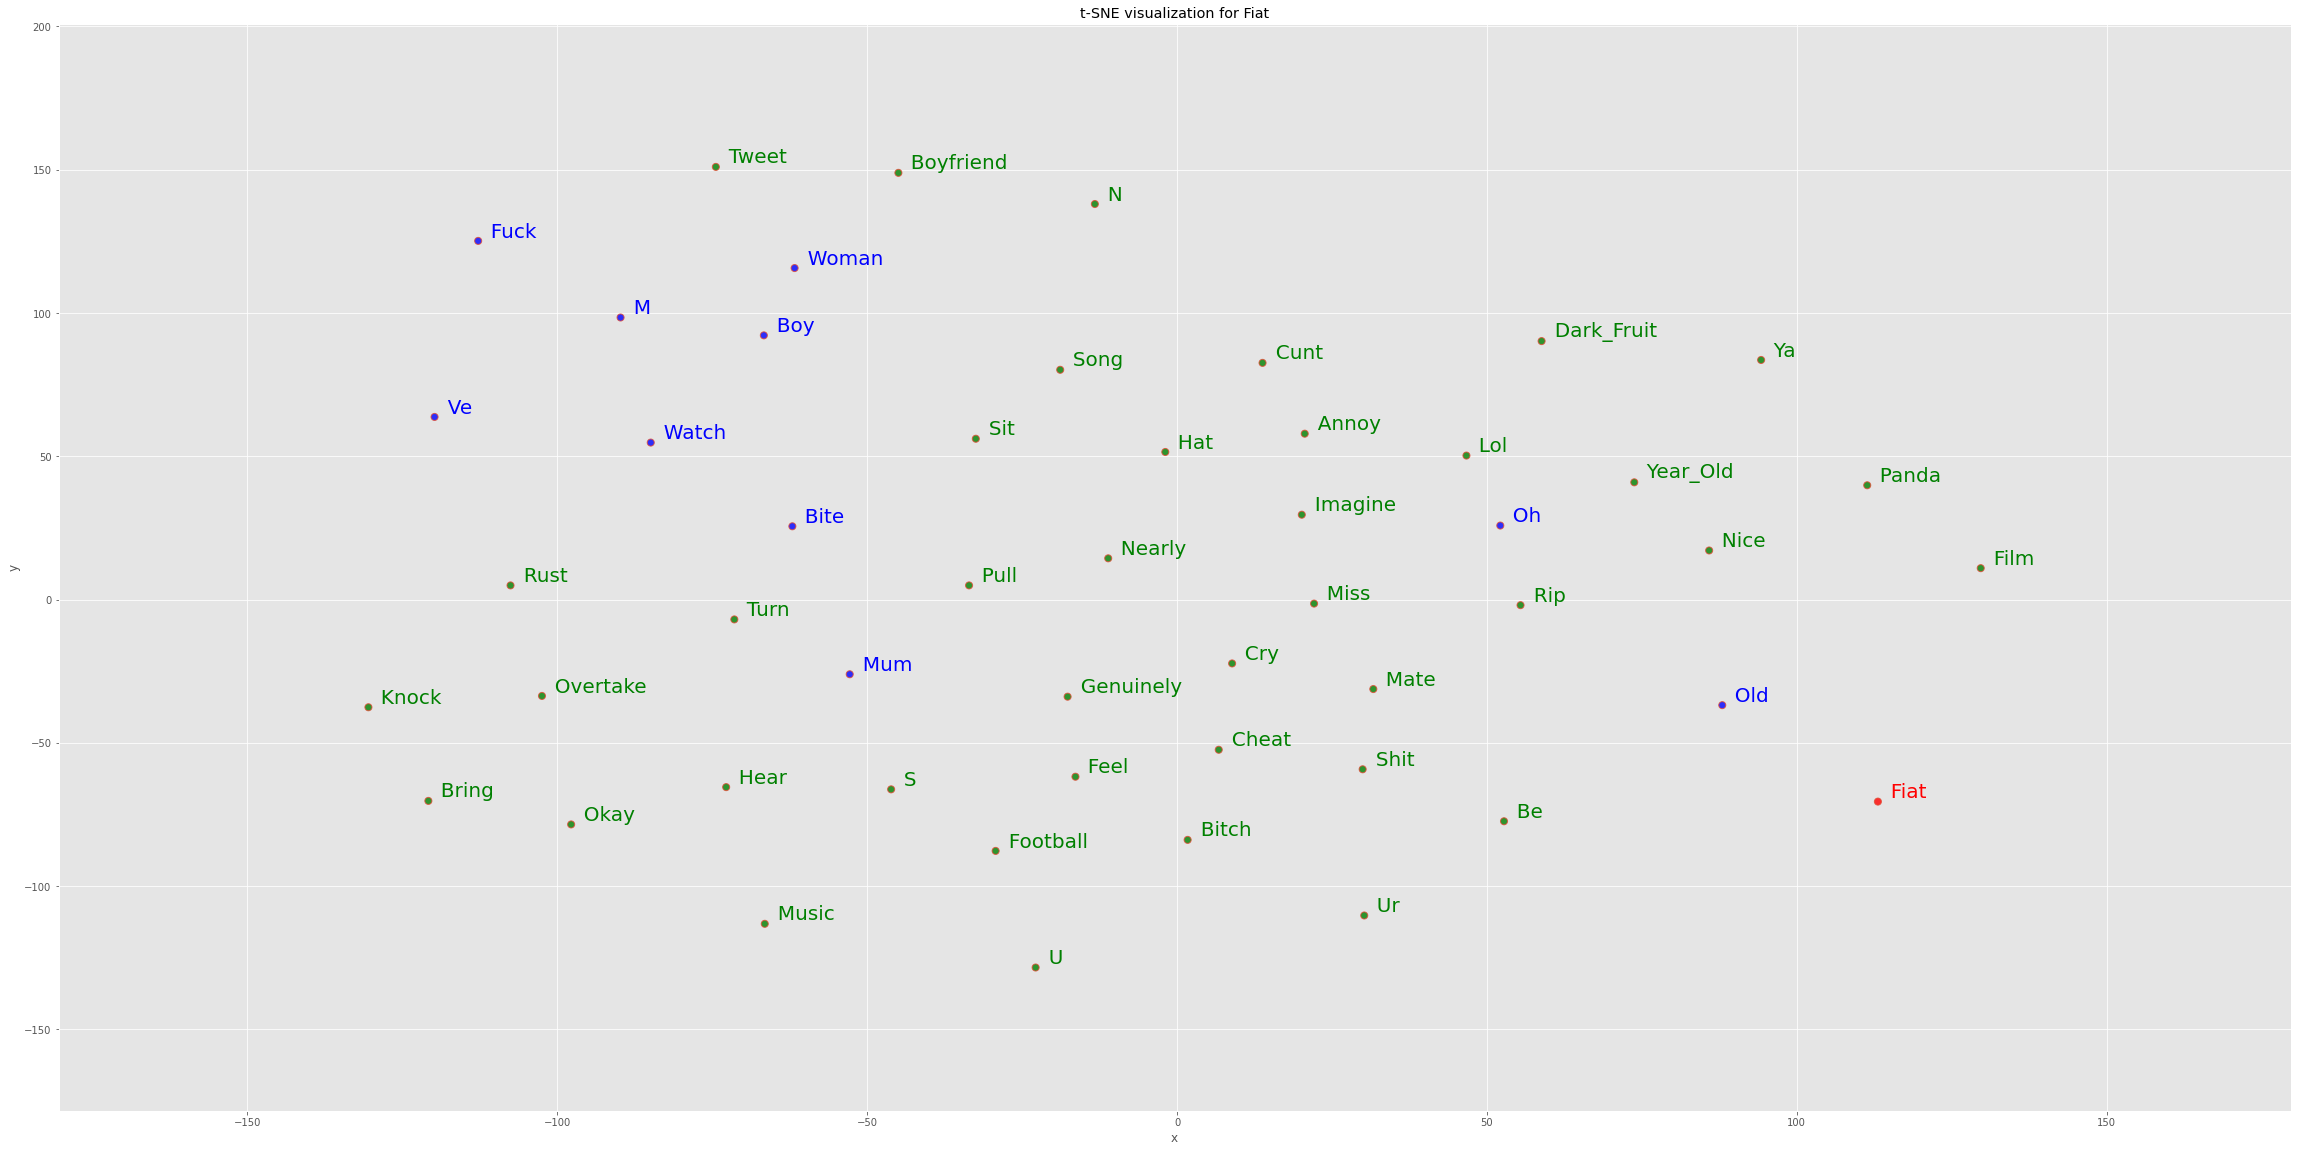

In [158]:
#creating the scatterplot 
tsnescatterplot(w2v_model, 'fiat', [t[0] for t in w2v_model.wv.most_similar(positive=["fiat"], topn=50)][10:])

### EV and Substainbilty

In [159]:
substainbilty = df_retain[['Fiat_EV','Feelings_EV','EV','FiatBrands_Green']]
substainbilty

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_EV  \
0      ebay, come as a kit with the adaptor cable and...   
1      theoretically the gold supply in the universe ...   
2                               fiat 500 tweet this mate   
3      at least we have power, unlike texas and calif...   
4      from 15-26 june we be host our fiat electric e...   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377             clients beautifully restore fiat 500 .   
17378       you have / you would deffo b a fiat 500 girl   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                             Feelings_EV  \
0      any pictures? i think this one picture have th...   
1                    nice to see fiat not screw up a fl!   
2                                a fiat worse than death   
3      never ever have a polish hazelnut vodka hangov...   
4      your ride be a fiat panda, my ride be a wild s...   
...                                                  ...   
17376  this tweet just demonstrate an ignorance of ho...   
17377  i agree!!! my little frankie fiat be lovely......   
17378  i may be wrong but most car journey be less th...   
17379  what a trader? money people? gold good or serv...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                      EV  \
0      what i really want be a zaz dana - but as pure...   
1      if i'm force to drive an electric car then i'm...   
2      and then the government be go to buy us all el...   
3      i miss the fiat. shame the car do not miss you...   
4             drive a fiat 500 for for grom today. a new   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377  find the culprits, they be find finger bash ea...   
17378  pretty poor service from your stevenage branch...   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                        FiatBrands_Green  
0      get back to me when they be rockin in on a pt ...  
1      we love the fiat cinquecento sport back in 199...  
2            2014 fiat 500s just 89 a month no deposit!!  
3      so for years we be tell to buy lead light bulb...  
4      apart from this weekend. unless you have get y...  
...                                                  ...  
17376  my deposit of fiat have fail and it have / it ...  
17377                                    bitcoin vs fiat  
17378       you have / you would deffo b a fiat 500 girl  
17379                           it get mark as very good  
17380  drive down duel carriageway do 65 on the outsi...  

[17381 rows x 4 columns]

In [160]:
# appendign the compund to the dataframe
col_list = list(substainbilty.columns)
col_list

for col_name in col_list:
# creating new names of columns 
    header_1 = str(col_name) + '_sent'
    header_2 = str(col_name) + '_comp'

# getting the sentiments
    sid = SIA()
    substainbilty[header_1] = substainbilty[col_name].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
    substainbilty[header_2]   = substainbilty[header_1].apply(lambda x: x['compound']+1*(10**-6))

substainbilty

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-160-f0e3a5764e22>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-160-f0e3a5764e22>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

Fiat_EV  \
0      ebay, come as a kit with the adaptor cable and...   
1      theoretically the gold supply in the universe ...   
2                               fiat 500 tweet this mate   
3      at least we have power, unlike texas and calif...   
4      from 15-26 june we be host our fiat electric e...   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377             clients beautifully restore fiat 500 .   
17378       you have / you would deffo b a fiat 500 girl   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                             Feelings_EV  \
0      any pictures? i think this one picture have th...   
1                    nice to see fiat not screw up a fl!   
2                                a fiat worse than death   
3      never ever have a polish hazelnut vodka hangov...   
4      your ride be a fiat panda, my ride be a wild s...   
...                                                  ...   
17376  this tweet just demonstrate an ignorance of ho...   
17377  i agree!!! my little frankie fiat be lovely......   
17378  i may be wrong but most car journey be less th...   
17379  what a trader? money people? gold good or serv...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                      EV  \
0      what i really want be a zaz dana - but as pure...   
1      if i'm force to drive an electric car then i'm...   
2      and then the government be go to buy us all el...   
3      i miss the fiat. shame the car do not miss you...   
4             drive a fiat 500 for for grom today. a new   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377  find the culprits, they be find finger bash ea...   
17378  pretty poor service from your stevenage branch...   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                        FiatBrands_Green  \
0      get back to me when they be rockin in on a pt ...   
1      we love the fiat cinquecento sport back in 199...   
2            2014 fiat 500s just 89 a month no deposit!!   
3      so for years we be tell to buy lead light bulb...   
4      apart from this weekend. unless you have get y...   
...                                                  ...   
17376  my deposit of fiat have fail and it have / it ...   
17377                                    bitcoin vs fiat   
17378       you have / you would deffo b a fiat 500 girl   
17379                           it get mark as very good   
17380  drive down duel carriageway do 65 on the outsi...   

                                            Fiat_EV_sent  Fiat_EV_comp  \
0      {'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...      0.329101   
1      {'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'comp...     -0.318199   
2      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...      0.000001   
3      {'neg': 0.079, 'neu': 0.843, 'pos': 0.079, 'co...     -0.249999   
4      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...      0.000001   
...                                                  ...           ...   
17376  {'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'comp...      0.743001   
17377  {'neg': 0.0, 'neu': 0.337, 'pos': 0.663, 'comp...      0.709601   
17378  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...      0.000001   
17379  {'neg': 0.0, 'neu': 0.931, 'pos': 0.069, 'comp...      0.492701   
17380  {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...      0.202301   

                                        Feelings_EV_sent  Feelings_EV_comp  \
0      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...          0.000001   
1      {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...          0.476001   
2      {'neg': 0.778, 'neu': 0.222, 'pos':

In [161]:
# getting the compound and sentiments labels
df_substainbilty = substainbilty.copy(deep=True)
df_substainbilty = df_substainbilty[['Fiat_EV', 'Feelings_EV', 'EV', 'FiatBrands_Green',
       'Fiat_EV_comp', 'Feelings_EV_comp',
       'EV_comp', 'FiatBrands_Green_comp']]
df_substainbilty

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_EV  \
0      ebay, come as a kit with the adaptor cable and...   
1      theoretically the gold supply in the universe ...   
2                               fiat 500 tweet this mate   
3      at least we have power, unlike texas and calif...   
4      from 15-26 june we be host our fiat electric e...   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377             clients beautifully restore fiat 500 .   
17378       you have / you would deffo b a fiat 500 girl   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                             Feelings_EV  \
0      any pictures? i think this one picture have th...   
1                    nice to see fiat not screw up a fl!   
2                                a fiat worse than death   
3      never ever have a polish hazelnut vodka hangov...   
4      your ride be a fiat panda, my ride be a wild s...   
...                                                  ...   
17376  this tweet just demonstrate an ignorance of ho...   
17377  i agree!!! my little frankie fiat be lovely......   
17378  i may be wrong but most car journey be less th...   
17379  what a trader? money people? gold good or serv...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                      EV  \
0      what i really want be a zaz dana - but as pure...   
1      if i'm force to drive an electric car then i'm...   
2      and then the government be go to buy us all el...   
3      i miss the fiat. shame the car do not miss you...   
4             drive a fiat 500 for for grom today. a new   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377  find the culprits, they be find finger bash ea...   
17378  pretty poor service from your stevenage branch...   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                        FiatBrands_Green  Fiat_EV_comp  \
0      get back to me when they be rockin in on a pt ...      0.329101   
1      we love the fiat cinquecento sport back in 199...     -0.318199   
2            2014 fiat 500s just 89 a month no deposit!!      0.000001   
3      so for years we be tell to buy lead light bulb...     -0.249999   
4      apart from this weekend. unless you have get y...      0.000001   
...                                                  ...           ...   
17376  my deposit of fiat have fail and it have / it ...      0.743001   
17377                                    bitcoin vs fiat      0.709601   
17378       you have / you would deffo b a fiat 500 girl      0.000001   
17379                           it get mark as very good      0.492701   
17380  drive down duel carriageway do 65 on the outsi...      0.202301   

       Feelings_EV_comp   EV_comp  FiatBrands_Green_comp  
0              0.000001  0.819901               0.000001  
1              0.476001  0.000001               0.855501  
2             -0.790599 -0.766499              -0.295999  
3             -0.402299 -0.648599               0.750601  
4              0.000001  0.000001               0.000001  
...                 ...       ...                    ...  
17376         -0.361199  0.743001              -0.690799  
17377          0.743001  0.000001               0.000001  
17378         -0.261699 -0.542299               0.000001  
17379          0.875001  0.492701               0.492701  
17380         -0.140599  0.202301              -0.318199  

[17381 rows x 8 columns]

In [162]:
# getting the minimum and max scores
# getting the topic labels 
df_substainbilty[['max_score_topic']]= pd.DataFrame(df_substainbilty[['Fiat_EV_comp','Feelings_EV_comp', 'EV_comp', 'FiatBrands_Green_comp']].apply(np.argmax,axis=1))
df_substainbilty[['min_score_topic']]= pd.DataFrame(df_substainbilty[['Fiat_EV_comp','Feelings_EV_comp', 'EV_comp', 'FiatBrands_Green_comp']].apply(np.argmin,axis=1))

# getting the topic sentiments
df_substainbilty[['max_score']]= pd.DataFrame(df_substainbilty[['Fiat_EV_comp','Feelings_EV_comp', 'EV_comp', 'FiatBrands_Green_comp']].apply(max,axis=1))
df_substainbilty[['min_score']]= pd.DataFrame(df_substainbilty[['Fiat_EV_comp','Feelings_EV_comp', 'EV_comp', 'FiatBrands_Green_comp']].apply(min,axis=1))

# getting the labels
df_substainbilty['max_score_topic']=df_substainbilty['max_score_topic'].apply(lambda x: "Fiat_EV" if x==0 else "Feelings_EV" if x==1 else "EV" if x==2 else "FiatBrands_Green")
df_substainbilty['min_score_topic']=df_substainbilty['min_score_topic'].apply(lambda x: "Fiat_EV" if x==0 else "Feelings_EV" if x==1 else "EV" if x==2 else "FiatBrands_Green")
df_substainbilty

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_EV  \
0      ebay, come as a kit with the adaptor cable and...   
1      theoretically the gold supply in the universe ...   
2                               fiat 500 tweet this mate   
3      at least we have power, unlike texas and calif...   
4      from 15-26 june we be host our fiat electric e...   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377             clients beautifully restore fiat 500 .   
17378       you have / you would deffo b a fiat 500 girl   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                             Feelings_EV  \
0      any pictures? i think this one picture have th...   
1                    nice to see fiat not screw up a fl!   
2                                a fiat worse than death   
3      never ever have a polish hazelnut vodka hangov...   
4      your ride be a fiat panda, my ride be a wild s...   
...                                                  ...   
17376  this tweet just demonstrate an ignorance of ho...   
17377  i agree!!! my little frankie fiat be lovely......   
17378  i may be wrong but most car journey be less th...   
17379  what a trader? money people? gold good or serv...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                      EV  \
0      what i really want be a zaz dana - but as pure...   
1      if i'm force to drive an electric car then i'm...   
2      and then the government be go to buy us all el...   
3      i miss the fiat. shame the car do not miss you...   
4             drive a fiat 500 for for grom today. a new   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377  find the culprits, they be find finger bash ea...   
17378  pretty poor service from your stevenage branch...   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                        FiatBrands_Green  Fiat_EV_comp  \
0      get back to me when they be rockin in on a pt ...      0.329101   
1      we love the fiat cinquecento sport back in 199...     -0.318199   
2            2014 fiat 500s just 89 a month no deposit!!      0.000001   
3      so for years we be tell to buy lead light bulb...     -0.249999   
4      apart from this weekend. unless you have get y...      0.000001   
...                                                  ...           ...   
17376  my deposit of fiat have fail and it have / it ...      0.743001   
17377                                    bitcoin vs fiat      0.709601   
17378       you have / you would deffo b a fiat 500 girl      0.000001   
17379                           it get mark as very good      0.492701   
17380  drive down duel carriageway do 65 on the outsi...      0.202301   

       Feelings_EV_comp   EV_comp  FiatBrands_Green_comp   max_score_topic  \
0              0.000001  0.819901               0.000001                EV   
1              0.476001  0.000001               0.855501  FiatBrands_Green   
2             -0.790599 -0.766499              -0.295999           Fiat_EV   
3             -0.402299 -0.648599               0.750601  FiatBrands_Green   
4              0.000001  0.000001               0.000001           Fiat_EV   
...                 ...       ...                    ...               ...   
17376         -0.361199  0.743001              -0.690799           Fiat_EV   
17377          0.743001  0.000001               0.000001       Feelings_EV   
17378         -0.261699 -0.542299               0.000001           Fiat_EV   
17379          0.875001  0.492701               0.492701       Feelings_EV   
17380         -0.140599  0.202301              -0.318199           Fiat_EV   

        min_score_topic  max_score  min_score  
0           

In [163]:
# creating an empty columns
df_substainbilty['Max_Score_Label'] = ''
df_substainbilty['Min_Score_Label'] = ''

# getting th postives and negatives sentiments 
i=0
for i in range(len(df_substainbilty)):
    if df_substainbilty.iloc[i:i+1,10:11].values[0] >= 0:
        df_substainbilty.iloc[i:i+1,12:13] = 'HP_'+ df_substainbilty.iloc[i:i+1,8:9].values[0]
    else:
       df_substainbilty.iloc[i:i+1,12:13] = 'LN_'+ df_substainbilty.iloc[i:i+1,8:9].values[0]

    if df_substainbilty.iloc[i:i+1,11:12].values[0] >= 0:
        df_substainbilty.iloc[i:i+1,13:14] = 'LP_'+ df_substainbilty.iloc[i:i+1,9:10].values[0]
    else:
       df_substainbilty.iloc[i:i+1,13:14] = 'HN_'+ df_substainbilty.iloc[i:i+1,9:10].values[0]
    
i+=1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [164]:
# converting it into a dataframe
df_substainbilty = pd.concat([years,df_substainbilty],ignore_index=True,sort=False,axis=1)
df_substainbilty = df_substainbilty.rename(columns={0:'date', 1:'Fiat_EV', 2:'Feelings_EV', 3:'EV', 4:'FiatBrands_Green', 5:'Fiat_EV_comp',
       6:'Feelings_EV_comp', 7:'EV_comp', 8:'FiatBrands_Green_comp', 9:'max_score_topic', 10:'min_score_topic', 11:'max_score', 12:'min_score',
       13:'Max_Score_Label', 14:'Min_Score_Label'})

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [165]:
# extracting the years only 
df_substainbilty['year']=df_substainbilty['date'].dt.year.astype(int)
# dropping NaN's
df_substainbilty = df_substainbilty.dropna()
df_substainbilty

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            Fiat_EV  \
0     2022-06-13  ebay, come as a kit with the adaptor cable and...   
1     2022-06-13  theoretically the gold supply in the universe ...   
2     2022-06-12                           fiat 500 tweet this mate   
3     2022-06-12  at least we have power, unlike texas and calif...   
4     2022-06-12  from 15-26 june we be host our fiat electric e...   
...          ...                                                ...   
17376 2018-01-22  i agree!!! my little frankie fiat be lovely......   
17377 2018-01-22             clients beautifully restore fiat 500 .   
17378 2018-01-22       you have / you would deffo b a fiat 500 girl   
17379 2018-01-22  i just find a mobile, mainchain hot wallet w. ...   
17380 2018-01-22  couldnt you have at least fill that fine new f...   

                                             Feelings_EV  \
0      any pictures? i think this one picture have th...   
1                    nice to see fiat not screw up a fl!   
2                                a fiat worse than death   
3      never ever have a polish hazelnut vodka hangov...   
4      your ride be a fiat panda, my ride be a wild s...   
...                                                  ...   
17376  this tweet just demonstrate an ignorance of ho...   
17377  i agree!!! my little frankie fiat be lovely......   
17378  i may be wrong but most car journey be less th...   
17379  what a trader? money people? gold good or serv...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                      EV  \
0      what i really want be a zaz dana - but as pure...   
1      if i'm force to drive an electric car then i'm...   
2      and then the government be go to buy us all el...   
3      i miss the fiat. shame the car do not miss you...   
4             drive a fiat 500 for for grom today. a new   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377  find the culprits, they be find finger bash ea...   
17378  pretty poor service from your stevenage branch...   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                        FiatBrands_Green  Fiat_EV_comp  \
0      get back to me when they be rockin in on a pt ...      0.329101   
1      we love the fiat cinquecento sport back in 199...     -0.318199   
2            2014 fiat 500s just 89 a month no deposit!!      0.000001   
3      so for years we be tell to buy lead light bulb...     -0.249999   
4      apart from this weekend. unless you have get y...      0.000001   
...                                                  ...           ...   
17376  my deposit of fiat have fail and it have / it ...      0.743001   
17377                                    bitcoin vs fiat      0.709601   
17378       you have / you would deffo b a fiat 500 girl      0.000001   
17379                           it get mark as very good      0.492701   
17380  drive down duel carriageway do 65 on the outsi...      0.202301   

       Feelings_EV_comp   EV_comp  FiatBrands_Green_comp   max_score_topic  \
0              0.000001  0.819901               0.000001                EV   
1              0.476001  0.000001               0.855501  FiatBrands_Green   
2             -0.790599 -0.766499              -0.295999           Fiat_EV   
3             -0.402299 -0.648599               0.750601  FiatBrands_Green   
4              0.000001  0.000001               0.000001           Fiat_EV   
...                 ...       ...                    ...               ...   
17376         -0.361199  0.743001              -0.690799           Fiat_EV   
17377          0.743001  0.000001               0.000001       Feelings_EV   
17378         -0.261699 -0.542299               0.000001           Fiat_EV   
17379          0.875001  0.492701               

In [166]:
df_substainbilty_year = df_substainbilty.copy()
df_substainbilty_year

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            Fiat_EV  \
0     2022-06-13  ebay, come as a kit with the adaptor cable and...   
1     2022-06-13  theoretically the gold supply in the universe ...   
2     2022-06-12                           fiat 500 tweet this mate   
3     2022-06-12  at least we have power, unlike texas and calif...   
4     2022-06-12  from 15-26 june we be host our fiat electric e...   
...          ...                                                ...   
17376 2018-01-22  i agree!!! my little frankie fiat be lovely......   
17377 2018-01-22             clients beautifully restore fiat 500 .   
17378 2018-01-22       you have / you would deffo b a fiat 500 girl   
17379 2018-01-22  i just find a mobile, mainchain hot wallet w. ...   
17380 2018-01-22  couldnt you have at least fill that fine new f...   

                                             Feelings_EV  \
0      any pictures? i think this one picture have th...   
1                    nice to see fiat not screw up a fl!   
2                                a fiat worse than death   
3      never ever have a polish hazelnut vodka hangov...   
4      your ride be a fiat panda, my ride be a wild s...   
...                                                  ...   
17376  this tweet just demonstrate an ignorance of ho...   
17377  i agree!!! my little frankie fiat be lovely......   
17378  i may be wrong but most car journey be less th...   
17379  what a trader? money people? gold good or serv...   
17380  wdym lool they be all sick cars. classic beetl...   

                                                      EV  \
0      what i really want be a zaz dana - but as pure...   
1      if i'm force to drive an electric car then i'm...   
2      and then the government be go to buy us all el...   
3      i miss the fiat. shame the car do not miss you...   
4             drive a fiat 500 for for grom today. a new   
...                                                  ...   
17376  i agree!!! my little frankie fiat be lovely......   
17377  find the culprits, they be find finger bash ea...   
17378  pretty poor service from your stevenage branch...   
17379  i just find a mobile, mainchain hot wallet w. ...   
17380  couldnt you have at least fill that fine new f...   

                                        FiatBrands_Green  Fiat_EV_comp  \
0      get back to me when they be rockin in on a pt ...      0.329101   
1      we love the fiat cinquecento sport back in 199...     -0.318199   
2            2014 fiat 500s just 89 a month no deposit!!      0.000001   
3      so for years we be tell to buy lead light bulb...     -0.249999   
4      apart from this weekend. unless you have get y...      0.000001   
...                                                  ...           ...   
17376  my deposit of fiat have fail and it have / it ...      0.743001   
17377                                    bitcoin vs fiat      0.709601   
17378       you have / you would deffo b a fiat 500 girl      0.000001   
17379                           it get mark as very good      0.492701   
17380  drive down duel carriageway do 65 on the outsi...      0.202301   

       Feelings_EV_comp   EV_comp  FiatBrands_Green_comp   max_score_topic  \
0              0.000001  0.819901               0.000001                EV   
1              0.476001  0.000001               0.855501  FiatBrands_Green   
2             -0.790599 -0.766499              -0.295999           Fiat_EV   
3             -0.402299 -0.648599               0.750601  FiatBrands_Green   
4              0.000001  0.000001               0.000001           Fiat_EV   
...                 ...       ...                    ...               ...   
17376         -0.361199  0.743001              -0.690799           Fiat_EV   
17377          0.743001  0.000001               0.000001       Feelings_EV   
17378         -0.261699 -0.542299               0.000001           Fiat_EV   
17379          0.875001  0.492701               

In [167]:
# producing a pearson correlations
pear_corr_2 = df_substainbilty_year[['Fiat_EV_comp', 'Feelings_EV_comp', 'EV_comp', 'FiatBrands_Green_comp']].corr(method='pearson')
pear_corr_2

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_EV_comp  Feelings_EV_comp   EV_comp  \
Fiat_EV_comp               1.000000         -0.001406 -0.005947   
Feelings_EV_comp          -0.001406          1.000000 -0.004984   
EV_comp                   -0.005947         -0.004984  1.000000   
FiatBrands_Green_comp      0.009198         -0.007327  0.007441   

                       FiatBrands_Green_comp  
Fiat_EV_comp                        0.009198  
Feelings_EV_comp                   -0.007327  
EV_comp                             0.007441  
FiatBrands_Green_comp               1.000000

In [168]:
# visalise the heatmap 
import plotly.express as px
fig_6 = px.imshow(pear_corr_2.corr(), text_auto=True, aspect="auto")
fig_6.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [169]:
# query by years
# 2018 
df_substainbilty_2018 = df_substainbilty_year.query("year == 2018")
df_substainbilty_2018 = df_substainbilty_2018.reset_index(drop=True)
df_substainbilty_2018

#2019
df_substainbilty_2019 = df_substainbilty_year.query("year == 2019")
df_substainbilty_2019 = df_substainbilty_2019.reset_index(drop=True)
df_substainbilty_2019

#2020
df_substainbilty_2020= df_substainbilty_year.query("year == 2020")
df_substainbilty_2020 = df_substainbilty_2020.reset_index(drop=True)
df_substainbilty_2020

#2021
df_substainbilty_2021 = df_substainbilty_year.query("year == 2021")
df_substainbilty_2021 = df_substainbilty_2021.reset_index(drop=True)
df_substainbilty_2021

#2022
df_substainbilty_2022 = df_substainbilty_year.query("year == 2022")
df_substainbilty_2022 = df_substainbilty_2022.reset_index(drop=True)
df_substainbilty_2022

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            Fiat_EV  \
0    2022-06-13  ebay, come as a kit with the adaptor cable and...   
1    2022-06-13  theoretically the gold supply in the universe ...   
2    2022-06-12                           fiat 500 tweet this mate   
3    2022-06-12  at least we have power, unlike texas and calif...   
4    2022-06-12  from 15-26 june we be host our fiat electric e...   
...         ...                                                ...   
1925 2022-01-01  morning folks. if you know whyteleafe hill, yo...   
1926 2022-01-01                   fiat 500 twitter: the beginning.   
1927 2022-01-01                                     600d 1967 2017   
1928 2022-01-01                                                      
1929 2022-01-01  just drive past this fiat with a pink chrome f...   

                                            Feelings_EV  \
0     any pictures? i think this one picture have th...   
1                   nice to see fiat not screw up a fl!   
2                               a fiat worse than death   
3     never ever have a polish hazelnut vodka hangov...   
4     your ride be a fiat panda, my ride be a wild s...   
...                                                 ...   
1925  everyone say theyve have a shit year, bet you ...   
1926                                    match fiat 500s   
1927    wait until they find out the fuckery about fiat   
1928        new car, the excellent never let us me down   
1929  (when type this out, autocorrect turn hnoss in...   

                                                     EV  \
0     what i really want be a zaz dana - but as pure...   
1     if i'm force to drive an electric car then i'm...   
2     and then the government be go to buy us all el...   
3     i miss the fiat. shame the car do not miss you...   
4            drive a fiat 500 for for grom today. a new   
...                                                 ...   
1925  that fiat next to you need to learn how to par...   
1926  blast from the past, the fiat panda italia 90....   
1927  it just cost me 50 to fill up my car! fifty po...   
1928  you spend money to make money. if you dont hav...   
1929  cos the fiat 500 be outside and it have / it b...   

                                       FiatBrands_Green  Fiat_EV_comp  \
0     get back to me when they be rockin in on a pt ...      0.329101   
1     we love the fiat cinquecento sport back in 199...     -0.318199   
2           2014 fiat 500s just 89 a month no deposit!!      0.000001   
3     so for years we be tell to buy lead light bulb...     -0.249999   
4     apart from this weekend. unless you have get y...      0.000001   
...                                                 ...           ...   
1925  little fiat have a little help apply her blush...     -0.458799   
1926  dogecoin be not mean to be sell doge be to be ...      0.000001   
1927  there have to be an interest story about how t...      0.000001   
1928  i have a lancia delta integral hf for about 3 ...      0.000001   
1929  at the self-service at tesco and i hear "cappu...      0.636901   

      Feelings_EV_comp   EV_comp  FiatBrands_Green_comp   max_score_topic  \
0             0.000001  0.819901               0.000001                EV   
1             0.476001  0.000001               0.855501  FiatBrands_Green   
2            -0.790599 -0.766499              -0.295999           Fiat_EV   
3            -0.402299 -0.648599               0.750601  FiatBrands_Green   
4             0.000001  0.000001               0.000001           Fiat_EV   
...                ...       ...                    ...               ...   
1925         -0.713299  0.000001               0.341501  FiatBrands_Green   
1926          0.000001  0.000001              -0.440399           Fiat_EV   
1927          0.000001  0.000001               0.743001  FiatBrands_Green   
1928          0.571901  0.690801               0.542301                EV   
1929          0.636901  0.00

In [170]:
# getting the minimum and maxmimum frequency of 2018 
df_substainbilty_max_1 = pd.DataFrame(df_substainbilty_2018['Max_Score_Label'].value_counts())
df_substainbilty_min_1 = pd.DataFrame(df_substainbilty_2018['Min_Score_Label'].value_counts())
df_substainbilty_max_1= df_substainbilty_max_1.rename(columns={'Max_Score_Label':'label'})
df_substainbilty_min_1= df_substainbilty_min_1.rename(columns={'Min_Score_Label':'label'})
df_substainbilty_2018 =pd.concat([df_substainbilty_max_1,df_substainbilty_min_1],ignore_index=False,sort=False)
df_substainbilty_2018 = df_substainbilty_2018.reset_index()
df_substainbilty_2018.columns = ['Labels', 'Frequency']
df_substainbilty_2018

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0            HP_Fiat_EV       1408
1        HP_Feelings_EV       1283
2                 HP_EV       1214
3   HP_FiatBrands_Green       1145
4                 LN_EV          5
5        LN_Feelings_EV          5
6   LN_FiatBrands_Green          4
7            LN_Fiat_EV          3
8        HN_Feelings_EV        853
9            HN_Fiat_EV        838
10                HN_EV        819
11  HN_FiatBrands_Green        819
12           LP_Fiat_EV        763
13       LP_Feelings_EV        482
14                LP_EV        298
15  LP_FiatBrands_Green        195

In [171]:
# getting the minimum and maxmimum frequency of 2019
df_substainbilty_max_2 = pd.DataFrame(df_substainbilty_2019['Max_Score_Label'].value_counts())
df_substainbilty_min_2 = pd.DataFrame(df_substainbilty_2019['Min_Score_Label'].value_counts())
df_substainbilty_max_2= df_substainbilty_max_2.rename(columns={'Max_Score_Label':'label'})
df_substainbilty_min_2= df_substainbilty_min_2.rename(columns={'Min_Score_Label':'label'})
df_substainbilty_2019 =pd.concat([df_substainbilty_max_2,df_substainbilty_min_2],ignore_index=False,sort=False)
df_substainbilty_2019 = df_substainbilty_2019.reset_index()
df_substainbilty_2019.columns = ['Labels', 'Frequency']
df_substainbilty_2019

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0            HP_Fiat_EV       1192
1        HP_Feelings_EV       1059
2                 HP_EV       1007
3   HP_FiatBrands_Green        959
4                 LN_EV          4
5        LN_Feelings_EV          4
6            LN_Fiat_EV          3
7   LN_FiatBrands_Green          2
8            HN_Fiat_EV        729
9        HN_Feelings_EV        709
10                HN_EV        696
11  HN_FiatBrands_Green        690
12           LP_Fiat_EV        653
13       LP_Feelings_EV        361
14                LP_EV        235
15  LP_FiatBrands_Green        157

In [172]:
# getting the minimum and maxmimum frequency of 2020
df_substainbilty_max_3 = pd.DataFrame(df_substainbilty_2020['Max_Score_Label'].value_counts())
df_substainbilty_min_3 = pd.DataFrame(df_substainbilty_2020['Min_Score_Label'].value_counts())
df_substainbilty_max_3= df_substainbilty_max_3.rename(columns={'Max_Score_Label':'label'})
df_substainbilty_min_3= df_substainbilty_min_3.rename(columns={'Min_Score_Label':'label'})
df_substainbilty_2020 =pd.concat([df_substainbilty_max_3,df_substainbilty_min_3],ignore_index=False,sort=False)
df_substainbilty_2020 = df_substainbilty_2020.reset_index()
df_substainbilty_2020.columns = ['Labels', 'Frequency']
df_substainbilty_2020

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0            HP_Fiat_EV       1036
1        HP_Feelings_EV        859
2                 HP_EV        802
3   HP_FiatBrands_Green        779
4                 LN_EV          2
5        LN_Feelings_EV          2
6   LN_FiatBrands_Green          2
7            LN_Fiat_EV          1
8            HN_Fiat_EV        588
9        HN_Feelings_EV        584
10                HN_EV        573
11  HN_FiatBrands_Green        563
12           LP_Fiat_EV        550
13       LP_Feelings_EV        329
14                LP_EV        202
15  LP_FiatBrands_Green         94

In [173]:
# getting the minimum and maxmimum frequency of 2021 
df_substainbilty_max_4 = pd.DataFrame(df_substainbilty_2021['Max_Score_Label'].value_counts())
df_substainbilty_min_4 = pd.DataFrame(df_substainbilty_2021['Min_Score_Label'].value_counts())
df_substainbilty_max_4= df_substainbilty_max_4.rename(columns={'Max_Score_Label':'label'})
df_substainbilty_min_4= df_substainbilty_min_4.rename(columns={'Min_Score_Label':'label'})
df_substainbilty_2021 =pd.concat([df_substainbilty_max_4,df_substainbilty_min_4],ignore_index=False,sort=False)
df_substainbilty_2021 = df_substainbilty_2021.reset_index()
df_substainbilty_2021.columns = ['Labels', 'Frequency']
df_substainbilty_2021

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0            HP_Fiat_EV        762
1        HP_Feelings_EV        687
2                 HP_EV        635
3   HP_FiatBrands_Green        573
4        LN_Feelings_EV          6
5   LN_FiatBrands_Green          5
6            LN_Fiat_EV          2
7                 LN_EV          1
8            HN_Fiat_EV        472
9   HN_FiatBrands_Green        434
10                HN_EV        424
11       HN_Feelings_EV        414
12           LP_Fiat_EV        400
13       LP_Feelings_EV        244
14                LP_EV        170
15  LP_FiatBrands_Green        113

In [174]:
# getting the minimum and maxmimum frequency of 2022
df_substainbilty_max_5 = pd.DataFrame(df_substainbilty_2022['Max_Score_Label'].value_counts())
df_substainbilty_min_5 = pd.DataFrame(df_substainbilty_2022['Min_Score_Label'].value_counts())
df_substainbilty_max_5= df_substainbilty_max_5.rename(columns={'Max_Score_Label':'label'})
df_substainbilty_min_5= df_substainbilty_min_5.rename(columns={'Min_Score_Label':'label'})
df_substainbilty_2022 =pd.concat([df_substainbilty_max_5,df_substainbilty_min_5],ignore_index=False,sort=False)
df_substainbilty_2022 = df_substainbilty_2022.reset_index()
df_substainbilty_2022.columns = ['Labels', 'Frequency']
df_substainbilty_2022

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Labels  Frequency
0            HP_Fiat_EV        524
1        HP_Feelings_EV        505
2                 HP_EV        459
3   HP_FiatBrands_Green        438
4        LN_Feelings_EV          2
5            LN_Fiat_EV          2
6        HN_Feelings_EV        344
7                 HN_EV        329
8            LP_Fiat_EV        317
9            HN_Fiat_EV        310
10  HN_FiatBrands_Green        303
11       LP_Feelings_EV        166
12                LP_EV         95
13  LP_FiatBrands_Green         66

In [175]:
# combining all the years over time 
df_substainbilty_evo = pd.concat([df_substainbilty_2018,df_substainbilty_2019,df_substainbilty_2020,df_substainbilty_2021,df_substainbilty_2022],ignore_index=True,sort=False,axis=1)
df_substainbilty_evo = df_substainbilty_evo.rename(columns={0:'label_2018',1:'freq_2018',2:'label_2019',3:'freq_2019',4:'label_2020',5:'freq_2020',6:'label_2021',7:'freq_2021',8:'label_2022',9:'freq_2022'})
df_substainbilty_evo

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



label_2018  freq_2018           label_2019  freq_2019  \
0            HP_Fiat_EV       1408           HP_Fiat_EV       1192   
1        HP_Feelings_EV       1283       HP_Feelings_EV       1059   
2                 HP_EV       1214                HP_EV       1007   
3   HP_FiatBrands_Green       1145  HP_FiatBrands_Green        959   
4                 LN_EV          5                LN_EV          4   
5        LN_Feelings_EV          5       LN_Feelings_EV          4   
6   LN_FiatBrands_Green          4           LN_Fiat_EV          3   
7            LN_Fiat_EV          3  LN_FiatBrands_Green          2   
8        HN_Feelings_EV        853           HN_Fiat_EV        729   
9            HN_Fiat_EV        838       HN_Feelings_EV        709   
10                HN_EV        819                HN_EV        696   
11  HN_FiatBrands_Green        819  HN_FiatBrands_Green        690   
12           LP_Fiat_EV        763           LP_Fiat_EV        653   
13       LP_Feelings_EV        482       LP_Feelings_EV        361   
14                LP_EV        298                LP_EV        235   
15  LP_FiatBrands_Green        195  LP_FiatBrands_Green        157   

             label_2020  freq_2020           label_2021  freq_2021  \
0            HP_Fiat_EV       1036           HP_Fiat_EV        762   
1        HP_Feelings_EV        859       HP_Feelings_EV        687   
2                 HP_EV        802                HP_EV        635   
3   HP_FiatBrands_Green        779  HP_FiatBrands_Green        573   
4                 LN_EV          2       LN_Feelings_EV          6   
5        LN_Feelings_EV          2  LN_FiatBrands_Green          5   
6   LN_FiatBrands_Green          2           LN_Fiat_EV          2   
7            LN_Fiat_EV          1                LN_EV          1   
8            HN_Fiat_EV        588           HN_Fiat_EV        472   
9        HN_Feelings_EV        584  HN_FiatBrands_Green        434   
10                HN_EV        573                HN_EV        424   
11  HN_FiatBrands_Green        563       HN_Feelings_EV        414   
12           LP_Fiat_EV        550           LP_Fiat_EV        400   
13       LP_Feelings_EV        329       LP_Feelings_EV        244   
14                LP_EV        202                LP_EV        170   
15  LP_FiatBrands_Green         94  LP_FiatBrands_Green        113   

             label_2022  freq_2022  
0            HP_Fiat_EV      524.0  
1        HP_Feelings_EV      505.0  
2                 HP_EV      459.0  
3   HP_FiatBrands_Green      438.0  
4        LN_Feelings_EV        2.0  
5            LN_Fiat_EV        2.0  
6        HN_Feelings_EV      344.0  
7                 HN_EV      329.0  
8            LP_Fiat_EV      317.0  
9            HN_Fiat_EV      310.0  
10  HN_FiatBrands_Green      303.0  
11       LP_Feelings_EV      166.0  
12                LP_EV       95.0  
13  LP_FiatBrands_Green       66.0  
14                  NaN        NaN  
15                  NaN        NaN

In [176]:
# creating max score and min dictionary 
## making max score label dictionary
## Count unqiue values of "Max_Score_Label"
df_substainbilty_max_score=df_substainbilty['Max_Score_Label'].value_counts(ascending=False)

## Convert tuple to dataframe
df_substainbilty_max_score = pd.DataFrame(df_substainbilty_max_score)
df_substainbilty_max_score= df_substainbilty_max_score.reset_index()
df_substainbilty_max_score.columns = ['Max_Score_Label', 'Frequency'] # change column names

# convert dataframe to tuple dictionary
max_score_dict=df_substainbilty_max_score.set_index('Max_Score_Label')['Frequency'].to_dict() # max_score_dict


## making min score label dictionary

## Count unqiue values of "Min_Score_Label"
df_substainbilty_min_score=df_substainbilty['Min_Score_Label'].value_counts(ascending=False)

## Convert tuple to dataframe
df_substainbilty_min_score = pd.DataFrame(df_substainbilty_min_score)
df_substainbilty_min_score= df_substainbilty_min_score.reset_index()
df_substainbilty_min_score.columns = ['Min_Score_Label', 'Frequency'] # change column names

##convert dataframe to tuple dictionary
min_score_dict=df_substainbilty_min_score.set_index('Min_Score_Label')['Frequency'].to_dict()# min_score_dict

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



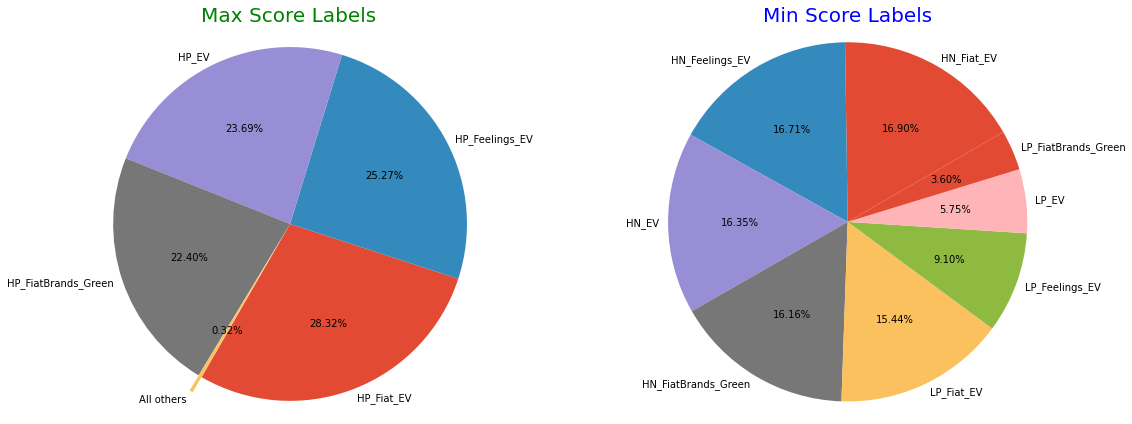

In [177]:
# insert pie chart 
# plotting the pie chart 
# Configure subplots row=1, col=2, and size: width = 16 ,height = 6
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(16,6))

# plotting first pie in ax_1
newdic={}
for key, group in itertools.groupby(max_score_dict, lambda k: 'All others' if (max_score_dict[k]<50) else k):
     newdic[key] = sum([max_score_dict[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()


ax_1.pie(sizes, labels=labels, autopct='%0.2f%%', explode=(0,0,0,0,0.1), startangle=240,labeldistance=1.05)
ax_1.axis('equal')
ax_1.set_title("Max Score Labels",fontsize=20, color='g')
plt.tight_layout()
plt.title('Max Score Labels')


# plotting second pie in ax_2
newdic={}
for key, group in itertools.groupby(min_score_dict, lambda k: 'All others' if (min_score_dict[k]<50) else k):
     newdic[key] = sum([min_score_dict[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()


ax_2.pie(sizes, labels=labels, autopct='%0.2f%%', shadow=False, startangle=30,labeldistance=1.05)
ax_2.axis('equal')
ax_2.set_title("Min Score Labels", fontsize=20, color='b')
plt.tight_layout()


plt.show()

In [178]:
# viuslisation the engagement level over time
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

x=np.array(df_substainbilty_evo['label_2018'])
y_1=np.array(df_substainbilty_evo['freq_2018'])
y_2=np.array(df_substainbilty_evo['freq_2019'])
y_3=np.array(df_substainbilty_evo['freq_2020'])
y_4=np.array(df_substainbilty_evo['freq_2021'])
y_5=np.array(df_substainbilty_evo['freq_2022'])


fig = go.Figure()
#plotting the line graph
fig.add_trace(go.Scatter(x=x,y=y_1,mode='markers+lines',name='2018'))
fig.add_trace(go.Scatter(x=x,y=y_2,mode='markers+lines',name='2019'))
fig.add_trace(go.Scatter(x=x,y=y_3,mode='markers+lines',name='2020'))
fig.add_trace(go.Scatter(x=x,y=y_4,mode='markers+lines',name='2021'))
fig.add_trace(go.Scatter(x=x,y=y_5,mode='markers+lines',name='2022'))

fig.update_traces(marker=dict(size=14,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="Engagement Across The Years",
    xaxis_title='Sentiments',
    yaxis_title='Frequency'
)

fig.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### Semantic Similarity

In [179]:
# convert it into text
text_3 = df_substainbilty_year['FiatBrands_Green']
text_3

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0        get back to me when they be rockin in on a pt ...
1        we love the fiat cinquecento sport back in 199...
2              2014 fiat 500s just 89 a month no deposit!!
3        so for years we be tell to buy lead light bulb...
4        apart from this weekend. unless you have get y...
                               ...                        
17376    my deposit of fiat have fail and it have / it ...
17377                                      bitcoin vs fiat
17378         you have / you would deffo b a fiat 500 girl
17379                             it get mark as very good
17380    drive down duel carriageway do 65 on the outsi...
Name: FiatBrands_Green, Length: 17381, dtype: object

In [180]:
# Setting up the loggings to monitor gensim
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [181]:
#creating the tokens - 2mins
import spacy
nlp = spacy.load('en_core_web_lg')

# tokenised the text 
docs_tkns_2 = []
for docs in text_3:
    tmp = [
        token.lemma_
        for token in nlp(docs)
        if (not token.is_stop) & (not token.is_punct) & (not token.like_num) & (not token.is_currency) & (not token.pos_ == "PROPN")
        ]
    docs_tkns_2.append(tmp)
    del tmp

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [182]:
# getting the bigram anf trigram out 
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    docs_tkns_2,
    # min_count=50,
    threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[docs_tkns_2],
    # min_count=50,
    # threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
docs_phrased_1 = [bigram[line] for line in docs_tkns_2]
#docs_phrased = [trigram[bigram[line]] for line in comment_tkns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:08:07: collecting all words and their counts
INFO - 13:08:07: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:08:08: PROGRESS: at sentence #10000, processed 86606 words and 72212 word types
INFO - 13:08:08: collected 113908 word types from a corpus of 149575 words (unigram + bigrams) and 17381 sentences
INFO - 13:08:08: using 113908 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>
INFO - 13:08:08: collecting all words and their counts
INFO - 13:08:08: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:08:08: PROGRESS: at sentence #10000, proces

In [183]:
sentences = docs_phrased_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [184]:
# building word2veco model 
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [185]:
# building the vocab 
from time import time 
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:08:10: collecting all words and their counts
INFO - 13:08:10: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:08:10: PROGRESS: at sentence #10000, processed 82491 words, keeping 11091 word types
INFO - 13:08:10: collected 14514 word types from a corpus of 142338 raw words and 17381 sentences
INFO - 13:08:10: Loading a fresh vocabulary
INFO - 13:08:10: effective_min_count=20 retains 1300 unique words (8% of original 14514, drops 13214)
INFO - 13:08:10: effective_min_count=20 leaves 102329 word corpus (71% of original 142338, drops 40009)
INFO - 13:08:10: deleting the raw counts dictionary of 14514

Time to build vocab: 0.01 mins


In [186]:
# training the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:08:10: training model with 7 workers on 1300 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:08:10: worker thread finished; awaiting finish of 6 more threads
INFO - 13:08:10: worker thread finished; awaiting finish of 5 more threads
INFO - 13:08:10: worker thread finished; awaiting finish of 4 more threads
INFO - 13:08:10: worker thread finished; awaiting finish of 3 more threads
INFO - 13:08:10: worker thread finished; awaiting finish of 2 more threads
INFO - 13:08:10: worker thread finished; awaiting finish of 1 more threads
INFO - 13:08:10: worker thread finished; awaiting finish 

Time to train the model: 0.04 mins


In [187]:
# getting the similarity score
w2v_model.wv.similarity("fiat", 'ev')

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.9853482

In [188]:
# creating the the plot 
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=20).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(40, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 50,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(20)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 13:08:13: precomputing L2-norms of word weight vectors
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



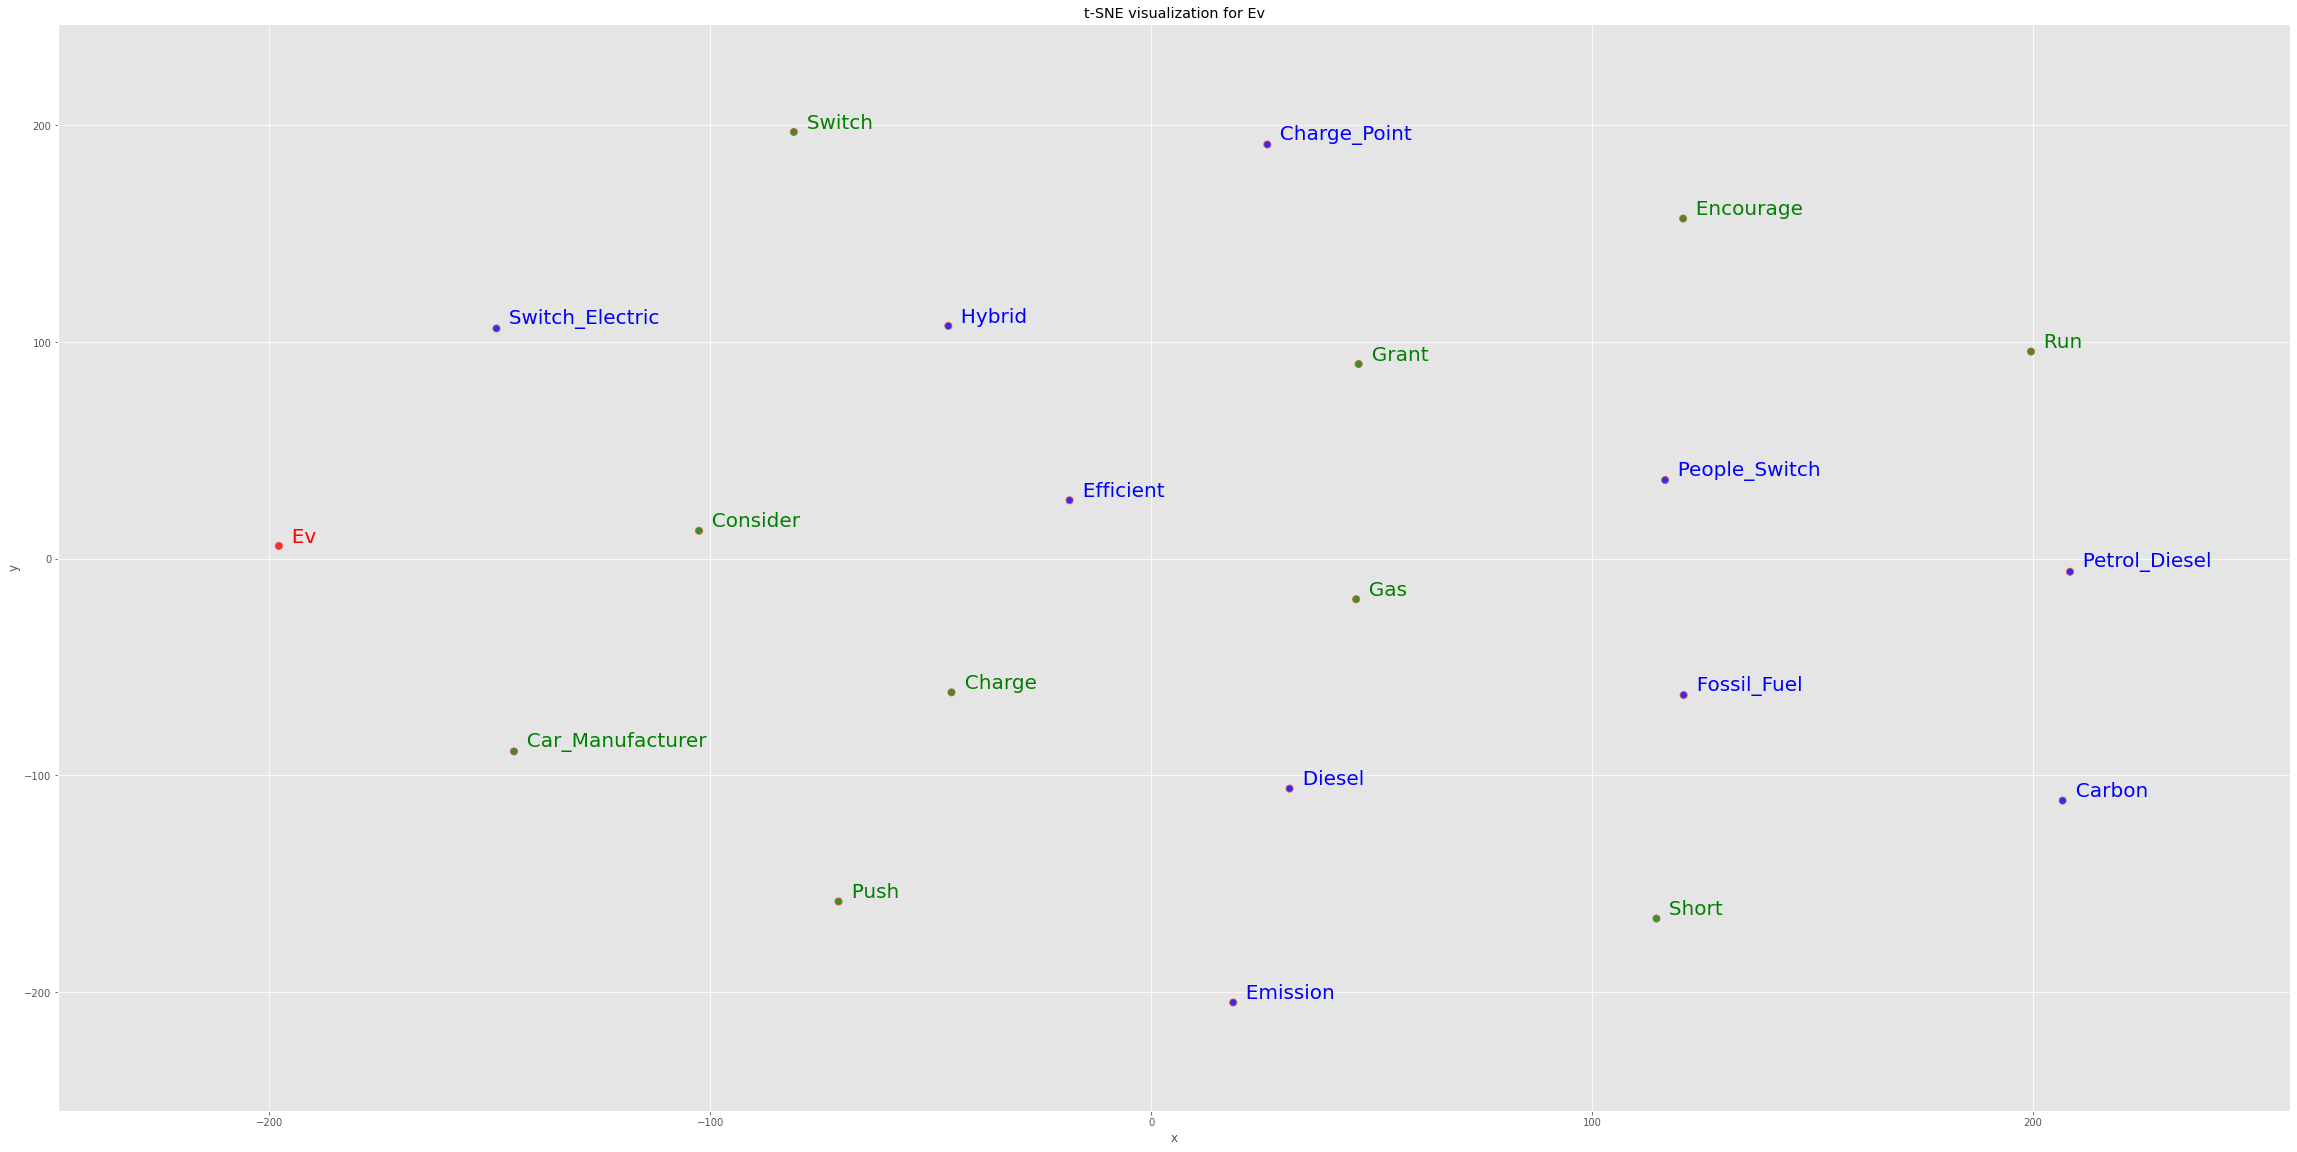

In [189]:
tsnescatterplot(w2v_model, "ev", [t[0] for t in w2v_model.wv.most_similar(positive=["ev"], topn=20)][10:])

### Car Dealers

In [326]:
# extracting the car dealers our only from df_retained 
# more options can be specified also
dealers = df_retain[['Dealers']]
dealers

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealers
0      superb customer service from richard at the ca...
1      i look through your idea on tax base money con...
2                      look like racist fiat 500 twitter
3      the car dealership have give me a courtesy car...
4      2020-2021 fiat, equity, property correction wi...
...                                                  ...
17376       you have / you would deffo b a fiat 500 girl
17377                           it get mark as very good
17378  i may be wrong but most car journey be less th...
17379  couldnt you have at least fill that fine new f...
17380  the 10th vehicle for our best customer, a 1 da...

[17381 rows x 1 columns]

In [327]:
# appending the years to the columns
df_dealers = pd.concat([years,dealers],ignore_index=False,sort=False,axis=1)

# drop for any NaN's
df_dealers = df_dealers.dropna()

# renaming the columns 
df_dealers = df_dealers.rename(columns = {'Dealers':'content'})

df_dealers

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content
0     2022-06-13  superb customer service from richard at the ca...
1     2022-06-13  i look through your idea on tax base money con...
2     2022-06-12                  look like racist fiat 500 twitter
3     2022-06-12  the car dealership have give me a courtesy car...
4     2022-06-12  2020-2021 fiat, equity, property correction wi...
...          ...                                                ...
17376 2018-01-22       you have / you would deffo b a fiat 500 girl
17377 2018-01-22                           it get mark as very good
17378 2018-01-22  i may be wrong but most car journey be less th...
17379 2018-01-22  couldnt you have at least fill that fine new f...
17380 2018-01-22  the 10th vehicle for our best customer, a 1 da...

[17381 rows x 2 columns]

#### Getting the sentiments out

In [328]:
# appendign the compund to the dataframe
col_list_1 = list(dealers.columns)
col_list_1

for col_name in col_list_1:
# creating new names of columns 
    header_1 = str(col_name) + '_sent'
    header_2 = str(col_name) + '_comp'

# getting the sentiments
    sid = SIA()
    dealers[header_1] = dealers[col_name].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
    dealers[header_2]   = dealers[header_1].apply(lambda x: x['compound']+1*(10**-6))

dealers

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-328-4034ba8b6809>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dealers[header_1] = dealers[col_name].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
<ipython-input-328-4034ba8b6809>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Dealers  \
0      superb customer service from richard at the ca...   
1      i look through your idea on tax base money con...   
2                      look like racist fiat 500 twitter   
3      the car dealership have give me a courtesy car...   
4      2020-2021 fiat, equity, property correction wi...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377                           it get mark as very good   
17378  i may be wrong but most car journey be less th...   
17379  couldnt you have at least fill that fine new f...   
17380  the 10th vehicle for our best customer, a 1 da...   

                                            Dealers_sent  Dealers_comp  
0      {'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'comp...      0.904201  
1      {'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'comp...      0.831301  
2      {'neg': 0.381, 'neu': 0.381, 'pos': 0.238, 'co...     -0.361199  
3      {'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...      0.361201  
4      {'neg': 0.113, 'neu': 0.833, 'pos': 0.055, 'co...     -0.348099  
...                                                  ...           ...  
17376  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...      0.000001  
17377  {'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...      0.492701  
17378  {'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...     -0.261699  
17379  {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...      0.202301  
17380  {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...      0.636901  

[17381 rows x 3 columns]

In [329]:
# extracting the year out
year = pd.DataFrame(df_dealers['date'])
year

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date
0     2022-06-13
1     2022-06-13
2     2022-06-12
3     2022-06-12
4     2022-06-12
...          ...
17376 2018-01-22
17377 2018-01-22
17378 2018-01-22
17379 2018-01-22
17380 2018-01-22

[17381 rows x 1 columns]

In [330]:
# combing years and dealers dataframe together
df_dealers_years =pd.concat([dealers,year],axis=1)
df_dealers_years

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealers  \
0      superb customer service from richard at the ca...   
1      i look through your idea on tax base money con...   
2                      look like racist fiat 500 twitter   
3      the car dealership have give me a courtesy car...   
4      2020-2021 fiat, equity, property correction wi...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377                           it get mark as very good   
17378  i may be wrong but most car journey be less th...   
17379  couldnt you have at least fill that fine new f...   
17380  the 10th vehicle for our best customer, a 1 da...   

                                            Dealers_sent  Dealers_comp  \
0      {'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'comp...      0.904201   
1      {'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'comp...      0.831301   
2      {'neg': 0.381, 'neu': 0.381, 'pos': 0.238, 'co...     -0.361199   
3      {'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...      0.361201   
4      {'neg': 0.113, 'neu': 0.833, 'pos': 0.055, 'co...     -0.348099   
...                                                  ...           ...   
17376  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...      0.000001   
17377  {'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...      0.492701   
17378  {'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...     -0.261699   
17379  {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...      0.202301   
17380  {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...      0.636901   

            date  
0     2022-06-13  
1     2022-06-13  
2     2022-06-12  
3     2022-06-12  
4     2022-06-12  
...          ...  
17376 2018-01-22  
17377 2018-01-22  
17378 2018-01-22  
17379 2018-01-22  
17380 2018-01-22  

[17381 rows x 4 columns]

In [331]:
# caculating the mean probabilty by each year
# grouping it by years 
df_dealers_years["year"] = df_dealers_years["date"].dt.year.astype(int)
df_dealers_years["month"] = df_dealers_years["date"].dt.month.astype(int)

# # caculating it by mean and dropping the topics 
# df_dealers_years = df_dealers_years.groupby(["year"],as_index=False)[('Dealers_comp')].mean()
df_dealers_years

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealers  \
0      superb customer service from richard at the ca...   
1      i look through your idea on tax base money con...   
2                      look like racist fiat 500 twitter   
3      the car dealership have give me a courtesy car...   
4      2020-2021 fiat, equity, property correction wi...   
...                                                  ...   
17376       you have / you would deffo b a fiat 500 girl   
17377                           it get mark as very good   
17378  i may be wrong but most car journey be less th...   
17379  couldnt you have at least fill that fine new f...   
17380  the 10th vehicle for our best customer, a 1 da...   

                                            Dealers_sent  Dealers_comp  \
0      {'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'comp...      0.904201   
1      {'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'comp...      0.831301   
2      {'neg': 0.381, 'neu': 0.381, 'pos': 0.238, 'co...     -0.361199   
3      {'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...      0.361201   
4      {'neg': 0.113, 'neu': 0.833, 'pos': 0.055, 'co...     -0.348099   
...                                                  ...           ...   
17376  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...      0.000001   
17377  {'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...      0.492701   
17378  {'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...     -0.261699   
17379  {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...      0.202301   
17380  {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...      0.636901   

            date  year  month  
0     2022-06-13  2022      6  
1     2022-06-13  2022      6  
2     2022-06-12  2022      6  
3     2022-06-12  2022      6  
4     2022-06-12  2022      6  
...          ...   ...    ...  
17376 2018-01-22  2018      1  
17377 2018-01-22  2018      1  
17378 2018-01-22  2018      1  
17379 2018-01-22  2018      1  
17380 2018-01-22  2018      1  

[17381 rows x 6 columns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


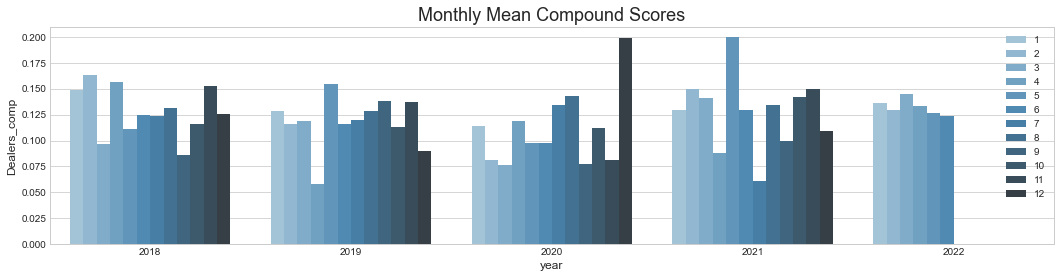

In [332]:
# monthly graph 
df_merged_group=df_dealers_years.groupby(['year', 'month'], as_index=False)[('Dealers_comp')].mean()

# plotting the figure
fig = plt.figure(figsize=(18,4))
# plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')
fig.add_subplot(111)
sns.barplot(data=df_merged_group, y='Dealers_comp', x='year', hue='month', palette="Blues_d")
plt.legend(loc='upper right')
plt.title(('Monthly Mean Compound Scores'),fontsize=18)

plt.show()

#### Semantic 

In [333]:
# getting the text out 
text_4 = df_dealers['content']
text_4

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        superb customer service from richard at the ca...
1        i look through your idea on tax base money con...
2                        look like racist fiat 500 twitter
3        the car dealership have give me a courtesy car...
4        2020-2021 fiat, equity, property correction wi...
                               ...                        
17376         you have / you would deffo b a fiat 500 girl
17377                             it get mark as very good
17378    i may be wrong but most car journey be less th...
17379    couldnt you have at least fill that fine new f...
17380    the 10th vehicle for our best customer, a 1 da...
Name: content, Length: 17381, dtype: object

In [334]:
#creating the tokens - 2mins
nlp = spacy.load('en_core_web_lg')

# tokenised the text 
docs_tkns_3 = []
for docs in text_4:
    tmp = [
        token.lemma_
        for token in nlp(docs)
        if (not token.is_stop) & (not token.is_punct) & (not token.like_num) & (not token.is_currency) & (not token.pos_ == "PROPN")
        ]
    docs_tkns_3.append(tmp)
    del tmp

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [335]:
# getting the bigram anf trigram out 
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    docs_tkns_3,
    # min_count=50,
    threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[docs_tkns_3],
    # min_count=50,
    # threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
docs_phrased_2 = [bigram[line] for line in docs_tkns_3]
#docs_phrased = [trigram[bigram[line]] for line in comment_tkns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [336]:
# getting the sentences 
sentences = docs_phrased_2

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [337]:
# building word2vec model 
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [338]:
# building the vocab 
from time import time 
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time to build vocab: 0.01 mins


In [339]:
# training the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time to train the model: 0.05 mins


In [340]:
# creating the the plot 
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=20).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(40, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 50,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(20)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


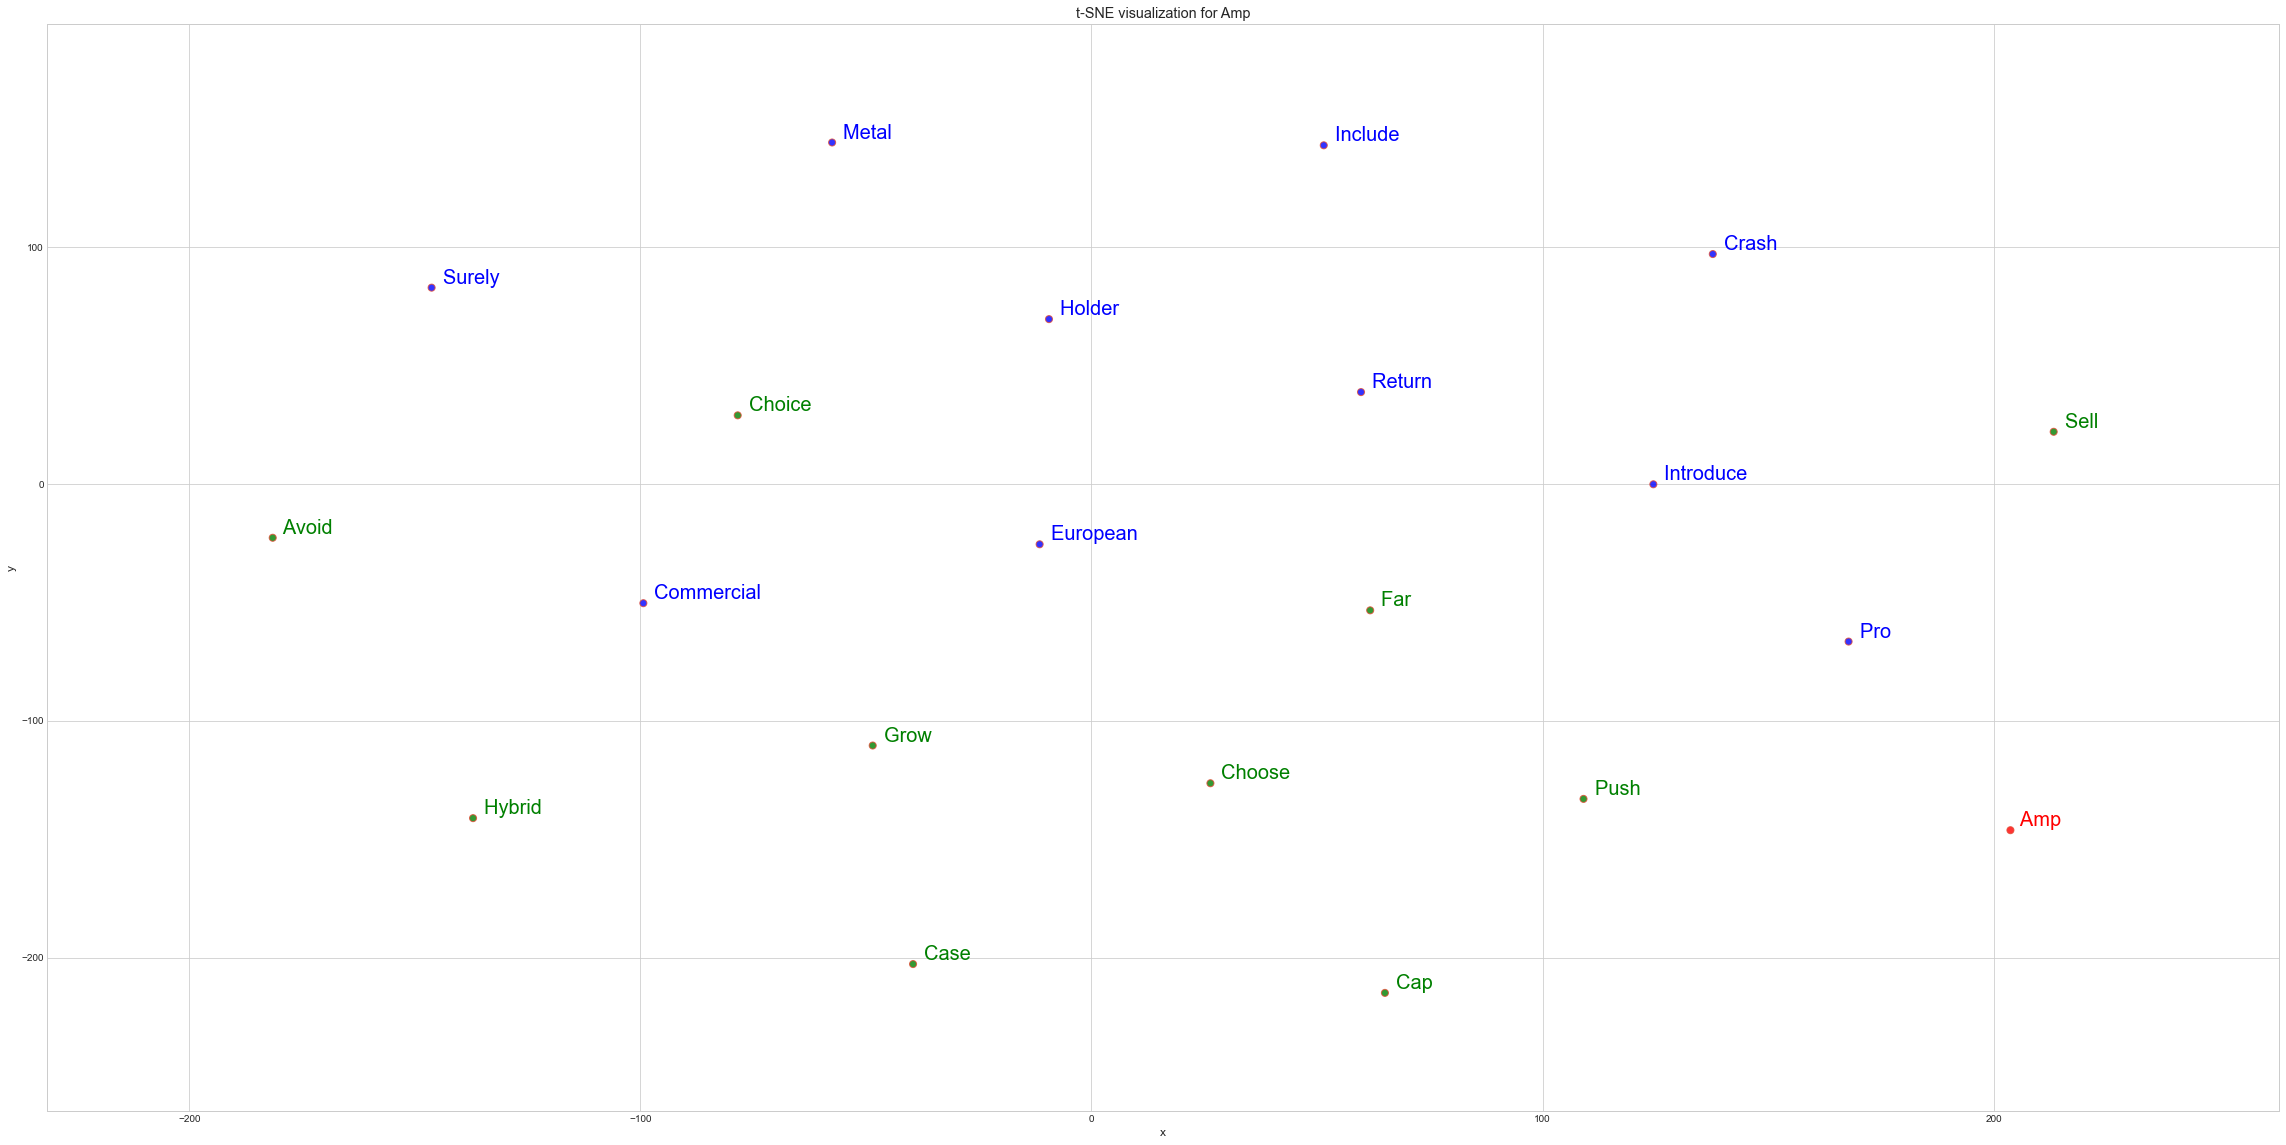

In [341]:
# getting the plots out
tsnescatterplot(w2v_model, "amp", [t[0] for t in w2v_model.wv.most_similar(positive=["ev","amp"], topn=20)][10:])

#### Events Extraction (for further understanding)

In [342]:
# importing the nlp model 
nlp = spacy.load("en_core_web_lg")

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [343]:
# extracting the text dealers out of the content 
text_dealers = df_dealers['content']

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [344]:
# getting the set_vec and docs 
sent_vecs = {}
docs = []
for title in df_dealers.content:
    doc = nlp(str(title))
    docs.append(doc)
    sent_vecs.update({title: doc.vector})

sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [345]:
# getting the clusters- 1 hour
from sklearn.cluster import DBSCAN
from tqdm import tqdm

x = np.array(vectors)

n_classes = {}

for i in tqdm(np.arange(0.001,1,0.002)):
    dbscan =DBSCAN(eps=i,min_samples=2,metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 500/500 [53:01<00:00,  6.36s/it]


In [346]:
# getting the keys and values 
values = n_classes.values()
keys =n_classes.keys()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [347]:
# creating a dataframe for the eps and cluster 
df_eps = pd.DataFrame(list(n_classes.items()), columns=['eps','clusters'])
df_eps

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


eps  clusters
0    0.001        22
1    0.003        30
2    0.005        36
3    0.007        46
4    0.009        49
..     ...       ...
495  0.991         2
496  0.993         2
497  0.995         2
498  0.997         2
499  0.999         2

[500 rows x 2 columns]

In [361]:
# # save to excel 
# df_eps.to_excel("eps.xlsx")

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


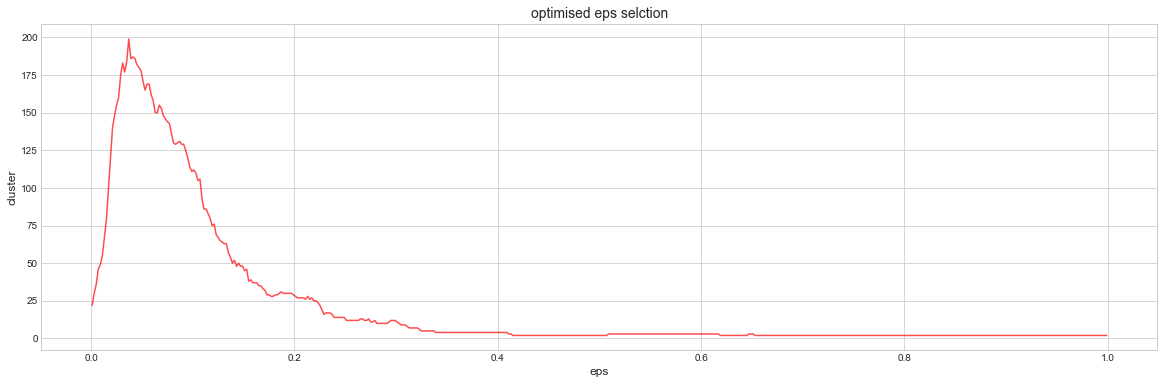

In [349]:
# plotting the graph of the many clusters are there - to make eps selection 
x_0 = np.array(df_eps['eps'])
y_0 = np.array(df_eps['clusters'])

plt.figure(figsize=(20,6))
plt.plot(x_0,y_0, color='red', alpha=0.7)
plt.xlabel('eps')
plt.ylabel('cluster')
plt.title('optimised eps selction',fontsize=14)
plt.show()

In [365]:
dbscan = DBSCAN(eps=0.037, min_samples=2,metric='cosine').fit(x)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [366]:
# getting the results of the cluster
results = pd.DataFrame({'label': dbscan.labels_, 'sent': sentences})
results

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


label                                               sent
0         -1  superb customer service from richard at the ca...
1          0  i look through your idea on tax base money con...
2         -1                  look like racist fiat 500 twitter
3          1  the car dealership have give me a courtesy car...
4         -1  2020-2021 fiat, equity, property correction wi...
...      ...                                                ...
16829     -1       you have / you would deffo b a fiat 500 girl
16830     -1                           it get mark as very good
16831      0  i may be wrong but most car journey be less th...
16832     -1  couldnt you have at least fill that fine new f...
16833     -1  the 10th vehicle for our best customer, a 1 da...

[16834 rows x 2 columns]

In [367]:
# getting the total number of clusters
results.label.unique()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [368]:
# creating an additional dataframe
df_dealers[['cluster']]="A"
df_dealers

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content cluster
0     2022-06-13  superb customer service from richard at the ca...       A
1     2022-06-13  i look through your idea on tax base money con...       A
2     2022-06-12                  look like racist fiat 500 twitter       A
3     2022-06-12  the car dealership have give me a courtesy car...       A
4     2022-06-12  2020-2021 fiat, equity, property correction wi...       A
...          ...                                                ...     ...
17376 2018-01-22       you have / you would deffo b a fiat 500 girl       A
17377 2018-01-22                           it get mark as very good       A
17378 2018-01-22  i may be wrong but most car journey be less th...       A
17379 2018-01-22  couldnt you have at least fill that fine new f...       A
17380 2018-01-22  the 10th vehicle for our best customer, a 1 da...       A

[17381 rows x 3 columns]

In [369]:
# event_df_1.drop(event_df_1.index, inplace=True)
# event_df_1.empty

i=0
for i in range(0,198):

    # if event_df_1.empty==True:
    if i==0:   
        examples_results = results[results.label==i].sent.tolist()

        event_df_1= df_dealers[df_dealers.content.isin(examples_results)][['date','content']]
        event_df_1['date'] = pd.to_datetime(event_df_1.date)
        event_df_1['cluster'] = i
        event_df_1 = event_df_1.sort_values(by='date').dropna()


    elif i==1:
        examples_results = results[results.label==i].sent.tolist()
        frame='event_df_'+str(i)
        frame_pre='event_df_'+str(i-1)

        event_df_2= df_dealers[df_dealers.content.isin(examples_results)][['date','content']]
        event_df_2['date'] = pd.to_datetime(event_df_2.date)
        event_df_2['cluster'] = i
        event_df_2 = event_df_2.sort_values(by='date').dropna()

        event_concat=pd.concat([event_df_1,event_df_2],ignore_index=True,sort=False,axis=0)
 
    elif i>1:
        examples_results = results[results.label==i].sent.tolist()
        frame='event_df_'+str(i)
        frame_pre='event_df_'+str(i-1)

        event_df_3= df_dealers[df_dealers.content.isin(examples_results)][['date','content']]
        event_df_3['date'] = pd.to_datetime(event_df_3.date)
        event_df_3['cluster'] = i
        event_df_3 = event_df_3.sort_values(by='date').dropna()

        event_concat=pd.concat([event_concat,event_df_3],ignore_index=True,sort=False,axis=0)
    
    i+=1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [370]:
# view the dataframe 
event_concat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content  cluster
0    2018-01-22  i may be wrong but most car journey be less th...        0
1    2018-01-22  you dont understand whats wrong with your fiat...        0
2    2018-01-23  let us say i sell you a service for 10 bsv. bs...        0
3    2018-01-23  buy an old car, maybe a citroen or a fiat. kee...        0
4    2018-01-23  it have / it be the belief of the public, he h...        0
...         ...                                                ...      ...
4856 2018-06-29  what be fiat 500 twitter gonna do now love isl...      195
4857 2018-02-18  we have 3 ready to hire local independent vehi...      196
4858 2018-06-08   we get 3 for hire local independent vehicle hire      196
4859 2018-01-22  yesterday be world environment day, and with f...      197
4860 2018-05-10  the times' sustainable transport supplement be...      197

[4861 rows x 3 columns]

In [371]:
# extracting the year out 
event_concat['year'] = event_concat['date'].dt.year.astype(int)
event_concat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content  cluster  \
0    2018-01-22  i may be wrong but most car journey be less th...        0   
1    2018-01-22  you dont understand whats wrong with your fiat...        0   
2    2018-01-23  let us say i sell you a service for 10 bsv. bs...        0   
3    2018-01-23  buy an old car, maybe a citroen or a fiat. kee...        0   
4    2018-01-23  it have / it be the belief of the public, he h...        0   
...         ...                                                ...      ...   
4856 2018-06-29  what be fiat 500 twitter gonna do now love isl...      195   
4857 2018-02-18  we have 3 ready to hire local independent vehi...      196   
4858 2018-06-08   we get 3 for hire local independent vehicle hire      196   
4859 2018-01-22  yesterday be world environment day, and with f...      197   
4860 2018-05-10  the times' sustainable transport supplement be...      197   

      year  
0     2018  
1     2018  
2     2018  
3     2018  
4     2018  
...    ...  
4856  2018  
4857  2018  
4858  2018  
4859  2018  
4860  2018  

[4861 rows x 4 columns]

In [372]:
# creating a new copy for year 
event_concat_year = event_concat.copy(deep=True)
event_concat_year.tail(50)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content  cluster  \
4811 2019-06-27  when take over the mind, body and soul, step a...      173   
4812 2018-07-27    now when i see a fiat 500 i think of your video      174   
4813 2019-06-25  i think about this every single time i see a f...      174   
4814 2018-08-15  someone call me fiat 500 but ive never even ha...      175   
4815 2019-04-29  thank god i've no get a fiat 500 kid i do not ...      175   
4816 2018-06-27  bitcoin songsheet: how education become a foun...      176   
4817 2019-04-03  bitcoin songsheet: how education become a foun...      176   
4818 2019-03-22  its a buy! 73mil share with low free float war...      177   
4819 2019-03-23  this be what 35p get you guys! 73mil share wit...      177   
4820 2018-09-10  no idea either but luke be definitely prime fi...      178   
4821 2019-02-14  sorry bert. no idea either but luke be definit...      178   
4822 2018-07-30  dont mind me im just unleash my inner 2016 fia...      179   
4823 2019-02-11      we do, im just unleash my inner 2016 fiat 500      179   
4824 2018-05-31  181 equal right for gig economy workers 182 fr...      180   
4825 2019-01-25  yes i do 182 free child care for low income fa...      180   
4826 2018-07-20                             i dont have a fiat 500      181   
4827 2019-01-20                        i do not have a fiat 500 ok      181   
4828 2018-06-10                                        little fiat      182   
4829 2019-01-16                                        fiat little      182   
4830 2018-09-09  when dark fruit twitter and fiat 500 twitter c...      183   
4831 2018-11-02  dark fruit twitter and fiat 500 twitter have c...      183   
4832 2018-12-13       when dark fruit and fiat 500 twitter collide      183   
4833 2018-10-17  fiat chrysler to kill off diesel in all cars b...      184   
4834 2018-12-10  fiat chrysler to kill off diesel in all cars b...      184   
4835 2018-07-17  with the marea, fiat boss paulo cantarella be ...      185   
4836 2018-12-04  during bravo/brava/marea development in the ea...      185   
4837 2018-07-24  fiat ditch diesel and petrol cars to go 'fully...      186   
4838 2018-11-28  fiat ditch diesel and petrol cars to go 'fully...      186   
4839 2018-07-24                       fiat = fix it again tomorrow      187   
4840 2018-11-20                          fiat = fix it again today      187   
4841 2018-08-14  drake be basically fiat 500 twitter in music form      188   
4842 2018-11-11      drake be just fiat 500 twitter in music form.      188   
4843 2018-02-17  heater blower motor fan resistor for oem numbe...      189   
4844 2018-10-14  heater fan resistor for oem number: 51736776, ...      189   
4845 2018-07-19                          your mom drive a fiat 500      190   
4846 2018-08-10                          your dad drive a fiat 500      190   
4847 2018-05-12  british drivers put off electric cars after mo...      191   
4848 2018-08-03  british drivers put off electric cars after mo...      191   
4849 2018-05-19    but him/her a fiat 500 so they could be alright      192   
4850 2018-08-02              the fiat 500 he get her be not enough      192   
4851 2018-02-13  i bet when love island be on, you can drive ar...      193   
4852 2018-07-07  hi rob, have you notice that when love island ...      193   
4853 2018-01-28                   where do you park your fiat 500?      194   
4854 2018-07-01                    whereve you park your fiat 500?      194   
4855 2018-05-21  love island over. what be fiat 500 twitter gon...      195   
4856 2018-06-29  what be fiat 500 twitter gonna do now love isl...      195   
4857 2018-02-18  we have 3 ready to hire local independent vehi...      196   
4858 2018-06-08   we get 3 for hire local independent vehicle hire      196   
4859 2018-01-22  yesterday be world environment day, and with f...      197   
4860 2018-05-10  the times' sustainable transport supplement 

In [373]:
# query years that is greater then 2021 
event_concat_year_year=event_concat_year.query("year >= 2021")
event_concat_year_year

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content  cluster  \
3189 2021-01-01  be a family run clean company specialise in bu...        0   
3190 2021-01-02  why do not you point out, , that tax do not pa...        0   
3191 2021-01-02  get your email shame not be able to exchange f...        0   
3192 2021-01-03  be sit in right now and despite your emails, w...        0   
3193 2021-01-04  i resist buy the barbie fiat 500 for my daught...        0   
...         ...                                                ...      ...   
4646 2021-02-13  do tube drivers wave to each other like bus an...      105   
4648 2021-01-30                            you drive a white fiat?      106   
4657 2021-01-29                          what be fiat 500 twitter?      107   
4659 2021-01-16  save your money see us out and about, message ...      108   
4661 2021-01-05  new car delivery delay likely to last into nex...      109   

      year  
3189  2021  
3190  2021  
3191  2021  
3192  2021  
3193  2021  
...    ...  
4646  2021  
4648  2021  
4657  2021  
4659  2021  
4661  2021  

[1260 rows x 4 columns]

In [374]:
# making the dataframe with the year 2021 and 2022
# pd.reset_option("^display")
event_concat_year_2122 = event_concat_year_year.copy(deep=True)
event_concat_year_2122 = event_concat_year_2122.drop_duplicates(subset=["cluster", "year"])
event_concat_year_2122[['cluster']]=event_concat_year_2122[['cluster']].astype(str)
event_concat_year_2122['label'] = event_concat_year_2122[['cluster', 'content']].apply(lambda x: ': '.join(x), axis=1)
event_concat_year_2122

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date                                            content cluster  \
3189 2021-01-01  be a family run clean company specialise in bu...       0   
3828 2022-01-01  my dad buy a fiat punto back in the early 2000...       0   
4285 2022-05-27  cars in the garage and theyve give me a fiat 5...       1   
4297 2022-06-07                                probably a fiat 500       2   
4298 2021-08-13  a few more pics of the first new ambulance at ...       3   
...         ...                                                ...     ...   
4646 2021-02-13  do tube drivers wave to each other like bus an...     105   
4648 2021-01-30                            you drive a white fiat?     106   
4657 2021-01-29                          what be fiat 500 twitter?     107   
4659 2021-01-16  save your money see us out and about, message ...     108   
4661 2021-01-05  new car delivery delay likely to last into nex...     109   

      year                                              label  
3189  2021  0: be a family run clean company specialise in...  
3828  2022  0: my dad buy a fiat punto back in the early 2...  
4285  2022  1: cars in the garage and theyve give me a fia...  
4297  2022                             2: probably a fiat 500  
4298  2021  3: a few more pics of the first new ambulance ...  
...    ...                                                ...  
4646  2021  105: do tube drivers wave to each other like b...  
4648  2021                       106: you drive a white fiat?  
4657  2021                     107: what be fiat 500 twitter?  
4659  2021  108: save your money see us out and about, mes...  
4661  2021  109: new car delivery delay likely to last int...  

[127 rows x 5 columns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


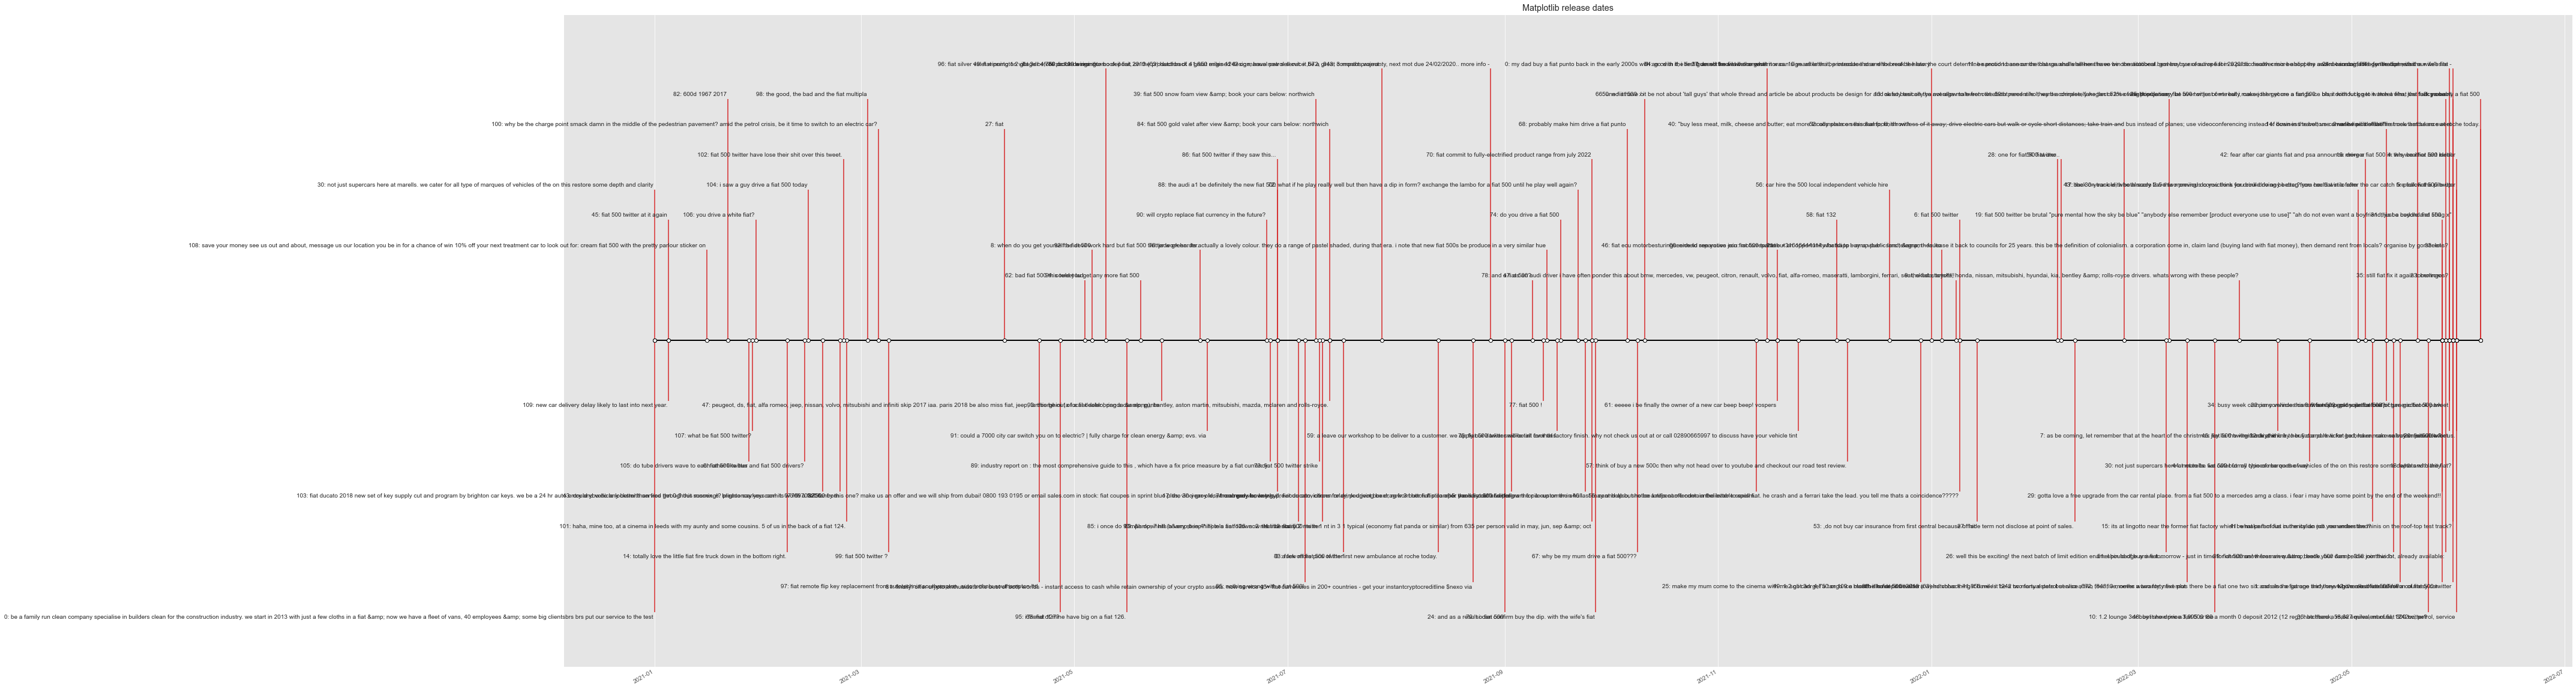

In [379]:
# creating a timeline - to see the events that has occured - for further understanding
dates = np.array(event_concat_year_2122['date'])
names = np.array(event_concat_year_2122['label'])
# names = np.array(event_concat_year_2122['cluster'])

# Choose some nice levels
levels = np.tile([-4.5,4.5,-4,4,-3.5,3.5,-3,3,-2.5,2.5,-2, 2, -1.5, 1.5, -1, 1],
                 int(np.ceil(len(dates)/16)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(60, 20))
ax.set(title="Matplotlib release dates")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-2, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format xaxis with 4 month intervals
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
# ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

### Fiat Production 

In [226]:
# extracting production out
production = df_retain[['Fiat_Production']]
production

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_Production
0      little wonder fiat workers be strike over ange...
1                                             fiat diyes
2                                she drive a sorry guy x
3      qe be only an asset swap. any fiat currency ca...
4      milestone as the two millionth fiat 500 roll o...
...                                                  ...
17376  drive down duel carriageway do 65 on the outsi...
17377  i may be wrong but most car journey be less th...
17378  what a trader? money people? gold good or serv...
17379  when bf and gf go to race each other back to b...
17380  how to take daily climate action save energy a...

[17381 rows x 1 columns]

In [227]:
# appending the years to the columns
df_production = pd.concat([years,production],ignore_index=False,sort=False,axis=1)

# drop for any NaN's
df_production = df_production.dropna()

# renaming the columns 
df_production = df_production.rename(columns = {'Fiat_Production':'content'})

df_production

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content
0     2022-06-13  little wonder fiat workers be strike over ange...
1     2022-06-13                                         fiat diyes
2     2022-06-12                            she drive a sorry guy x
3     2022-06-12  qe be only an asset swap. any fiat currency ca...
4     2022-06-12  milestone as the two millionth fiat 500 roll o...
...          ...                                                ...
17376 2018-01-22  drive down duel carriageway do 65 on the outsi...
17377 2018-01-22  i may be wrong but most car journey be less th...
17378 2018-01-22  what a trader? money people? gold good or serv...
17379 2018-01-22  when bf and gf go to race each other back to b...
17380 2018-01-22  how to take daily climate action save energy a...

[17381 rows x 2 columns]

In [228]:
# appendign the compund to the dataframe
col_list_1 = list(production.columns)
col_list_1

for col_name in col_list_1:
# creating new names of columns 
    header_1 = str(col_name) + '_sent'
    header_2 = str(col_name) + '_comp'

# getting the sentiments
    sid = SIA()
    production[header_1] = production[col_name].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
    production[header_2]   = production[header_1].apply(lambda x: x['compound']+1*(10**-6))

production

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-228-b8447f39582f>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-228-b8447f39582f>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

Fiat_Production  \
0      little wonder fiat workers be strike over ange...   
1                                             fiat diyes   
2                                she drive a sorry guy x   
3      qe be only an asset swap. any fiat currency ca...   
4      milestone as the two millionth fiat 500 roll o...   
...                                                  ...   
17376  drive down duel carriageway do 65 on the outsi...   
17377  i may be wrong but most car journey be less th...   
17378  what a trader? money people? gold good or serv...   
17379  when bf and gf go to race each other back to b...   
17380  how to take daily climate action save energy a...   

                                    Fiat_Production_sent  Fiat_Production_comp  
0      {'neg': 0.212, 'neu': 0.678, 'pos': 0.11, 'com...             -0.381799  
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...              0.000001  
2      {'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'comp...             -0.077199  
3      {'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...              0.361201  
4      {'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'comp...              0.177901  
...                                                  ...                   ...  
17376  {'neg': 0.104, 'neu': 0.835, 'pos': 0.061, 'co...             -0.318199  
17377  {'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...             -0.261699  
17378  {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...              0.875001  
17379  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...              0.000001  
17380  {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...              0.915301  

[17381 rows x 3 columns]

In [229]:
# converting the years into dataframe
year = pd.DataFrame(df_production['date'])
year

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date
0     2022-06-13
1     2022-06-13
2     2022-06-12
3     2022-06-12
4     2022-06-12
...          ...
17376 2018-01-22
17377 2018-01-22
17378 2018-01-22
17379 2018-01-22
17380 2018-01-22

[17381 rows x 1 columns]

In [230]:
df_production_years =pd.concat([production,year],axis=1)
df_production_years

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_Production  \
0      little wonder fiat workers be strike over ange...   
1                                             fiat diyes   
2                                she drive a sorry guy x   
3      qe be only an asset swap. any fiat currency ca...   
4      milestone as the two millionth fiat 500 roll o...   
...                                                  ...   
17376  drive down duel carriageway do 65 on the outsi...   
17377  i may be wrong but most car journey be less th...   
17378  what a trader? money people? gold good or serv...   
17379  when bf and gf go to race each other back to b...   
17380  how to take daily climate action save energy a...   

                                    Fiat_Production_sent  \
0      {'neg': 0.212, 'neu': 0.678, 'pos': 0.11, 'com...   
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
2      {'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'comp...   
3      {'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...   
4      {'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'comp...   
...                                                  ...   
17376  {'neg': 0.104, 'neu': 0.835, 'pos': 0.061, 'co...   
17377  {'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...   
17378  {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...   
17379  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
17380  {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...   

       Fiat_Production_comp       date  
0                 -0.381799 2022-06-13  
1                  0.000001 2022-06-13  
2                 -0.077199 2022-06-12  
3                  0.361201 2022-06-12  
4                  0.177901 2022-06-12  
...                     ...        ...  
17376             -0.318199 2018-01-22  
17377             -0.261699 2018-01-22  
17378              0.875001 2018-01-22  
17379              0.000001 2018-01-22  
17380              0.915301 2018-01-22  

[17381 rows x 4 columns]

In [231]:
# caculating the mean probabilty by each year
# grouping it by years 
df_production_years["year"] = df_production_years["date"].dt.year.astype(int)
df_production_years["month"] = df_production_years["date"].dt.month.astype(int)

df_production_years

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fiat_Production  \
0      little wonder fiat workers be strike over ange...   
1                                             fiat diyes   
2                                she drive a sorry guy x   
3      qe be only an asset swap. any fiat currency ca...   
4      milestone as the two millionth fiat 500 roll o...   
...                                                  ...   
17376  drive down duel carriageway do 65 on the outsi...   
17377  i may be wrong but most car journey be less th...   
17378  what a trader? money people? gold good or serv...   
17379  when bf and gf go to race each other back to b...   
17380  how to take daily climate action save energy a...   

                                    Fiat_Production_sent  \
0      {'neg': 0.212, 'neu': 0.678, 'pos': 0.11, 'com...   
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
2      {'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'comp...   
3      {'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...   
4      {'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'comp...   
...                                                  ...   
17376  {'neg': 0.104, 'neu': 0.835, 'pos': 0.061, 'co...   
17377  {'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...   
17378  {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp...   
17379  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
17380  {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...   

       Fiat_Production_comp       date  year  month  
0                 -0.381799 2022-06-13  2022      6  
1                  0.000001 2022-06-13  2022      6  
2                 -0.077199 2022-06-12  2022      6  
3                  0.361201 2022-06-12  2022      6  
4                  0.177901 2022-06-12  2022      6  
...                     ...        ...   ...    ...  
17376             -0.318199 2018-01-22  2018      1  
17377             -0.261699 2018-01-22  2018      1  
17378              0.875001 2018-01-22  2018      1  
17379              0.000001 2018-01-22  2018      1  
17380              0.915301 2018-01-22  2018      1  

[17381 rows x 6 columns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/seaborn/categorical.py:381: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



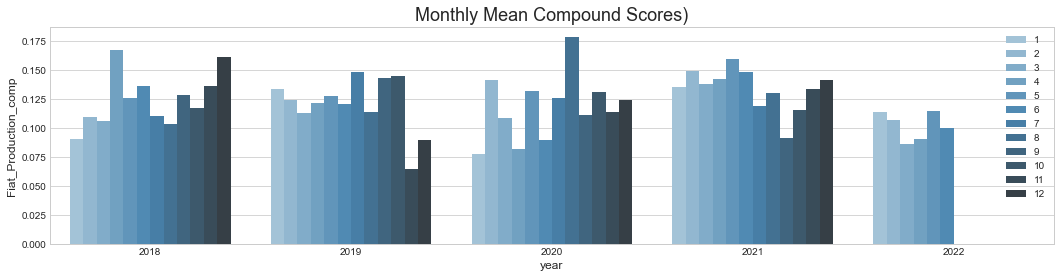

In [232]:
# monthly graph 
df_merged_group_1=df_production_years.groupby(['year', 'month'], as_index=False)[('Fiat_Production_comp')].mean()


# ====================================

fig = plt.figure(figsize=(18,4))
# plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

# ====================================
fig.add_subplot(111)
sns.barplot(data=df_merged_group_1, y='Fiat_Production_comp', x='year', hue='month', palette="Blues_d")
plt.legend(loc='upper right')
plt.title('Monthly Mean Compound Scores)',fontsize=18)

plt.show()

#### Semantic similiarity

In [233]:
text_5 = df_production['content']
text_5

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0        little wonder fiat workers be strike over ange...
1                                               fiat diyes
2                                  she drive a sorry guy x
3        qe be only an asset swap. any fiat currency ca...
4        milestone as the two millionth fiat 500 roll o...
                               ...                        
17376    drive down duel carriageway do 65 on the outsi...
17377    i may be wrong but most car journey be less th...
17378    what a trader? money people? gold good or serv...
17379    when bf and gf go to race each other back to b...
17380    how to take daily climate action save energy a...
Name: content, Length: 17381, dtype: object

In [234]:
#creating the tokens - 2mins
nlp = spacy.load('en_core_web_lg')

# tokenised the text 
docs_tkns_5 = []
for docs in text_5:
    tmp = [
        token.lemma_
        for token in nlp(docs)
        if (not token.is_stop) & (not token.is_punct) & (not token.like_num) & (not token.is_currency) & (not token.pos_ == "PROPN")
        ]
    docs_tkns_5.append(tmp)
    del tmp

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [235]:
# getting the bigram anf trigram out 
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    docs_tkns_5,
    # min_count=50,
    threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[docs_tkns_5],
    # min_count=50,
    # threshold=5,
    # max_vocab_size=50000,
    common_terms=common_terms,
)
# uncomment if bi-grammed, tokenized document is preferred
docs_phrased_5 = [bigram[line] for line in docs_tkns_5]
#docs_phrased = [trigram[bigram[line]] for line in comment_tkns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 14:13:30: collecting all words and their counts
INFO - 14:13:30: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:13:30: PROGRESS: at sentence #10000, processed 85998 words and 71394 word types
INFO - 14:13:30: collected 113908 word types from a corpus of 149575 words (unigram + bigrams) and 17381 sentences
INFO - 14:13:30: using 113908 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>
INFO - 14:13:30: collecting all words and their counts
INFO - 14:13:30: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:13:30: PROGRESS: at sentence #10000, proces

In [236]:
#getting the sentences 
sentences = docs_phrased_5

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [237]:
# building word2vec model 
cores = multiprocessing.cpu_count()
# building the model 
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [238]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [239]:
# building the vocab 
from time import time 
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 14:13:38: collecting all words and their counts
INFO - 14:13:38: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:13:38: PROGRESS: at sentence #10000, processed 81944 words, keeping 11027 word types
INFO - 14:13:38: collected 14514 word types from a corpus of 142338 raw words and 17381 sentences
INFO - 14:13:38: Loading a fresh vocabulary
INFO - 14:13:38: effective_min_count=20 retains 1300 unique words (8% of original 14514, drops 13214)
INFO - 14:13:38: effective_min_count=20 leaves 102329 word corpus (71% of original 142338, drops 40009)
INFO - 14:13:38: deleting the raw counts dictionary of 14514

Time to build vocab: 0.01 mins


In [240]:
# training the model
t = time()

model = w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 14:13:39: training model with 7 workers on 1300 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 14:13:39: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:39: worker thread finished; awaiting finish 

Time to train the model: 0.06 mins


In [241]:
# creating the the plot 
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=14).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(40, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 50,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(20)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

INFO - 14:13:42: precomputing L2-norms of word weight vectors
/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



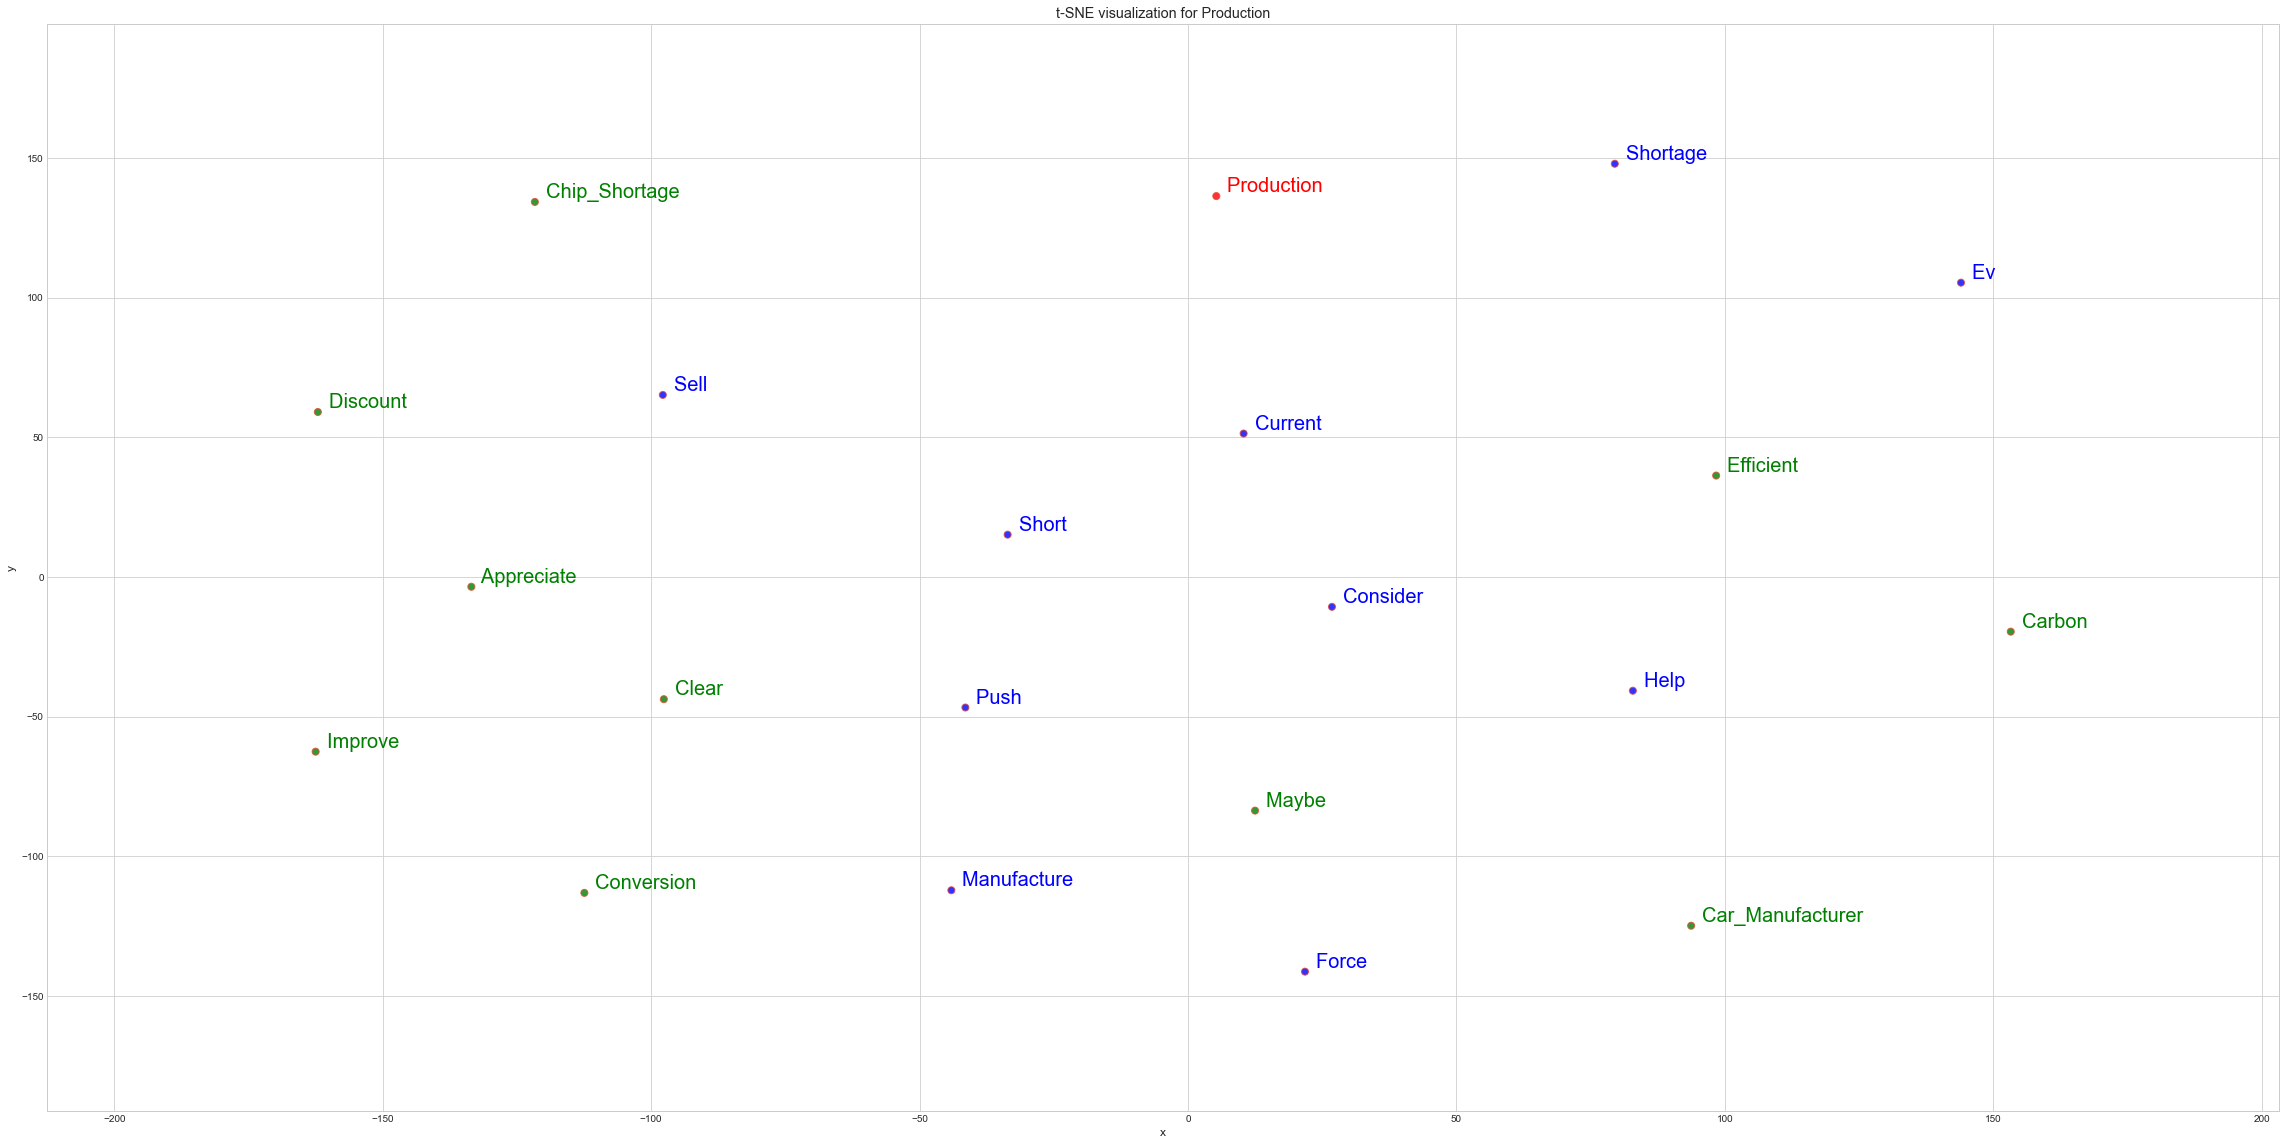

In [242]:
# getting the plot of the graph 
tsnescatterplot(w2v_model, "production", [t[0] for t in w2v_model.wv.most_similar(positive=["production"], topn=20)][10:])

##### Events Extraction (for further understanding)

In [243]:
# extracting the text dealers out of the content 
text_production = df_production['content']

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [244]:
# getting the set_vec and docs 
sent_vecs = {}
docs = []
for title in df_production.content:
    doc = nlp(str(title))
    docs.append(doc)
    sent_vecs.update({title: doc.vector})

sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [245]:
# getting the clusters- 1 hour
from sklearn.cluster import DBSCAN
from tqdm import tqdm

x = np.array(vectors)

n_classes = {}

for i in tqdm(np.arange(0.001,1,0.002)):
    dbscan =DBSCAN(eps=i,min_samples=2,metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 500/500 [54:37<00:00,  6.55s/it]


In [246]:
# getting the keys and values 
values = n_classes.values()
keys =n_classes.keys()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [247]:
# creating a dataframe for the eps and cluster 
df_eps = pd.DataFrame(list(n_classes.items()), columns=['eps','clusters'])
df_eps

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



eps  clusters
0    0.001        22
1    0.003        30
2    0.005        36
3    0.007        46
4    0.009        49
..     ...       ...
495  0.991         2
496  0.993         2
497  0.995         2
498  0.997         2
499  0.999         2

[500 rows x 2 columns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



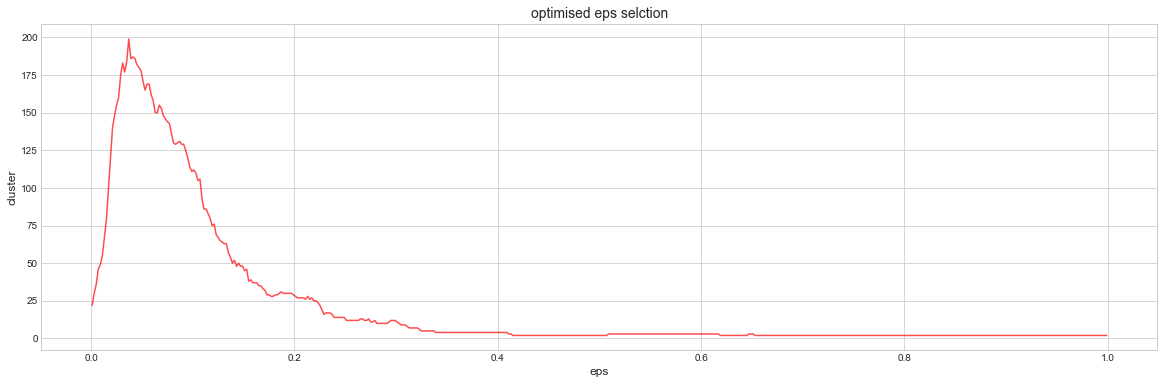

In [248]:
# plotting the graph of the many clusters are there - to make eps selection 
x_0 = np.array(df_eps['eps'])
y_0 = np.array(df_eps['clusters'])

plt.figure(figsize=(20,6))
plt.plot(x_0,y_0, color='red', alpha=0.7)
plt.xlabel('eps')
plt.ylabel('cluster')
plt.title('optimised eps selction',fontsize=14)
plt.show()

In [249]:
# getting the model
dbscan = DBSCAN(eps=0.037, min_samples=2,metric='cosine').fit(x)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [250]:
# getting the results of the cluster
results_1 = pd.DataFrame({'label': dbscan.labels_, 'sent': sentences})
results_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



label                                               sent
0         -1  little wonder fiat workers be strike over ange...
1          0                                         fiat diyes
2         -1                            she drive a sorry guy x
3         -1  qe be only an asset swap. any fiat currency ca...
4         -1  milestone as the two millionth fiat 500 roll o...
...      ...                                                ...
16829      1  drive down duel carriageway do 65 on the outsi...
16830      1  i may be wrong but most car journey be less th...
16831      1  what a trader? money people? gold good or serv...
16832     -1  when bf and gf go to race each other back to b...
16833     -1  how to take daily climate action save energy a...

[16834 rows x 2 columns]

In [251]:
# getting the total number of clusters
results_1.label.unique()

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [252]:
# creating an additional dataframe
df_production[['cluster']]="A"
df_production

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content cluster
0     2022-06-13  little wonder fiat workers be strike over ange...       A
1     2022-06-13                                         fiat diyes       A
2     2022-06-12                            she drive a sorry guy x       A
3     2022-06-12  qe be only an asset swap. any fiat currency ca...       A
4     2022-06-12  milestone as the two millionth fiat 500 roll o...       A
...          ...                                                ...     ...
17376 2018-01-22  drive down duel carriageway do 65 on the outsi...       A
17377 2018-01-22  i may be wrong but most car journey be less th...       A
17378 2018-01-22  what a trader? money people? gold good or serv...       A
17379 2018-01-22  when bf and gf go to race each other back to b...       A
17380 2018-01-22  how to take daily climate action save energy a...       A

[17381 rows x 3 columns]

In [253]:
# event_df_1.drop(event_df_1.index, inplace=True)
# event_df_1.empty

i=0
for i in range(0,198):

    # if event_df_1.empty==True:
    if i==0:   
        examples_results = results_1[results_1.label==i].sent.tolist()

        event_df_1= df_production[df_production.content.isin(examples_results)][['date','content']]
        event_df_1['date'] = pd.to_datetime(event_df_1.date)
        event_df_1['cluster'] = i
        event_df_1 = event_df_1.sort_values(by='date').dropna()


    elif i==1:
        examples_results = results_1[results_1.label==i].sent.tolist()
        frame='event_df_'+str(i)
        frame_pre='event_df_'+str(i-1)

        event_df_2= df_production[df_production.content.isin(examples_results)][['date','content']]
        event_df_2['date'] = pd.to_datetime(event_df_2.date)
        event_df_2['cluster'] = i
        event_df_2 = event_df_2.sort_values(by='date').dropna()

        event_concat=pd.concat([event_df_1,event_df_2],ignore_index=True,sort=False,axis=0)
 
    elif i>1:
        examples_results = results_1[results_1.label==i].sent.tolist()
        frame='event_df_'+str(i)
        frame_pre='event_df_'+str(i-1)

        event_df_3= df_production[df_production.content.isin(examples_results)][['date','content']]
        event_df_3['date'] = pd.to_datetime(event_df_3.date)
        event_df_3['cluster'] = i
        event_df_3 = event_df_3.sort_values(by='date').dropna()

        event_concat=pd.concat([event_concat,event_df_3],ignore_index=True,sort=False,axis=0)
    
    i+=1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [254]:
# view the dataframe 
event_concat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content  cluster
0    2018-04-14                                               fiat        0
1    2018-04-25                                               fiat        0
2    2018-05-08                                        fiat tempra        0
3    2018-07-05                                         fiat 1100r        0
4    2018-08-13                                     fiat cunto /jl        0
...         ...                                                ...      ...
4856 2018-07-05  what be fiat 500 twitter gonna do now love isl...      195
4857 2018-02-14  we have 3 ready to hire local independent vehi...      196
4858 2018-06-04   we get 3 for hire local independent vehicle hire      196
4859 2018-03-28  yes, off to new york on sunday to pick up the ...      197
4860 2018-04-02  charlie and me have park up the hymer and the ...      197

[4861 rows x 3 columns]

In [255]:
# extracting the year out 
event_concat['year'] = event_concat['date'].dt.year.astype(int)
event_concat

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content  cluster  \
0    2018-04-14                                               fiat        0   
1    2018-04-25                                               fiat        0   
2    2018-05-08                                        fiat tempra        0   
3    2018-07-05                                         fiat 1100r        0   
4    2018-08-13                                     fiat cunto /jl        0   
...         ...                                                ...      ...   
4856 2018-07-05  what be fiat 500 twitter gonna do now love isl...      195   
4857 2018-02-14  we have 3 ready to hire local independent vehi...      196   
4858 2018-06-04   we get 3 for hire local independent vehicle hire      196   
4859 2018-03-28  yes, off to new york on sunday to pick up the ...      197   
4860 2018-04-02  charlie and me have park up the hymer and the ...      197   

      year  
0     2018  
1     2018  
2     2018  
3     2018  
4     2018  
...    ...  
4856  2018  
4857  2018  
4858  2018  
4859  2018  
4860  2018  

[4861 rows x 4 columns]

In [256]:
# creating a new copy for year 
event_concat_year_1 = event_concat.copy(deep=True)
event_concat_year_1.tail(50)

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content  cluster  \
4811 2018-07-30  someone call me fiat 500 but ive never even ha...      176   
4812 2019-06-03  thank god i've no get a fiat 500 kid i do not ...      176   
4813 2018-12-21  think of buy a new 500c then why not head over...      177   
4814 2019-06-03  have you watch our road test review of the fia...      177   
4815 2018-09-10                                    une fiat 500 :o      178   
4816 2019-05-10                                       une fiat 500      178   
4817 2018-04-18  "buy less meat, milk, cheese &amp; butter; eat...      179   
4818 2019-05-01  "buy less meat, milk, cheese and butter; eat m...      179   
4819 2018-04-14  not drake but yeah! haha. better than post pic...      180   
4820 2019-04-23  not drake but yeah! better than post pics of m...      180   
4821 2018-03-13                     its never a fiat 500 no way !!      181   
4822 2019-04-04                 its just a fiat 500... do it well!      181   
4823 2018-08-14  fiat punto 1.2 gbt 3dr 4,750 or 109 a month - ...      182   
4824 2018-09-16  fiat punto 1.2 gbt 3dr 4,750 or 109 a month - ...      182   
4825 2019-03-23  1.2 gbt 3dr 4,750 or 109 a month - no deposit ...      182   
4826 2019-02-21  as be coming, let remember that at the heart o...      183   
4827 2019-03-21  the feast of the nativity of the bless virgin ...      183   
4828 2018-06-08                          bet she drive a fiat 500.      184   
4829 2019-03-10                       bet she drive a fiat 500 too      184   
4830 2018-06-23  bitcoin songsheet: how education become a foun...      185   
4831 2019-03-04  bitcoin songsheet: how education become a foun...      185   
4832 2018-07-17  peugeot, ds, fiat, alfa romeo, jeep, nissan, v...      186   
4833 2019-02-23  as an audi driver i have often ponder this abo...      186   
4834 2019-01-31  this be what 35p get you guys! 73mil share wit...      187   
4835 2019-02-20  its a buy! 73mil share with low free float war...      187   
4836 2018-07-09  with the marea, fiat boss paulo cantarella be ...      188   
4837 2018-12-10  during bravo/brava/marea development in the ea...      188   
4838 2018-07-19                       fiat = fix it again tomorrow      189   
4839 2018-12-01                          fiat = fix it again today      189   
4840 2018-03-20                  a see youve join fiat 500 twitter      190   
4841 2018-11-14            nice to see youve join fiat 500 twitter      190   
4842 2018-01-28                     fiat 500 twitter be quaaakingg      191   
4843 2018-04-05       fiat 500 twitter be you fuckkinnngggreadyyyy      191   
4844 2018-05-22                           one for fiat 500 twitter      191   
4845 2018-10-05                           fiat 500 twitter for you      191   
4846 2018-05-23                 i saw a guy drive a fiat 500 today      192   
4847 2018-08-31                       i saw a man drive a fiat 500      192   
4848 2018-02-09  fiat 500 twitter will mock suicide and mental ...      193   
4849 2018-08-23  fiat 500 twitter tweet about mental health and...      193   
4850 2018-02-10                                     600d 1967 2017      194   
4851 2018-04-26                                     600d 1967 2017      194   
4852 2018-07-02                                     600d 1967 2017      194   
4853 2018-07-30                                     600d 1967 2018      194   
4854 2018-08-06                                     600d 1967 2017      194   
4855 2018-05-17  love island over. what be fiat 500 twitter gon...      195   
4856 2018-07-05  what be fiat 500 twitter gonna do now love isl...      195   
4857 2018-02-14  we have 3 ready to hire local independent vehi...      196   
4858 2018-06-04   we get 3 for hire local independent vehicle hire      196   
4859 2018-03-28  yes, off to new york on sunday to pick up the ...      197   
4860 2018-04-02  charlie and me have park up the hymer and th

In [257]:
# query years that is greater then 2021 
event_concat_year_1=event_concat_year_1.query("year >= 2021")
event_concat_year_1

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content  cluster  \
14   2021-01-10                                               fiat        0   
15   2021-06-15                                               fiat        0   
16   2021-08-08                                               fiat        0   
17   2021-10-27                                               fiat        0   
18   2021-11-05                                               fiat        0   
...         ...                                                ...      ...   
4634 2021-02-09  do tube drivers wave to each other like bus an...      101   
4636 2021-02-08                            you drive a white fiat?      102   
4638 2021-01-26    but him/her a fiat 500 so they could be alright      103   
4640 2021-01-16  save your money see us out and about, message ...      104   
4643 2021-01-10  cant help but notice latifis name contain the ...      105   

      year  
14    2021  
15    2021  
16    2021  
17    2021  
18    2021  
...    ...  
4634  2021  
4636  2021  
4638  2021  
4640  2021  
4643  2021  

[1295 rows x 4 columns]

In [258]:
# making the dataframe with the year 2021 and 2022
# pd.reset_option("^display")
event_concat_year_2122 = event_concat_year_1.copy(deep=True)
event_concat_year_2122 = event_concat_year_2122.drop_duplicates(subset=["cluster", "year"])
event_concat_year_2122[['cluster']]=event_concat_year_2122[['cluster']].astype(str)
event_concat_year_2122['label'] = event_concat_year_2122[['cluster', 'content']].apply(lambda x: ': '.join(x), axis=1)
event_concat_year_2122

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date                                            content cluster  \
14   2021-01-10                                               fiat       0   
19   2022-05-23                                               fiat       0   
3167 2021-01-01  lol she dont need ur attention, will she even ...       1   
3853 2022-01-01  due to inflation yes, but it will still be the...       1   
4310 2022-06-10  one moment youre trek like idiot. next moment ...       2   
...         ...                                                ...     ...   
4634 2021-02-09  do tube drivers wave to each other like bus an...     101   
4636 2021-02-08                            you drive a white fiat?     102   
4638 2021-01-26    but him/her a fiat 500 so they could be alright     103   
4640 2021-01-16  save your money see us out and about, message ...     104   
4643 2021-01-10  cant help but notice latifis name contain the ...     105   

      year                                              label  
14    2021                                            0: fiat  
19    2022                                            0: fiat  
3167  2021  1: lol she dont need ur attention, will she ev...  
3853  2022  1: due to inflation yes, but it will still be ...  
4310  2022  2: one moment youre trek like idiot. next mome...  
...    ...                                                ...  
4634  2021  101: do tube drivers wave to each other like b...  
4636  2021                       102: you drive a white fiat?  
4638  2021  103: but him/her a fiat 500 so they could be a...  
4640  2021  104: save your money see us out and about, mes...  
4643  2021  105: cant help but notice latifis name contain...  

[130 rows x 5 columns]

/Users/celinejiang/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



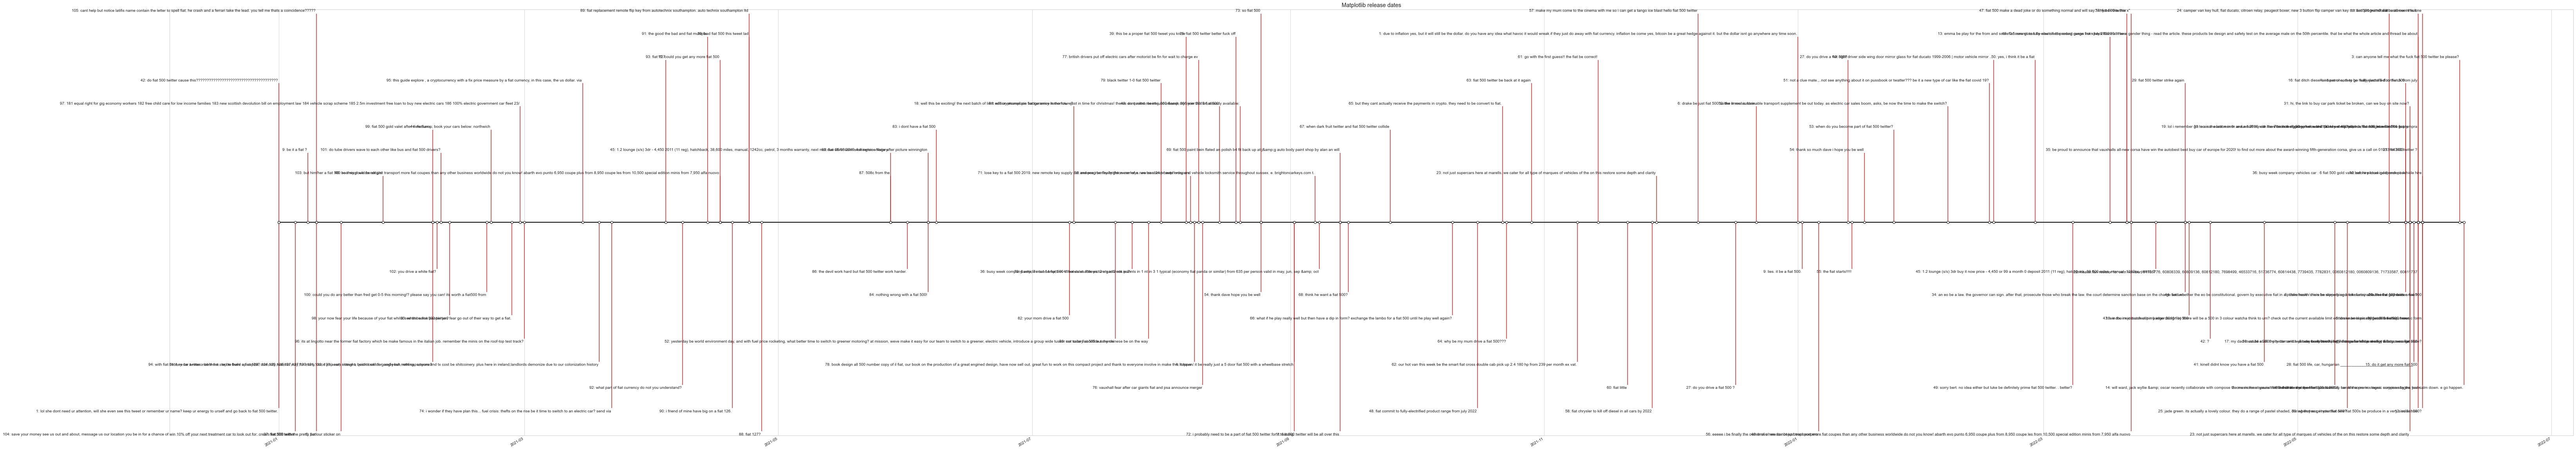

In [259]:
# creating a timeline - to see the events that has occured 
dates = np.array(event_concat_year_2122['date'])
names = np.array(event_concat_year_2122['label'])
# names = np.array(event_concat_year_2122['cluster'])

# Choose some nice levels
levels = np.tile([-4.5,4.5,-4,4,-3.5,3.5,-3,3,-2.5,2.5,-2, 2, -1.5, 1.5, -1, 1],
                 int(np.ceil(len(dates)/16)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(110, 20))
ax.set(title="Matplotlib release dates")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-2, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format xaxis with 4 month intervals
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
# ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.01)
plt.show()

# Geographical Location 

In [64]:
# importing the model
nlp = spacy.load('en_core_web_lg')

In [65]:
# getting the dataframe 
df_tweet_raw=tweets.copy(deep=True)

In [66]:
# extracting the date, location ,lemaatised text (BEV Sales Model)
df_tweet_ym=tweets.copy(deep=True)
df_tweet_ym=df_tweet_ym[['date','user_location','lemmatised','keywords']]
df_tweet_ym

date       user_location  \
0     2022-06-13      South of North   
1     2022-06-13      United Kingdom   
2     2022-06-12     London, England   
3     2022-06-12           Liverpool   
4     2022-06-12  Heywood lancashire   
...          ...                 ...   
17962 2018-01-01                 NaN   
17963 2018-01-01           Edinburgh   
17964 2018-01-01                 NaN   
17965 2018-01-01             Bristol   
17966 2018-01-01    Suffolk, England   

                                              lemmatised           keywords  
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage  
1      xr offshoot "roads rebellion" today target toy...        green shift  
2      fuel crisis: thefts on the rise be it time to ...        green shift  
3      all cars be expensive .. if replace switch to ...        green shift  
4      yep 100% fuel cost be rise in the hope it will...        green shift  
...                                                  ...                ...  
17962  happy new year only to the person who invent t...               fiat  
17963                                   fiat 500 twitter               fiat  
17964                          - ,- ,- ,then last of all               fiat  
17965  happy new year you magnificent swines. may you...               fiat  
17966  happy new year! receive this earlier from a fr...               fiat  

[17967 rows x 4 columns]

In [67]:
# getting the compound score (BEV Sales Model)
sid = SIA()
df_tweet_ym['sentiments'] = df_tweet_ym['lemmatised'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df_tweet_ym['compound']   = df_tweet_ym['sentiments'].apply(lambda x: x['compound']+1*(10**-6)) 
df_tweet_ym.drop(columns=['sentiments'],inplace=True)
df_tweet_ym

date       user_location  \
0     2022-06-13      South of North   
1     2022-06-13      United Kingdom   
2     2022-06-12     London, England   
3     2022-06-12           Liverpool   
4     2022-06-12  Heywood lancashire   
...          ...                 ...   
17962 2018-01-01                 NaN   
17963 2018-01-01           Edinburgh   
17964 2018-01-01                 NaN   
17965 2018-01-01             Bristol   
17966 2018-01-01    Suffolk, England   

                                              lemmatised           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today target toy...        green shift   
2      fuel crisis: thefts on the rise be it time to ...        green shift   
3      all cars be expensive .. if replace switch to ...        green shift   
4      yep 100% fuel cost be rise in the hope it will...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invent t...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! receive this earlier from a fr...               fiat   

       compound  
0     -0.599399  
1     -0.647799  
2     -0.624899  
3     -0.599399  
4      0.525201  
...         ...  
17962  0.571901  
17963  0.000001  
17964  0.000001  
17965  0.648601  
17966  0.784501  

[17967 rows x 5 columns]

In [70]:
df_tweet_ym['Year'] = df_tweet_ym['date'].dt.year.astype(int)
df_tweet_ym['Month'] = df_tweet_ym['date'].dt.month.astype(int)
df_tweet_ym

date       user_location  \
0     2022-06-13      South of North   
1     2022-06-13      United Kingdom   
2     2022-06-12     London, England   
3     2022-06-12           Liverpool   
4     2022-06-12  Heywood lancashire   
...          ...                 ...   
17962 2018-01-01                 NaN   
17963 2018-01-01           Edinburgh   
17964 2018-01-01                 NaN   
17965 2018-01-01             Bristol   
17966 2018-01-01    Suffolk, England   

                                              lemmatised           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today target toy...        green shift   
2      fuel crisis: thefts on the rise be it time to ...        green shift   
3      all cars be expensive .. if replace switch to ...        green shift   
4      yep 100% fuel cost be rise in the hope it will...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invent t...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! receive this earlier from a fr...               fiat   

       compound  Year  Month  
0     -0.599399  2022      6  
1     -0.647799  2022      6  
2     -0.624899  2022      6  
3     -0.599399  2022      6  
4      0.525201  2022      6  
...         ...   ...    ...  
17962  0.571901  2018      1  
17963  0.000001  2018      1  
17964  0.000001  2018      1  
17965  0.648601  2018      1  
17966  0.784501  2018      1  

[17967 rows x 7 columns]

In [71]:
# month compund score for the whole dataset (BEV Sales Model)
df_tweet_ym = df_tweet_ym.copy(deep=True)
df_tweet_ym = df_tweet_ym.groupby(['Year','Month'])[['compound']].mean()
df_tweet_ym

compound
Year Month          
2018 1      0.071340
     2      0.063409
     3      0.108615
     4      0.077091
     5      0.114302
     6      0.138028
     7      0.071234
     8      0.132292
     9      0.144039
     10     0.122324
     11     0.126890
     12     0.131704
2019 1      0.126811
     2      0.109229
     3      0.094441
     4      0.147798
     5      0.156686
     6      0.106340
     7      0.159234
     8      0.125058
     9      0.151533
     10     0.202897
     11     0.128459
     12     0.099714
2020 1      0.101239
     2      0.094690
     3      0.077344
     4      0.107924
     5      0.141849
     6      0.111194
     7      0.146125
     8      0.137157
     9      0.094821
     10     0.064963
     11     0.110973
     12     0.168270
2021 1      0.170295
     2      0.091392
     3      0.113938
     4      0.136370
     5      0.167961
     6      0.123126
     7      0.126167
     8      0.187152
     9      0.104675
     10     0.150300
     11     0.144238
     12     0.106416
2022 1      0.099221
     2      0.108080
     3      0.156481
     4      0.104299
     5      0.134856
     6      0.086837

In [72]:
# resetting the index (BEV Sales Model)
df_tweet_ym = df_tweet_ym.reset_index(level=[0,1])
df_tweet_ym

Year  Month  compound
0   2018      1  0.071340
1   2018      2  0.063409
2   2018      3  0.108615
3   2018      4  0.077091
4   2018      5  0.114302
5   2018      6  0.138028
6   2018      7  0.071234
7   2018      8  0.132292
8   2018      9  0.144039
9   2018     10  0.122324
10  2018     11  0.126890
11  2018     12  0.131704
12  2019      1  0.126811
13  2019      2  0.109229
14  2019      3  0.094441
15  2019      4  0.147798
16  2019      5  0.156686
17  2019      6  0.106340
18  2019      7  0.159234
19  2019      8  0.125058
20  2019      9  0.151533
21  2019     10  0.202897
22  2019     11  0.128459
23  2019     12  0.099714
24  2020      1  0.101239
25  2020      2  0.094690
26  2020      3  0.077344
27  2020      4  0.107924
28  2020      5  0.141849
29  2020      6  0.111194
30  2020      7  0.146125
31  2020      8  0.137157
32  2020      9  0.094821
33  2020     10  0.064963
34  2020     11  0.110973
35  2020     12  0.168270
36  2021      1  0.170295
37  2021      2  0.091392
38  2021      3  0.113938
39  2021      4  0.136370
40  2021      5  0.167961
41  2021      6  0.123126
42  2021      7  0.126167
43  2021      8  0.187152
44  2021      9  0.104675
45  2021     10  0.150300
46  2021     11  0.144238
47  2021     12  0.106416
48  2022      1  0.099221
49  2022      2  0.108080
50  2022      3  0.156481
51  2022      4  0.104299
52  2022      5  0.134856
53  2022      6  0.086837

In [73]:
# save to csv (BEV Sales Model)
# df_tweet_raw.to_csv('(Twitter) Monthly Compound Score.csv')

In [74]:
# creating a new dataframe for brands 
df_tweet_raw[['brands']]= ""
df_tweet_raw

id         username       user_location       date  \
0      1536393070501060608           jh1791      South of North 2022-06-13   
1      1536344751426875392         alextomo      United Kingdom 2022-06-13   
2      1536129427947589633  PaulHig55170875     London, England 2022-06-12   
3      1536068863288303621           Tidos6           Liverpool 2022-06-12   
4      1536060723452858370        Petchelli  Heywood lancashire 2022-06-12   
...                    ...              ...                 ...        ...   
17962   947820855932923904     mcguffiejake                 NaN 2018-01-01   
17963   947715089389555712  ShaunPMacmillan           Edinburgh 2018-01-01   
17964   947655633301655553           L66six                 NaN 2018-01-01   
17965   947629853326630912       ThePollitt             Bristol 2018-01-01   
17966   947624679002423296            ttsls    Suffolk, England 2018-01-01   

       replyCount  retweetCount  likeCount  \
0               0             0          2   
1               5            14         35   
2               0             0          0   
3               1             0          0   
4               1             0          6   
...           ...           ...        ...   
17962           0             2         62   
17963           0             0          1   
17964           0             0          1   
17965           0             1         13   
17966           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
17962  happy new year only to the person who invented...               fiat   
17963                                   fiat 500 twitter               fiat   
17964                          - ,- ,- ,then last of all               fiat   
17965  happy new year you magnificent swines. may you...               fiat   
17966  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised brands  
0      2022  oh, hell yes. protip: do not total a 3yr old o...         
1      2022  xr offshoot "roads rebellion" today target toy...         
2      2022  fuel crisis: thefts on the rise be it time to ...         
3      2022  all cars be expensive .. if replace switch to ...         
4      2022  yep 100% fuel cost be rise in the hope it will...         
...     ...                                                ...    ...  
17962  2018  happy new year only to the person who invent t...         
17963  2018                                   fiat 500 twitter         
17964  2018                          - ,- ,- ,then last of all         
17965  2018  happy new year you magnificent swines. may you...         
17966  2018  happy new year! receive this earlier from a fr...         

[17967 rows x 12 columns]

In [75]:
# getting the brands name - 3mins
i=0
for i in range(len(df_tweet_raw[['date']])):
# for i in range(100):
    a=np.array(df_tweet_raw[['lemmatised']])[i]
    doc = nlp(str(a))
    # print(i,doc)

    for ent in doc.ents:
        if (ent.label_ == 'ORG'): # for empty colummns
            # if ent.text not in brands: not empty columns use this 
            df_tweet_raw.iloc[i,3]=ent.text
            # brands.append(ent.text)
            print(i,ent.text)
            break
            # print(f"Loop_2:{i}")
    else:
        df_tweet_raw.iloc[i,3]="no_mention"
    i+=1
    
    # print(f"Loop_1:{i}")

1 toyota
6 hammersmith &amp
12 toyota
26 evs
46 scotland ev electric car
47 scotland ev electric car
55 congress
58 snp
70 evs
71 eb
72 fintech: bridge fiat
73 fiat
74 fiat
75 fiat
76 fiat
77 fiat
78 fiat
79 fiat
80 fiat
81 fiat
83 fiat
86 fiat
87 fiat
89 fiat
90 fiat
91 fiat
92 fiat
93 fiat
97 fiat
100 fiat
103 fiat
105 fiat
107 fiat
109 fiat
110 fiat
111 hms fiat
114 fiat
115 citroen
116 1:0 victoria
117 fiat
118 fiat
119 fiat
120 crypto
125 fiat
126 fiat
128 white fiat 500xl.'
130 fiat
131 fiat
132 fiat
138 fiat
140 fiat
144 fiat
145 fiat
146 fiat
147 fiat
151 medway hospital
152 fiat
153 fiat
155 fiat
156 fiat
158 fiat
159 fiat
160 fiat
161 fiat
162 fiat
163 fiat
164 bolognas fiat
167 fiat
169 fiat
170 fiat
173 fiat
176 fiat
178 comex
180 evs fiat
181 crypto
184 fiat
186 fiat
187 fiat
188 fiat
190 fiat
191 fiat
193 kilkenny!']
194 crypto
195 fiat
196 fiat
199 fiat
200 fiat
201 fiat
202 fiat
203 fiat
204 fiat
205 fiat
206 fiat punto
207 fiat
208 fiat 500e
210 fiat
211 fiat
213 fiat


In [76]:
# getting the dataframe out
# dropping any NaN's
df_tweet_raw = df_tweet_raw.dropna()
# reindexing
df_tweet_raw = df_tweet_raw.reset_index(drop=True)
# checking for any NaN in the data
print(f"check NaN: {df_tweet_raw.isna().sum().sum()}")
df_tweet_raw

check NaN: 0


id         username           user_location  \
0      1536393070501060608           jh1791          South of North   
1      1536344751426875392         alextomo          United Kingdom   
2      1536129427947589633  PaulHig55170875         London, England   
3      1536068863288303621           Tidos6               Liverpool   
4      1536060723452858370        Petchelli      Heywood lancashire   
...                    ...              ...                     ...   
16316   947842861642510336  mammamiaenjoyer  West Midlands, England   
16317   947839770025185280  CaseySteven7813          Derby, England   
16318   947715089389555712  ShaunPMacmillan               Edinburgh   
16319   947629853326630912       ThePollitt                 Bristol   
16320   947624679002423296            ttsls        Suffolk, England   

               date  replyCount  retweetCount  likeCount  \
0        no_mention           0             0          2   
1            toyota           5            14         35   
2        no_mention           0             0          0   
3        no_mention           1             0          0   
4        no_mention           1             0          6   
...             ...         ...           ...        ...   
16316          fiat           0             0          1   
16317          fiat           0             0          3   
16318    no_mention           0             0          1   
16319       ferrari           0             1         13   
16320  soho hotel']           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
16316     the fiat 500 twitter acc is so funny oh my god               fiat   
16317         2018 top tip stay away from fiat 500 girls               fiat   
16318                                   fiat 500 twitter               fiat   
16319  happy new year you magnificent swines. may you...               fiat   
16320  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised brands  
0      2022  oh, hell yes. protip: do not total a 3yr old o...         
1      2022  xr offshoot "roads rebellion" today target toy...         
2      2022  fuel crisis: thefts on the rise be it time to ...         
3      2022  all cars be expensive .. if replace switch to ...         
4      2022  yep 100% fuel cost be rise in the hope it will...         
...     ...                                                ...    ...  
16316  2018     the fiat 500 twitter acc be so funny oh my god         
16317  2018         2018 top tip stay away from fiat 500 girls         
16318  2018                                   fiat 500 twitter         
16319  2018  happy new year you magnificent swines. may you...         
16320  2018  happy new year! receive this earlier from a fr...         

[16321 rows x 12 columns]

In [77]:
# filtering out no_mentions
df_tweet_raw = df_tweet_raw.query("brands != 'no_mention'")
# checking for any NaN in the data
print(f"check NaN: {df_tweet_raw.isna().sum().sum()}")
df_tweet_raw

check NaN: 0


id         username           user_location  \
0      1536393070501060608           jh1791          South of North   
1      1536344751426875392         alextomo          United Kingdom   
2      1536129427947589633  PaulHig55170875         London, England   
3      1536068863288303621           Tidos6               Liverpool   
4      1536060723452858370        Petchelli      Heywood lancashire   
...                    ...              ...                     ...   
16316   947842861642510336  mammamiaenjoyer  West Midlands, England   
16317   947839770025185280  CaseySteven7813          Derby, England   
16318   947715089389555712  ShaunPMacmillan               Edinburgh   
16319   947629853326630912       ThePollitt                 Bristol   
16320   947624679002423296            ttsls        Suffolk, England   

               date  replyCount  retweetCount  likeCount  \
0        no_mention           0             0          2   
1            toyota           5            14         35   
2        no_mention           0             0          0   
3        no_mention           1             0          0   
4        no_mention           1             0          6   
...             ...         ...           ...        ...   
16316          fiat           0             0          1   
16317          fiat           0             0          3   
16318    no_mention           0             0          1   
16319       ferrari           0             1         13   
16320  soho hotel']           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
16316     the fiat 500 twitter acc is so funny oh my god               fiat   
16317         2018 top tip stay away from fiat 500 girls               fiat   
16318                                   fiat 500 twitter               fiat   
16319  happy new year you magnificent swines. may you...               fiat   
16320  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised brands  
0      2022  oh, hell yes. protip: do not total a 3yr old o...         
1      2022  xr offshoot "roads rebellion" today target toy...         
2      2022  fuel crisis: thefts on the rise be it time to ...         
3      2022  all cars be expensive .. if replace switch to ...         
4      2022  yep 100% fuel cost be rise in the hope it will...         
...     ...                                                ...    ...  
16316  2018     the fiat 500 twitter acc be so funny oh my god         
16317  2018         2018 top tip stay away from fiat 500 girls         
16318  2018                                   fiat 500 twitter         
16319  2018  happy new year you magnificent swines. may you...         
16320  2018  happy new year! receive this earlier from a fr...         

[16321 rows x 12 columns]

In [78]:
# defining the geoloator 
geolocator = Nominatim(timeout=10, user_agent="PDS")

In [79]:
# creating an empty columns for lattitude and longitude 
df_tweet_raw[['lat','long']] = ''
df_tweet_raw

id         username           user_location  \
0      1536393070501060608           jh1791          South of North   
1      1536344751426875392         alextomo          United Kingdom   
2      1536129427947589633  PaulHig55170875         London, England   
3      1536068863288303621           Tidos6               Liverpool   
4      1536060723452858370        Petchelli      Heywood lancashire   
...                    ...              ...                     ...   
16316   947842861642510336  mammamiaenjoyer  West Midlands, England   
16317   947839770025185280  CaseySteven7813          Derby, England   
16318   947715089389555712  ShaunPMacmillan               Edinburgh   
16319   947629853326630912       ThePollitt                 Bristol   
16320   947624679002423296            ttsls        Suffolk, England   

               date  replyCount  retweetCount  likeCount  \
0        no_mention           0             0          2   
1            toyota           5            14         35   
2        no_mention           0             0          0   
3        no_mention           1             0          0   
4        no_mention           1             0          6   
...             ...         ...           ...        ...   
16316          fiat           0             0          1   
16317          fiat           0             0          3   
16318    no_mention           0             0          1   
16319       ferrari           0             1         13   
16320  soho hotel']           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
16316     the fiat 500 twitter acc is so funny oh my god               fiat   
16317         2018 top tip stay away from fiat 500 girls               fiat   
16318                                   fiat 500 twitter               fiat   
16319  happy new year you magnificent swines. may you...               fiat   
16320  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised brands lat long  
0      2022  oh, hell yes. protip: do not total a 3yr old o...                  
1      2022  xr offshoot "roads rebellion" today target toy...                  
2      2022  fuel crisis: thefts on the rise be it time to ...                  
3      2022  all cars be expensive .. if replace switch to ...                  
4      2022  yep 100% fuel cost be rise in the hope it will...                  
...     ...                                                ...    ...  ..  ...  
16316  2018     the fiat 500 twitter acc be so funny oh my god                  
16317  2018         2018 top tip stay away from fiat 500 girls                  
16318  2018                                   fiat 500 twitter                  
16319  2018  happy new year you magnificent swines. may you...                  
16320  2018  happy new year! receive this earlier from a fr...                  

[16321 rows x 14 columns]

In [80]:
# getting the keys 
print(df_tweet_raw.keys())

Index(['id', 'username', 'user_location', 'date', 'replyCount', 'retweetCount',
       'likeCount', 'content', 'keywords', 'year', 'lemmatised', 'brands',
       'lat', 'long'],
      dtype='object')


In [81]:
# # appending the longitude and lattitude - 1h 20mins
# i=0
# for i in range(len(df_tweet_raw[['date']])):
# # for i in range(195,205):
#     a=np.array(df_tweet_raw[['user_location']])[i]
#     location = geolocator.geocode(a)
#     # if location.latitude !='':
#     if hasattr(location,'latitude') and (location.latitude is not None):
#         df_tweet_raw.iloc[i,4]=location.latitude
#         print(i,location.latitude)
#     else:
#         df_tweet_raw.iloc[i,4]= 'NaN'

#     # if location.longitude !='':
#     if hasattr(location,'longitude') and (location.longitude is not None):
#         df_tweet_raw.iloc[i,5] = location.longitude
#         print(i,location.longitude)
#     else:
#         df_tweet_raw.iloc[i,5] = 'NaN'
#     i+=1
    
#     # print(i,location.latitude, location.longitude)

In [82]:
# checck the data frame 
df_tweet_raw

id         username           user_location  \
0      1536393070501060608           jh1791          South of North   
1      1536344751426875392         alextomo          United Kingdom   
2      1536129427947589633  PaulHig55170875         London, England   
3      1536068863288303621           Tidos6               Liverpool   
4      1536060723452858370        Petchelli      Heywood lancashire   
...                    ...              ...                     ...   
16316   947842861642510336  mammamiaenjoyer  West Midlands, England   
16317   947839770025185280  CaseySteven7813          Derby, England   
16318   947715089389555712  ShaunPMacmillan               Edinburgh   
16319   947629853326630912       ThePollitt                 Bristol   
16320   947624679002423296            ttsls        Suffolk, England   

               date  replyCount  retweetCount  likeCount  \
0        no_mention           0             0          2   
1            toyota           5            14         35   
2        no_mention           0             0          0   
3        no_mention           1             0          0   
4        no_mention           1             0          6   
...             ...         ...           ...        ...   
16316          fiat           0             0          1   
16317          fiat           0             0          3   
16318    no_mention           0             0          1   
16319       ferrari           0             1         13   
16320  soho hotel']           0             0          1   

                                                 content           keywords  \
0      oh, hell yes. protip: do not total a 3yr old o...  material shortage   
1      xr offshoot "roads rebellion" today targeting ...        green shift   
2      fuel crisis: thefts on the rise is it time to ...        green shift   
3      all cars are expensive .. if replacing switch ...        green shift   
4      yep 100% fuel costs are rising in the hope it ...        green shift   
...                                                  ...                ...   
16316     the fiat 500 twitter acc is so funny oh my god               fiat   
16317         2018 top tip stay away from fiat 500 girls               fiat   
16318                                   fiat 500 twitter               fiat   
16319  happy new year you magnificent swines. may you...               fiat   
16320  happy new year! received this earlier from a f...               fiat   

       year                                         lemmatised brands lat long  
0      2022  oh, hell yes. protip: do not total a 3yr old o...                  
1      2022  xr offshoot "roads rebellion" today target toy...                  
2      2022  fuel crisis: thefts on the rise be it time to ...                  
3      2022  all cars be expensive .. if replace switch to ...                  
4      2022  yep 100% fuel cost be rise in the hope it will...                  
...     ...                                                ...    ...  ..  ...  
16316  2018     the fiat 500 twitter acc be so funny oh my god                  
16317  2018         2018 top tip stay away from fiat 500 girls                  
16318  2018                                   fiat 500 twitter                  
16319  2018  happy new year you magnificent swines. may you...                  
16320  2018  happy new year! receive this earlier from a fr...                  

[16321 rows x 14 columns]

In [83]:
# # save to excel - to save time 
# df_tweet_raw.to_excel('Tweets_Location.xlsx', index=False)

In [84]:
# loading the data and checking for any NaN's
# load the data
df_tweets_loc = pd.read_excel('Tweets_Location.xlsx')

# checking for any NaN in the data
print(f"check NaN: {df_tweets_loc.isna().sum().sum()}")

# dropping the any nan's
df_tweets_loc = df_tweets_loc.dropna()

#resetting the index 
df_tweets_loc  = df_tweets_loc .reset_index(drop=True)

# checking for any NaN in the data again
print(f"check NaN: {df_tweets_loc.isna().sum().sum()}")

df_tweets_loc

check NaN: 1889
check NaN: 0


date           user_location  \
0    2022-06-13          United Kingdom   
1    2022-06-12                  London   
2    2022-06-11        Halifax, England   
3    2022-06-09         Dublin, Ireland   
4    2022-06-07          Oban, Scotland   
...         ...                     ...   
8012 2018-01-01    Dublin City, Ireland   
8013 2018-01-01  West Midlands, England   
8014 2018-01-01          Derby, England   
8015 2018-01-01                 Bristol   
8016 2018-01-01        Suffolk, England   

                                             lemmatised  \
0     xr offshoot "roads rebellion" today target toy...   
1     hammersmith &amp; fulham already have the most...   
2     the backlog have little to do with batteries a...   
3     the switch from petrol or diesel cars to elect...   
4     charge place scotland ev electric car charge n...   
...                                                 ...   
8012  be a dublin twitter?? culchie twitter?? gay tw...   
8013     the fiat 500 twitter acc be so funny oh my god   
8014         2018 top tip stay away from fiat 500 girls   
8015  happy new year you magnificent swines. may you...   
8016  happy new year! receive this earlier from a fr...   

                        brands        lat      long  
0                       toyota  54.702354 -3.276575  
1             hammersmith &amp  51.507322 -0.127647  
2                       toyota  53.722923 -1.860487  
3                          evs  53.349801 -6.260296  
4     scotland ev electric car  56.415695 -5.473469  
...                        ...        ...       ...  
8012                      fiat  53.349801 -6.260296  
8013                      fiat  52.505003 -1.964396  
8014                      fiat  52.921262 -1.476149  
8015                   ferrari  51.453802 -2.597298  
8016              soho hotel']  52.241001  1.046683  

[8017 rows x 6 columns]

In [85]:
# filtering to uk only
df_tweets_loc_uk = df_tweets_loc.copy(deep=True)
# first round of filtering - lattitude 
df_tweets_loc_uk = df_tweets_loc_uk[df_tweets_loc_uk['lat'].between(50.10319,60.15456)]
# second of filtering - longitude 
df_tweets_loc_uk = df_tweets_loc_uk[df_tweets_loc_uk['long'].between(-7.64133,1.75159)]
df_tweets_loc_uk

date           user_location  \
0    2022-06-13          United Kingdom   
1    2022-06-12                  London   
2    2022-06-11        Halifax, England   
3    2022-06-09         Dublin, Ireland   
4    2022-06-07          Oban, Scotland   
...         ...                     ...   
8012 2018-01-01    Dublin City, Ireland   
8013 2018-01-01  West Midlands, England   
8014 2018-01-01          Derby, England   
8015 2018-01-01                 Bristol   
8016 2018-01-01        Suffolk, England   

                                             lemmatised  \
0     xr offshoot "roads rebellion" today target toy...   
1     hammersmith &amp; fulham already have the most...   
2     the backlog have little to do with batteries a...   
3     the switch from petrol or diesel cars to elect...   
4     charge place scotland ev electric car charge n...   
...                                                 ...   
8012  be a dublin twitter?? culchie twitter?? gay tw...   
8013     the fiat 500 twitter acc be so funny oh my god   
8014         2018 top tip stay away from fiat 500 girls   
8015  happy new year you magnificent swines. may you...   
8016  happy new year! receive this earlier from a fr...   

                        brands        lat      long  
0                       toyota  54.702354 -3.276575  
1             hammersmith &amp  51.507322 -0.127647  
2                       toyota  53.722923 -1.860487  
3                          evs  53.349801 -6.260296  
4     scotland ev electric car  56.415695 -5.473469  
...                        ...        ...       ...  
8012                      fiat  53.349801 -6.260296  
8013                      fiat  52.505003 -1.964396  
8014                      fiat  52.921262 -1.476149  
8015                   ferrari  51.453802 -2.597298  
8016              soho hotel']  52.241001  1.046683  

[6745 rows x 6 columns]

In [86]:
# getting the sentiments out 
# col_list_3 = list(df_tweets_loc_uk.columns)
# col_list_3

# for col_name in col_list:
# creating new names of columns 
    # header_1 = str(col_name) + '_sent'
    # header_2 = str(col_name) + '_comp'
    # header_3 = str(col_name) + '_sent_label'


# getting the sentiments
sid = SIA()
df_tweets_loc_uk['sentiments'] = df_tweets_loc_uk['lemmatised'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

df_tweets_loc_uk['compound']   = df_tweets_loc_uk['sentiments'].apply(lambda x: x['compound']+1*(10**-6)) 

df_tweets_loc_uk.drop(columns=['sentiments'],inplace=True)

df_tweets_loc_uk

date           user_location  \
0    2022-06-13          United Kingdom   
1    2022-06-12                  London   
2    2022-06-11        Halifax, England   
3    2022-06-09         Dublin, Ireland   
4    2022-06-07          Oban, Scotland   
...         ...                     ...   
8012 2018-01-01    Dublin City, Ireland   
8013 2018-01-01  West Midlands, England   
8014 2018-01-01          Derby, England   
8015 2018-01-01                 Bristol   
8016 2018-01-01        Suffolk, England   

                                             lemmatised  \
0     xr offshoot "roads rebellion" today target toy...   
1     hammersmith &amp; fulham already have the most...   
2     the backlog have little to do with batteries a...   
3     the switch from petrol or diesel cars to elect...   
4     charge place scotland ev electric car charge n...   
...                                                 ...   
8012  be a dublin twitter?? culchie twitter?? gay tw...   
8013     the fiat 500 twitter acc be so funny oh my god   
8014         2018 top tip stay away from fiat 500 girls   
8015  happy new year you magnificent swines. may you...   
8016  happy new year! receive this earlier from a fr...   

                        brands        lat      long  compound  
0                       toyota  54.702354 -3.276575 -0.647799  
1             hammersmith &amp  51.507322 -0.127647  0.421501  
2                       toyota  53.722923 -1.860487  0.261701  
3                          evs  53.349801 -6.260296  0.077201  
4     scotland ev electric car  56.415695 -5.473469  0.027401  
...                        ...        ...       ...       ...  
8012                      fiat  53.349801 -6.260296 -0.493899  
8013                      fiat  52.505003 -1.964396  0.704201  
8014                      fiat  52.921262 -1.476149  0.202301  
8015                   ferrari  51.453802 -2.597298  0.648601  
8016              soho hotel']  52.241001  1.046683  0.784501  

[6745 rows x 7 columns]

In [87]:
# appending lables to the compound 
df_tweets_loc_test = df_tweets_loc_uk.copy(deep=True)
df_tweets_loc_test['sentiments'] = ''
df_tweets_loc_test['sentiments'] = df_tweets_loc_test['compound'].apply(lambda x: 'positive' if x >= 0.3 else 'negative' if x <= 0 else 'neutral') # -1 = negative, 0 - neutral, 1 - positive
df_tweets_loc_test

date           user_location  \
0    2022-06-13          United Kingdom   
1    2022-06-12                  London   
2    2022-06-11        Halifax, England   
3    2022-06-09         Dublin, Ireland   
4    2022-06-07          Oban, Scotland   
...         ...                     ...   
8012 2018-01-01    Dublin City, Ireland   
8013 2018-01-01  West Midlands, England   
8014 2018-01-01          Derby, England   
8015 2018-01-01                 Bristol   
8016 2018-01-01        Suffolk, England   

                                             lemmatised  \
0     xr offshoot "roads rebellion" today target toy...   
1     hammersmith &amp; fulham already have the most...   
2     the backlog have little to do with batteries a...   
3     the switch from petrol or diesel cars to elect...   
4     charge place scotland ev electric car charge n...   
...                                                 ...   
8012  be a dublin twitter?? culchie twitter?? gay tw...   
8013     the fiat 500 twitter acc be so funny oh my god   
8014         2018 top tip stay away from fiat 500 girls   
8015  happy new year you magnificent swines. may you...   
8016  happy new year! receive this earlier from a fr...   

                        brands        lat      long  compound sentiments  
0                       toyota  54.702354 -3.276575 -0.647799   negative  
1             hammersmith &amp  51.507322 -0.127647  0.421501   positive  
2                       toyota  53.722923 -1.860487  0.261701    neutral  
3                          evs  53.349801 -6.260296  0.077201    neutral  
4     scotland ev electric car  56.415695 -5.473469  0.027401    neutral  
...                        ...        ...       ...       ...        ...  
8012                      fiat  53.349801 -6.260296 -0.493899   negative  
8013                      fiat  52.505003 -1.964396  0.704201   positive  
8014                      fiat  52.921262 -1.476149  0.202301    neutral  
8015                   ferrari  51.453802 -2.597298  0.648601   positive  
8016              soho hotel']  52.241001  1.046683  0.784501   positive  

[6745 rows x 8 columns]

In [88]:
# extraction by years 
df_tweets_loc_test['year']=df_tweets_loc_test['date'].dt.year.astype(int)
df_tweets_loc_test

date           user_location  \
0    2022-06-13          United Kingdom   
1    2022-06-12                  London   
2    2022-06-11        Halifax, England   
3    2022-06-09         Dublin, Ireland   
4    2022-06-07          Oban, Scotland   
...         ...                     ...   
8012 2018-01-01    Dublin City, Ireland   
8013 2018-01-01  West Midlands, England   
8014 2018-01-01          Derby, England   
8015 2018-01-01                 Bristol   
8016 2018-01-01        Suffolk, England   

                                             lemmatised  \
0     xr offshoot "roads rebellion" today target toy...   
1     hammersmith &amp; fulham already have the most...   
2     the backlog have little to do with batteries a...   
3     the switch from petrol or diesel cars to elect...   
4     charge place scotland ev electric car charge n...   
...                                                 ...   
8012  be a dublin twitter?? culchie twitter?? gay tw...   
8013     the fiat 500 twitter acc be so funny oh my god   
8014         2018 top tip stay away from fiat 500 girls   
8015  happy new year you magnificent swines. may you...   
8016  happy new year! receive this earlier from a fr...   

                        brands        lat      long  compound sentiments  year  
0                       toyota  54.702354 -3.276575 -0.647799   negative  2022  
1             hammersmith &amp  51.507322 -0.127647  0.421501   positive  2022  
2                       toyota  53.722923 -1.860487  0.261701    neutral  2022  
3                          evs  53.349801 -6.260296  0.077201    neutral  2022  
4     scotland ev electric car  56.415695 -5.473469  0.027401    neutral  2022  
...                        ...        ...       ...       ...        ...   ...  
8012                      fiat  53.349801 -6.260296 -0.493899   negative  2018  
8013                      fiat  52.505003 -1.964396  0.704201   positive  2018  
8014                      fiat  52.921262 -1.476149  0.202301    neutral  2018  
8015                   ferrari  51.453802 -2.597298  0.648601   positive  2018  
8016              soho hotel']  52.241001  1.046683  0.784501   positive  2018  

[6745 rows x 9 columns]

### Overall Location Of The Brand 

In [89]:
# getting the mercator 
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_tweets_loc_test,'long','lat')
df

date           user_location  \
0    2022-06-13          United Kingdom   
1    2022-06-12                  London   
2    2022-06-11        Halifax, England   
3    2022-06-09         Dublin, Ireland   
4    2022-06-07          Oban, Scotland   
...         ...                     ...   
8012 2018-01-01    Dublin City, Ireland   
8013 2018-01-01  West Midlands, England   
8014 2018-01-01          Derby, England   
8015 2018-01-01                 Bristol   
8016 2018-01-01        Suffolk, England   

                                             lemmatised  \
0     xr offshoot "roads rebellion" today target toy...   
1     hammersmith &amp; fulham already have the most...   
2     the backlog have little to do with batteries a...   
3     the switch from petrol or diesel cars to elect...   
4     charge place scotland ev electric car charge n...   
...                                                 ...   
8012  be a dublin twitter?? culchie twitter?? gay tw...   
8013     the fiat 500 twitter acc be so funny oh my god   
8014         2018 top tip stay away from fiat 500 girls   
8015  happy new year you magnificent swines. may you...   
8016  happy new year! receive this earlier from a fr...   

                        brands        lat      long  compound sentiments  \
0                       toyota  54.702354 -3.276575 -0.647799   negative   
1             hammersmith &amp  51.507322 -0.127647  0.421501   positive   
2                       toyota  53.722923 -1.860487  0.261701    neutral   
3                          evs  53.349801 -6.260296  0.077201    neutral   
4     scotland ev electric car  56.415695 -5.473469  0.027401    neutral   
...                        ...        ...       ...       ...        ...   
8012                      fiat  53.349801 -6.260296 -0.493899   negative   
8013                      fiat  52.505003 -1.964396  0.704201   positive   
8014                      fiat  52.921262 -1.476149  0.202301    neutral   
8015                   ferrari  51.453802 -2.597298  0.648601   positive   
8016              soho hotel']  52.241001  1.046683  0.784501   positive   

      year              x             y  
0     2022 -364746.693942  7.304312e+06  
1     2022  -14209.643569  6.711529e+06  
2     2022 -207108.509995  7.117855e+06  
3     2022 -696893.007463  7.047966e+06  
4     2022 -609303.759689  7.641618e+06  
...    ...            ...           ...  
8012  2018 -696893.007463  7.047966e+06  
8013  2018 -218675.576166  6.891957e+06  
8014  2018 -164324.166147  6.968447e+06  
8015  2018 -289129.946458  6.701962e+06  
8016  2018  116516.222061  6.843819e+06  

[6745 rows x 11 columns]

### Extracting fiat brands only

In [90]:
# filtering out all the words that is related to fiat 
fiat_dict =[
    "fiat","500e","500l","500s &amp","a112","a140","abarth","abarth competizione","abarth motor","abarth 🤤",
    "alfa","alfa nuovo","alfa romeo","alfa romeo's","betty","bev","blue fiat uno full","chrysler","cinquecento",
    "colosseo","defo fiat","deportivo","dodge","fiat &amp","fiat 124 spider","fiat 126s","fiat 127","fiat 127 palio",
    "fiat 500","fiat 500 &amp","fiat 500/","fiat 500e","fiat 500e &amp","fiat 500l","fiat 500l 🚗","fiat 500l’s","fiat 500's",
    "fiat 500s &amp","fiat 900 pick","fiat abarth","fiat abarth 2000","fiat abarth 595","fiat abarth 695","fiat abarth gent",
    "fiat abarth service","fiat abarth']","fiat abarths","fiat barchetta","fiat barchetta le due","fiat barchetta le fiat",
    "fiat barchetta le now","fiat brava 2.0 16v","fiat bravo","fiat bravo turbo","fiat chrysler","fiat chrysler &amp","fiat chrysler board",
    "fiat chrysler ceo","fiat chrysler ceo steps","fiat chrysler corp vehicles","fiat chrysler ou","fiat chrysler own jeep","fiat chrysler via'",
    "fiat chrysler’s","fiat chrysler-psa","fiat chrysler-renault","fiat chrysler's","fiat conce","fiat coop","fiat coupé","fiat cr42","fiat croma",
    "fiat dino 2000","fiat dino coupé","fiat dino radiator","fiat dodge","fiat grande punto","fiat group","fiat guildford","fiat ireland",
    "fiat ireland","fiat iustitia","fiat marea", "fiat marea ‘", "fiat marea estate", "fiat marea sx", "fiat marea weekend", "fiat marea)",
    "fiat multi/uniair", "fiat multipla", "fiat multipla' of pens", "fiat multipla 🧐🚘", "fiat multipla']","fiat panda""fiat panda ❤']", 
    "fiat panda 100hp", "fiat panda 100hp abarth","fiat panda 1986","fiat panda 4x4'","fiat panda 750cc","fiat panda advert'","fiat panda article",
    "fiat panda bianco","fiat panda cross","fiat panda dynamic","fiat panda etc']","fiat panda italia 90","fiat panda lol","fiat panda multijet",
    "fiat panda original","fiat panda sport']","fiat panda 🐼","fiat panda!","fiat panda']","fiat panda’s","fiat punto","fiat punto 75sx","fiat punto abarth scorpionè",
    "fiat punto grande","fiat punto sporting","fiat punto 🙊'","fiat punto!']""fiat punto)']","fiat punto']","fiat punto’s","fiat puntos","fiat ritmo","fiat ritmo'",
    "fiat ritmo 130tc abarth","fiat ritmo ksi 600","fiat ritmo star trek","fiat ritmo/strada","fiat sciento &amp","fiat spider 2000","fiat stilo abarth","fiat strada",
    "fiat strada abarth'","fiat strada advert","fiat strada cabiolet'","fiat strada name","fiat strada to tipo","fiat tipo","fiat tipo dgt","fiat tipo sedicivalvole",
    "fiat tipo 😁'","fiat van", "fiat x1/9", "fiat x1/9.", "fiat yodel", "fiat 🎶']", "fiat 👏👏'", "fiat 😆'", "fiat 😌😌🤪'", "fiat 🧐']", "fiat/alfa", "fiat/alfa/lancia", "fiat?", 
    "fiat-chrysler","punto","puca","punto mk 1s","roche","seicento sporting","strada abarth","strada/ritmo",""

    ]


df_fiat_loc = df_tweets_loc_test[df_tweets_loc.isin(fiat_dict).any(axis=1)]
df_fiat_loc

<ipython-input-90-824e52d91fe0>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fiat_loc = df_tweets_loc_test[df_tweets_loc.isin(fiat_dict).any(axis=1)]


date              user_location  \
11   2022-05-31            London, England   
12   2022-05-31      Wales, United Kingdom   
14   2022-05-31            Dublin, Ireland   
15   2022-05-31                  Edinburgh   
16   2022-05-31  Belfast, Northern Ireland   
...         ...                        ...   
8010 2018-01-01               London/Leeds   
8011 2018-01-01          Glasgow, Scotland   
8012 2018-01-01       Dublin City, Ireland   
8013 2018-01-01     West Midlands, England   
8014 2018-01-01             Derby, England   

                                             lemmatised brands        lat  \
11    be you ask me for the use case of hard money? ...   fiat  51.507322   
12    there be 2 things in my life that be certain: ...   fiat  52.292812   
14    factoid extra: it’s only when you read the tex...   fiat  53.349801   
15    a country with its own fiat currency never hav...   fiat  55.953346   
16    a startup keep it have / it be dry powder in c...   fiat  54.596391   
...                                                 ...    ...        ...   
8010  didn’t think i be fiat 500 twitter, just read ...   fiat  53.806774   
8011  the fiat 500 twitter chat be so boring, if we ...   fiat  55.860982   
8012  be a dublin twitter?? culchie twitter?? gay tw...   fiat  53.349801   
8013     the fiat 500 twitter acc be so funny oh my god   fiat  52.505003   
8014         2018 top tip stay away from fiat 500 girls   fiat  52.921262   

          long  compound sentiments  year              x             y  
11   -0.127647 -0.077199   negative  2022  -14209.643569  6.711529e+06  
12   -3.738930  0.273201    neutral  2022 -416215.783712  6.853244e+06  
14   -6.260296  0.000001    neutral  2022 -696893.007463  7.047966e+06  
15   -3.188375  0.440401   positive  2022 -354928.270326  7.549134e+06  
16   -5.930183  0.319201   positive  2022 -660144.940739  7.283925e+06  
...        ...       ...        ...   ...            ...           ...  
8010 -1.556288  0.401901   positive  2018 -173245.159911  7.133646e+06  
8011 -4.248879 -0.175699   negative  2018 -472983.013326  7.530791e+06  
8012 -6.260296 -0.493899   negative  2018 -696893.007463  7.047966e+06  
8013 -1.964396  0.704201   positive  2018 -218675.576166  6.891957e+06  
8014 -1.476149  0.202301    neutral  2018 -164324.166147  6.968447e+06  

[5389 rows x 11 columns]

In [91]:
# extracting the years out 
## 2018
df_fiat_loc_2018 = df_fiat_loc.query('year == 2018')
df_fiat_loc_2018 = df_fiat_loc_2018.reset_index(drop=True)
df_fiat_loc_2018
## 2019
df_fiat_loc_2019 = df_fiat_loc.query('year == 2019')
df_fiat_loc_2019 = df_fiat_loc_2019.reset_index(drop=True)
df_fiat_loc_2019
## 2020
df_fiat_loc_2020 = df_fiat_loc.query('year == 2020')
df_fiat_loc_2020 = df_fiat_loc_2020.reset_index(drop=True)
df_fiat_loc_2020
## 2021
df_fiat_loc_2021 = df_fiat_loc.query('year == 2021')
df_fiat_loc_2021 = df_fiat_loc_2021.reset_index(drop=True)
df_fiat_loc_2021
## 2022
df_fiat_loc_2022 = df_fiat_loc.query('year == 2022')
df_fiat_loc_2022 = df_fiat_loc_2022.reset_index(drop=True)
df_fiat_loc_2022

date              user_location  \
0   2022-05-31            London, England   
1   2022-05-31      Wales, United Kingdom   
2   2022-05-31            Dublin, Ireland   
3   2022-05-31                  Edinburgh   
4   2022-05-31  Belfast, Northern Ireland   
..         ...                        ...   
729 2022-01-02        Sunderland, England   
730 2022-01-02                  St.Albans   
731 2022-01-01                  Worldwide   
732 2022-01-01                  Worldwide   
733 2022-01-01              Bath, England   

                                            lemmatised brands        lat  \
0    be you ask me for the use case of hard money? ...   fiat  51.507322   
1    there be 2 things in my life that be certain: ...   fiat  52.292812   
2    factoid extra: it’s only when you read the tex...   fiat  53.349801   
3    a country with its own fiat currency never hav...   fiat  55.953346   
4    a startup keep it have / it be dry powder in c...   fiat  54.596391   
..                                                 ...    ...        ...   
729  it have / it be not 'taxpayers' money', . fiat...   fiat  54.905851   
730  excellent first point. it seem like the impact...   fiat  51.753051   
731  let’s show some support for the first fiat cur...   fiat  53.457340   
732  the pdc world championships be well underway a...   fiat  53.457340   
733              great pic. hope ed bring up the fiat.   fiat  51.381386   

         long  compound sentiments  year              x             y  
0   -0.127647 -0.077199   negative  2022  -14209.643569  6.711529e+06  
1   -3.738930  0.273201    neutral  2022 -416215.783712  6.853244e+06  
2   -6.260296  0.000001    neutral  2022 -696893.007463  7.047966e+06  
3   -3.188375  0.440401   positive  2022 -354928.270326  7.549134e+06  
4   -5.930183  0.319201   positive  2022 -660144.940739  7.283925e+06  
..        ...       ...        ...   ...            ...           ...  
729 -1.382873  0.125501    neutral  2022 -153940.684796  7.343615e+06  
730 -0.337967  0.936001   positive  2022  -37622.370005  6.755596e+06  
731 -2.226959  0.690801   positive  2022 -247903.920196  7.068046e+06  
732 -2.226959  0.942301   positive  2022 -247903.920196  7.068046e+06  
733 -2.359696  0.790601   positive  2022 -262680.190543  6.689036e+06  

[734 rows x 11 columns]

#### 2018

In [92]:
# getting the mercator out
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2018,'long','lat')
df

date                      user_location  \
0    2018-12-31                 Blackpool, England   
1    2018-12-31                    London, England   
2    2018-12-30  Yorkshire and The Humber, England   
3    2018-12-30                      Newcastle, UK   
4    2018-12-30                    Oxford, England   
...         ...                                ...   
1508 2018-01-01                       London/Leeds   
1509 2018-01-01                  Glasgow, Scotland   
1510 2018-01-01               Dublin City, Ireland   
1511 2018-01-01             West Midlands, England   
1512 2018-01-01                     Derby, England   

                                             lemmatised brands        lat  \
0                                         ok fiat 500 x   fiat  53.817944   
1     all property be fiat property. property be a p...   fiat  51.507322   
2      your fiat 500 tyres when you cheat on ya brother   fiat  53.931899   
3     amaze to watch 👍👍, the fiat pump and everythin...   fiat  54.973847   
4     always a pleasure bump into the ceo of fiat 50...   fiat  51.752013   
...                                                 ...    ...        ...   
1508  didn’t think i be fiat 500 twitter, just read ...   fiat  53.806774   
1509  the fiat 500 twitter chat be so boring, if we ...   fiat  55.860982   
1510  be a dublin twitter?? culchie twitter?? gay tw...   fiat  53.349801   
1511     the fiat 500 twitter acc be so funny oh my god   fiat  52.505003   
1512         2018 top tip stay away from fiat 500 girls   fiat  52.921262   

          long  compound sentiments  year              x             y  
0    -3.050981  0.296001    neutral  2018 -339633.673604  7.135752e+06  
1    -0.127647  0.077201    neutral  2018  -14209.643569  6.711529e+06  
2    -1.166472 -0.458799   negative  2018 -129851.031315  7.157269e+06  
3    -1.613157  0.839301   positive  2018 -179575.838074  7.356792e+06  
4    -1.257850  0.571901   positive  2018 -140023.210362  6.755410e+06  
...        ...       ...        ...   ...            ...           ...  
1508 -1.556288  0.401901   positive  2018 -173245.159911  7.133646e+06  
1509 -4.248879 -0.175699   negative  2018 -472983.013326  7.530791e+06  
1510 -6.260296 -0.493899   negative  2018 -696893.007463  7.047966e+06  
1511 -1.964396  0.704201   positive  2018 -218675.576166  6.891957e+06  
1512 -1.476149  0.202301    neutral  2018 -164324.166147  6.968447e+06  

[1513 rows x 11 columns]

In [93]:
# setting up the map
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2018,'long','lat')

# establishing a zoom scale for the map.

scale=2000
x=df['x']
y=df['y']

# the range for the map extents is derived from the lat/lon fields.

x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

# defining the map tiles to use

tile_provider=get_provider(OSM)

# setting the figure layout 
p=figure(
    title='2018 Sentiments',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=800)

p.grid.visible=True

m=p.add_tile(tile_provider)
m.level='underlay'

p.xaxis.visible = False
p.yaxis.visible=False
p.title.text_font_size="30px"
p.title.text_font_style="bold"

In [94]:
# creating a list for the sentiments
events=list(df_fiat_loc_2018['sentiments'].dropna(how=None))
event_dict=dict.fromkeys(events,0)
events=list(event_dict)

# initializing empty lists to create temporary dataframes for each category

Positive=[]
Negative=[]
Neutral=[]
list_list=[Neutral, Negative, Positive]


# extracting event information for each category.
#==========================================================================
i=0
# getting the postitive 
for i in range(len(df_fiat_loc_2018['sentiments'])):
  if df_fiat_loc_2018.loc[i,'sentiments']=='positive':
    Positive.append([df_fiat_loc_2018.loc[i,'sentiments'],
                     df_fiat_loc_2018.loc[i,'x'],df_fiat_loc_2018.loc[i,'y'],
                     df_fiat_loc_2018.loc[i,'lemmatised'],
                     df_fiat_loc_2018.loc[i,'year'],
                     df_fiat_loc_2018.loc[i,'lat'],
                     df_fiat_loc_2018.loc[i,'long']])
i+=1

#==========================================================================
i=0
# getting the negative 
for i in range(len(df_fiat_loc_2018['sentiments'])):
  if df_fiat_loc_2018.loc[i,'sentiments']=='negative':
    Negative.append([df_fiat_loc_2018.loc[i,'sentiments'],
                     df_fiat_loc_2018.loc[i,'x'],df_fiat_loc_2018.loc[i,'y'],
                     df_fiat_loc_2018.loc[i,'lemmatised'],
                     df_fiat_loc_2018.loc[i,'year'],
                     df_fiat_loc_2018.loc[i,'lat'],
                     df_fiat_loc_2018.loc[i,'long']])
i+=1

#==========================================================================
i=0
# getting the neutral
for i in range(len(df_fiat_loc_2018['sentiments'])):
  if df_fiat_loc_2018.loc[i,'sentiments']=='neutral':
    Neutral.append([df_fiat_loc_2018.loc[i,'sentiments'],
                     df_fiat_loc_2018.loc[i,'x'],df_fiat_loc_2018.loc[i,'y'],
                     df_fiat_loc_2018.loc[i,'lemmatised'],
                     df_fiat_loc_2018.loc[i,'year'],
                     df_fiat_loc_2018.loc[i,'lat'],
                     df_fiat_loc_2018.loc[i,'long']])

i+=1

In [95]:
# getting the text 
pre = PreText(text=""" Move onto the next year please 
click on the tab button above.

Events:
Not much of the event has occured this year but mainly people 
expressing their thoughts about fiat 500 collections.
""",
width=500, height=100)


In [96]:
# # remove previous model 

# for model in p.select({'type': Model}):
#     prev_doc = model.document
#     model._document = None
#     if prev_doc:
#         prev_doc.remove_root(model)

In [97]:
#using the list of lists, create temporary dataframes for each event category and plot them to our second map.

i=0
for i in range(len(list_list)):
  temp_df=pd.DataFrame(list_list[i],columns=['sentiments','x','y','lemmatised','year','lat','long'])
  source=ColumnDataSource(temp_df)

  circle=p.circle(x='x',y='y',source=source,color=Spectral11[i],line_color=Spectral11[i],legend_label=events[i],hover_color='white',radius=10000,fill_alpha=0.5)
  event_hover = HoverTool(tooltips=[('Description','@lemmatised'),
                                    ('Category','@sentiments'),
                                    ('Year', '@year'),
                                    ('(Lat,Lon)','(@lat,@long)')],
                          mode='mouse',
                          point_policy='follow_mouse',
                          renderers=[circle])

  event_hover.renderers.append(circle)
  p.tools.append(event_hover)

  i+=1

#View our maps
p.legend.location = "top_right"
p.legend.click_policy="hide"

# adding the graph togeher 
layout= row(p,column(pre))
# show(layout)

#### 2019 

In [98]:
# getting the mercator out
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2019,'long','lat')
df

date              user_location  \
0    2019-12-31  Lisburn, Northern Ireland   
1    2019-12-31               Ely, England   
2    2019-12-30                     london   
3    2019-12-29                     London   
4    2019-12-29          Borehamwood, East   
...         ...                        ...   
1152 2019-01-03            Dublin, Ireland   
1153 2019-01-03             Alston preston   
1154 2019-01-03    England, United Kingdom   
1155 2019-01-02            Dublin, Ireland   
1156 2019-01-01                    Aintree   

                                             lemmatised             brands  \
0     although i also dabble with an alfa romeo, a f...         alfa romeo   
1     at the risk of an esoteric whinge, the way thi...               fiat   
2     stop it. need price to stay low. no fiat at th...               fiat   
3     the human right act for example allow ordinary...               fiat   
4     the daily express be just a paper for clown th...               fiat   
...                                                 ...                ...   
1152  pretty amaze fiat pic mark the car’s launch at...               fiat   
1153  use fiat for sale in rochdale, use car dealer ...               fiat   
1154  the 10th vehicle for our best customer, a 1 da...               fiat   
1155  before the factoid, a sketch of what become th...  fiat ritmo/strada   
1156  think about get a little 1.4 fiat. i'd be more...               fiat   

            lat      long  compound sentiments  year              x  \
0     54.511291 -6.046674  0.000001    neutral  2019 -673112.626145   
1     52.399020  0.262039 -0.273199   negative  2019   29170.048048   
2     51.507322 -0.127647 -0.670499   negative  2019  -14209.643569   
3     51.507322 -0.127647 -0.476699   negative  2019  -14209.643569   
4     51.658751 -0.276925 -0.361199   negative  2019  -30827.167526   
...         ...       ...       ...        ...   ...            ...   
1152  53.349801 -6.260296  0.771701   positive  2019 -696893.007463   
1153  53.813735 -2.607603  0.000001    neutral  2019 -290276.982491   
1154  52.531021 -1.264906  0.636901   positive  2019 -140808.714085   
1155  53.349801 -6.260296  0.000001    neutral  2019 -696893.007463   
1156  53.480363 -2.937626  0.917501   positive  2019 -327015.041593   

                 y  
0     7.267590e+06  
1     6.872597e+06  
2     6.711529e+06  
3     6.711529e+06  
4     6.738657e+06  
...            ...  
1152  7.047966e+06  
1153  7.134959e+06  
1154  6.896716e+06  
1155  7.047966e+06  
1156  7.072351e+06  

[1157 rows x 11 columns]

In [99]:
# setting up the map
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2018,'long','lat')

# establishing a zoom scale for the map.

scale=2000
x=df['x']
y=df['y']

# the range for the map extents is derived from the lat/lon fields.

x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

# defining the map tiles to use

tile_provider=get_provider(OSM)

# setting the figure layout 
p_1=figure(
    title='2019 Sentiments',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=800)

p_1.grid.visible=True

m=p_1.add_tile(tile_provider)
m.level='underlay'

p_1.xaxis.visible = False
p_1.yaxis.visible=False
p_1.title.text_font_size="30px"
p_1.title.text_font_style="bold"

In [100]:
# getting the sentiments out
events=list(df_fiat_loc_2019['sentiments'].dropna(how=None))
event_dict=dict.fromkeys(events,0)
events=list(event_dict)

# initializing empty lists to create temporary dataframes for each category

Positive=[]
Negative=[]
Neutral=[]
list_list=[Neutral, Negative, Positive]


# extracting event information for each category
#==========================================================================
i=0
for i in range(len(df_fiat_loc_2019['sentiments'])):
  if df_fiat_loc_2019.loc[i,'sentiments']=='positive':
    Positive.append([df_fiat_loc_2019.loc[i,'sentiments'],
                     df_fiat_loc_2019.loc[i,'x'],df_fiat_loc_2019.loc[i,'y'],
                     df_fiat_loc_2019.loc[i,'lemmatised'],
                     df_fiat_loc_2019.loc[i,'year'],
                     df_fiat_loc_2019.loc[i,'lat'],
                     df_fiat_loc_2019.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2019['sentiments'])):
  if df_fiat_loc_2019.loc[i,'sentiments']=='negative':
    Negative.append([df_fiat_loc_2019.loc[i,'sentiments'],
                     df_fiat_loc_2019.loc[i,'x'],df_fiat_loc_2019.loc[i,'y'],
                     df_fiat_loc_2019.loc[i,'lemmatised'],
                     df_fiat_loc_2019.loc[i,'year'],
                     df_fiat_loc_2019.loc[i,'lat'],
                     df_fiat_loc_2019.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2019['sentiments'])):
  if df_fiat_loc_2019.loc[i,'sentiments']=='neutral':
    Neutral.append([df_fiat_loc_2019.loc[i,'sentiments'],
                     df_fiat_loc_2019.loc[i,'x'],df_fiat_loc_2019.loc[i,'y'],
                     df_fiat_loc_2019.loc[i,'lemmatised'],
                     df_fiat_loc_2019.loc[i,'year'],
                     df_fiat_loc_2019.loc[i,'lat'],
                      df_fiat_loc_2019.loc[i,'long']])

i+=1

In [101]:
# adding the pretext
pre_1 = PreText(text=""" Move onto the next year please click 
on the tab button above.

Events:
1)Consumers are considering to 
order more from the fiat collections.

2)Consumers are comparing to compeitotrs 
due to the recent merges.

3)People are also excited for the fiat 
car model new launch.

4)Brexit- leads to people 
having a negative sentiments about it.
""",
width=500, height=100)


In [102]:
# # remove previous model 
# for model in p_1.select({'type': Model}):
#     prev_doc = model.document
#     model._document = None
#     if prev_doc:
#         prev_doc.remove_root(model)

In [103]:
# plotting the map 
i=0
for i in range(len(list_list)):
  temp_df_1=pd.DataFrame(list_list[i],columns=['sentiments','x','y','lemmatised','year','lat','long'])
  source=ColumnDataSource(temp_df_1)

  circle_1=p_1.circle(x='x',y='y',source=source,color=Spectral11[i],line_color=Spectral11[i],legend_label=events[i],hover_color='white',radius=10000,fill_alpha=0.5)
  event_hover_1 = HoverTool(tooltips=[('Description','@lemmatised'),
                                    ('Category','@sentiments'),
                                    ('Year', '@year'),
                                    ('(Lat,Lon)','(@lat,@long)')],
                          mode='mouse',
                          point_policy='follow_mouse',
                          renderers=[circle_1])

  event_hover_1.renderers.append(circle_1)
  p_1.tools.append(event_hover_1)

  i+=1

#View our maps
p_1.legend.location = "top_right"
p_1.legend.click_policy="hide"

# adding the graph togeher 
layout_1 = row(p_1,column(pre_1))
       
# show(layout_1)

#### 2020

In [104]:
# getting the mercator maps
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2020,'long','lat')
df

date              user_location  \
0    2020-12-31     Isle of Wight, England   
1    2020-12-31  Lisburn, Northern Ireland   
2    2020-12-31          Glasgow, Scotland   
3    2020-12-30         Waterford, Ireland   
4    2020-12-30        Edinburgh, Scotland   
...         ...                        ...   
1104 2020-01-03            Exeter Devon UK   
1105 2020-01-02  Lisburn, Northern Ireland   
1106 2020-01-02  Lisburn, Northern Ireland   
1107 2020-01-02             United Kingdom   
1108 2020-01-01                   Glasgow    

                                             lemmatised brands        lat  \
0     agreed...it cannot. it have / it be full of a ...   fiat  50.671082   
1     you’re all wrong. fiat be name after lorenzo f...   fiat  54.511291   
2     don’t think it will be as fun in a fiat 500 th...   fiat  55.860982   
3     sir lewis hamilton. for drive cars fast. lads,...   fiat  52.261000   
4     i call my 12 y/o bore and he replied: "you be ...   fiat  55.953346   
...                                                 ...    ...        ...   
1104  go out to a customers fiat doblo van this morn...   fiat  50.725579   
1105  aye. which mean i can never buy a new fiat or ...   fiat  54.511291   
1106  the funniest thing be a few months later we be...   fiat  54.511291   
1107                     always like the fiat barchetta   fiat  54.702354   
1108                be like compare a roller to a fiat.   fiat  55.860982   

          long  compound sentiments  year              x             y  
0    -1.332804  0.250001    neutral  2020 -148367.093807  6.563317e+06  
1    -6.046674 -0.476699   negative  2020 -673112.626145  7.267590e+06  
2    -4.248879  0.510601   positive  2020 -472983.013326  7.530791e+06  
3    -7.111908  0.000001    neutral  2020 -791693.988261  6.847456e+06  
4    -3.188375 -0.635499   negative  2020 -354928.270326  7.549134e+06  
...        ...       ...        ...   ...            ...           ...  
1104 -3.526950  0.000001    neutral  2020 -392618.244657  6.572895e+06  
1105 -6.046674  0.401901   positive  2020 -673112.626145  7.267590e+06  
1106 -6.046674  0.359101   positive  2020 -673112.626145  7.267590e+06  
1107 -3.276575  0.361201   positive  2020 -364746.693942  7.304312e+06  
1108 -4.248879  0.361201   positive  2020 -472983.013326  7.530791e+06  

[1109 rows x 11 columns]

In [105]:
#setting the layout for the map
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2020,'long','lat')

#Establishing a zoom scale for the map. The scale variable will also determine proportions for hexbins and bubble maps so that everything looks visually appealing. 

scale=2000
x=df['x']
y=df['y']

#The range for the map extents is derived from the lat/lon fields. This way the map is automatically centered on the plot elements.

x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

#Defining the map tiles to use. I use OSM, but you can also use ESRI images or google street maps.

tile_provider=get_provider(OSM)

# setting the giure size and text size 
p_2=figure(
    title='2020 sentiments',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=800)

p_2.grid.visible=True

m=p_2.add_tile(tile_provider)
m.level='underlay'

p_2.xaxis.visible = False
p_2.yaxis.visible=False
p_2.title.text_font_size="30px"
p_2.title.text_font_style="bold"

In [106]:
# creating the list of sentiments of graph 
events=list(df_fiat_loc_2020['sentiments'].dropna(how=None))
event_dict=dict.fromkeys(events,0)
events=list(event_dict)

# initializing empty lists to create temporary dataframes for each category

Positive=[]
Negative=[]
Neutral=[]
list_list=[Neutral, Negative, Positive]


# extracting event information for each category
#==========================================================================
i=0
for i in range(len(df_fiat_loc_2020['sentiments'])):
  if df_fiat_loc_2020.loc[i,'sentiments']=='positive':
    Positive.append([df_fiat_loc_2020.loc[i,'sentiments'],
                     df_fiat_loc_2020.loc[i,'x'],df_fiat_loc_2020.loc[i,'y'],
                     df_fiat_loc_2020.loc[i,'lemmatised'],
                     df_fiat_loc_2020.loc[i,'year'],
                     df_fiat_loc_2020.loc[i,'lat'],
                     df_fiat_loc_2020.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2020['sentiments'])):
  if df_fiat_loc_2020.loc[i,'sentiments']=='negative':
    Negative.append([df_fiat_loc_2020.loc[i,'sentiments'],
                     df_fiat_loc_2020.loc[i,'x'],df_fiat_loc_2020.loc[i,'y'],
                     df_fiat_loc_2020.loc[i,'lemmatised'],
                     df_fiat_loc_2020.loc[i,'year'],
                     df_fiat_loc_2020.loc[i,'lat'],
                     df_fiat_loc_2020.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2020['sentiments'])):
  if df_fiat_loc_2020.loc[i,'sentiments']=='neutral':
    Neutral.append([df_fiat_loc_2020.loc[i,'sentiments'],
                     df_fiat_loc_2020.loc[i,'x'],df_fiat_loc_2020.loc[i,'y'],
                     df_fiat_loc_2020.loc[i,'lemmatised'],
                     df_fiat_loc_2020.loc[i,'year'],
                     df_fiat_loc_2020.loc[i,'lat'],
                      df_fiat_loc_2020.loc[i,'long']])

i+=1

In [107]:
# adding the pretext
from bokeh.models import PreText

pre_2 = PreText(text="""Move onto the next year please click 
on the tab button above.

Events:
1)Supply disprution which 
can lead to some negative sentiments.
Suchas production and car dealership.

""",
width=500, height=100)


In [108]:
# # remove previous model 
# from bokeh.models import Model

# for model in p_2.select({'type': Model}):
#     prev_doc = model.document
#     model._document = None
#     if prev_doc:
#         prev_doc.remove_root(model)

In [109]:
#using the list of lists, create temporary dataframes for each event category and plot them to our second map.
i=0
for i in range(len(list_list)):
  temp_df=pd.DataFrame(list_list[i],columns=['sentiments','x','y','lemmatised','year','lat','long'])
  source=ColumnDataSource(temp_df)

  circle_2=p_2.circle(x='x',y='y',source=source,color=Spectral11[i],line_color=Spectral11[i],legend_label=events[i],hover_color='white',radius=10000,fill_alpha=0.5)
  event_hover_2 = HoverTool(tooltips=[('Description','@lemmatised'),
                                    ('Category','@sentiments'),
                                    ('Year', '@year'),
                                    ('(Lat,Lon)','(@lat,@long)')],
                          mode='mouse',
                          point_policy='follow_mouse',
                          renderers=[circle_2])

  event_hover_2.renderers.append(circle_2)
  p_2.tools.append(event_hover_2)

  i+=1

#View our maps
p_2.legend.location = "top_right"
p_2.legend.click_policy="hide"

# adding the graph togeher 
layout_2 = row(p_2,column(pre_2))
# show(layout_2)

#### 2021

In [110]:
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2021,'long','lat')
df

date                 user_location  \
0   2021-12-31                       Chester   
1   2021-12-30            Congleton Cheshire   
2   2021-12-29                Grays, England   
3   2021-12-28             Glasgow, Scotland   
4   2021-12-28             Erskine, Scotland   
..         ...                           ...   
871 2021-01-03                    London, UK   
872 2021-01-02               Chelsea, London   
873 2021-01-01  Newcastle Upon Tyne, England   
874 2021-01-01                     Doncaster   
875 2021-01-01               London, England   

                                            lemmatised     brands        lat  \
0    probably not because accept the euro mean we w...       fiat  53.190887   
1    no money be back by something of value and con...  fiat &amp  53.163146   
2    have you have a look at $cro? i particularly l...       fiat  51.478090   
3    embrace the fee that make it useless as money?...       fiat  55.860982   
4    now that have / that be one hardy vehicle inde...       fiat  55.903156   
..                                                 ...        ...        ...   
871  but look at the answers, i see it have / it be...       fiat  51.507322   
872  as long as bitcoin be measure in fiat money th...       fiat  51.487517   
873  another prime example of fiat 500 twitter only...       fiat  54.973847   
874  happy new year! my new punto sporting, love th...      punto  53.522768   
875  be this be drive by devaluation of the fiat cu...       fiat  51.507322   

         long  compound sentiments  year              x             y  
0   -2.890896 -0.292399   negative  2021 -321813.014997  7.018385e+06  
1   -2.211069  0.722701   positive  2021 -246135.086321  7.013233e+06  
2    0.323313 -0.297499   negative  2021   35991.049659  6.706302e+06  
3   -4.248879  0.318201   positive  2021 -472983.013326  7.530791e+06  
4   -4.452162  0.128001    neutral  2021 -495612.362241  7.539161e+06  
..        ...       ...        ...   ...            ...           ...  
871 -0.127647  0.000001    neutral  2021  -14209.643569  6.711529e+06  
872 -0.168701 -0.295999   negative  2021  -18779.676020  6.707987e+06  
873 -1.613157 -0.742999   negative  2021 -179575.838074  7.356792e+06  
874 -1.133531  0.836001   positive  2021 -126184.115982  7.080287e+06  
875 -0.127647  0.458801   positive  2021  -14209.643569  6.711529e+06  

[876 rows x 11 columns]

In [111]:
 # setting the map layout 1

def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_tweets_loc,'long','lat')

# establishing a zoom scale for the map

scale=2000
x=df['x']
y=df['y']

# the range for the map 

x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

# defining the map tiles 
tile_provider=get_provider(OSM)

#establish the bokeh plot object and add the map tile as an underlay

# setting up the map layout
p_3=figure(
    title='2021 sentiments',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=800)

p_3.grid.visible=True

m=p_3.add_tile(tile_provider)
m.level='underlay'

p_3.xaxis.visible = False
p_3.yaxis.visible=False
p_3.title.text_font_size="30px"
p_3.title.text_font_style="bold"

In [112]:
# getting the sentiments out
events=list(df_fiat_loc_2021['sentiments'].dropna(how=None))
event_dict=dict.fromkeys(events,0)
events=list(event_dict)

# initializing empty lists to create temporary dataframes for each category

Positive=[]
Negative=[]
Neutral=[]
list_list=[Negative, Positive, Neutral]


# extracting event information for each category
i=0
for i in range(len(df_fiat_loc_2021['sentiments'])):
  if df_fiat_loc_2021.loc[i,'sentiments']=='positive':
    Positive.append([df_fiat_loc_2021.loc[i,'sentiments'],
                     df_fiat_loc_2021.loc[i,'x'],df_fiat_loc_2021.loc[i,'y'],
                     df_fiat_loc_2021.loc[i,'lemmatised'],
                     df_fiat_loc_2021.loc[i,'year'],
                     df_fiat_loc_2021.loc[i,'lat'],
                     df_fiat_loc_2021.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2021['sentiments'])):
  if df_fiat_loc_2021.loc[i,'sentiments']=='negative':
    Negative.append([df_fiat_loc_2021.loc[i,'sentiments'],
                     df_fiat_loc_2021.loc[i,'x'],df_fiat_loc_2021.loc[i,'y'],
                     df_fiat_loc_2021.loc[i,'lemmatised'],
                     df_fiat_loc_2021.loc[i,'year'],
                     df_fiat_loc_2021.loc[i,'lat'],
                     df_fiat_loc_2021.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2021['sentiments'])):
  if df_fiat_loc_2021.loc[i,'sentiments']=='neutral':
    Neutral.append([df_fiat_loc_2021.loc[i,'sentiments'],
                     df_fiat_loc_2021.loc[i,'x'],df_fiat_loc_2021.loc[i,'y'],
                     df_fiat_loc_2021.loc[i,'lemmatised'],
                     df_fiat_loc_2021.loc[i,'year'],
                     df_fiat_loc_2021.loc[i,'lat'],
                      df_fiat_loc_2021.loc[i,'long']])

i+=1

In [113]:
# making the pretext
from bokeh.models import PreText

pre_3 = PreText(text=""" Move onto the next year please click 
on the tab button above.

Events:
Increase in neutral sentiments due to 
covid-19 impact such as decrease 
in lorry drivers.

""",
width=500, height=100)


In [114]:
#using the list of lists, create temporary dataframes for each event category and plot them to our second map.

i=0
for i in range(len(list_list)):
  temp_df=pd.DataFrame(list_list[i],columns=['sentiments','x','y','lemmatised','year','lat','long'])
  source=ColumnDataSource(temp_df)

  circle_3=p_3.circle(x='x',y='y',source=source,color=Spectral11[i],line_color=Spectral11[i],legend_label=events[i],hover_color='white',radius=10000,fill_alpha=0.5)
  event_hover_3 = HoverTool(tooltips=[('Description','@lemmatised'),
                                    ('Category','@sentiments'),
                                    ('Year', '@year'),
                                    ('(Lat,Lon)','(@lat,@long)')],
                          mode='mouse',
                          point_policy='follow_mouse',
                          renderers=[circle_3])

  event_hover_3.renderers.append(circle_3)
  p_3.tools.append(event_hover_3)

  i+=1

#View our maps
p_3.legend.location = "top_right"
p_3.legend.click_policy="hide"

# adding the graph togeher 
layout_3 = row(p_3,column(pre_3))
# show(layout_3)

#### 2022

In [115]:
# get the mercator out
def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2022,'long','lat')
df

date              user_location  \
0   2022-05-31            London, England   
1   2022-05-31      Wales, United Kingdom   
2   2022-05-31            Dublin, Ireland   
3   2022-05-31                  Edinburgh   
4   2022-05-31  Belfast, Northern Ireland   
..         ...                        ...   
729 2022-01-02        Sunderland, England   
730 2022-01-02                  St.Albans   
731 2022-01-01                  Worldwide   
732 2022-01-01                  Worldwide   
733 2022-01-01              Bath, England   

                                            lemmatised brands        lat  \
0    be you ask me for the use case of hard money? ...   fiat  51.507322   
1    there be 2 things in my life that be certain: ...   fiat  52.292812   
2    factoid extra: it’s only when you read the tex...   fiat  53.349801   
3    a country with its own fiat currency never hav...   fiat  55.953346   
4    a startup keep it have / it be dry powder in c...   fiat  54.596391   
..                                                 ...    ...        ...   
729  it have / it be not 'taxpayers' money', . fiat...   fiat  54.905851   
730  excellent first point. it seem like the impact...   fiat  51.753051   
731  let’s show some support for the first fiat cur...   fiat  53.457340   
732  the pdc world championships be well underway a...   fiat  53.457340   
733              great pic. hope ed bring up the fiat.   fiat  51.381386   

         long  compound sentiments  year              x             y  
0   -0.127647 -0.077199   negative  2022  -14209.643569  6.711529e+06  
1   -3.738930  0.273201    neutral  2022 -416215.783712  6.853244e+06  
2   -6.260296  0.000001    neutral  2022 -696893.007463  7.047966e+06  
3   -3.188375  0.440401   positive  2022 -354928.270326  7.549134e+06  
4   -5.930183  0.319201   positive  2022 -660144.940739  7.283925e+06  
..        ...       ...        ...   ...            ...           ...  
729 -1.382873  0.125501    neutral  2022 -153940.684796  7.343615e+06  
730 -0.337967  0.936001   positive  2022  -37622.370005  6.755596e+06  
731 -2.226959  0.690801   positive  2022 -247903.920196  7.068046e+06  
732 -2.226959  0.942301   positive  2022 -247903.920196  7.068046e+06  
733 -2.359696  0.790601   positive  2022 -262680.190543  6.689036e+06  

[734 rows x 11 columns]

In [116]:
# setting the map 1

def wgs84_to_web_mercator(df, lon, lat):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

df=wgs84_to_web_mercator(df_fiat_loc_2022,'long','lat')

# establishing a zoom scale for the map

scale=2000
x=df['x']
y=df['y']

# the range for the map extents is derived from the lat/lon fields

x_min=int(x.mean() - (scale * 350))
x_max=int(x.mean() + (scale * 350))
y_min=int(y.mean() - (scale * 350))
y_max=int(y.mean() + (scale * 350))

#defining the map tiles to use

tile_provider=get_provider(OSM)

# figure and text size
p_4=figure(
    title='2022 Sentiments',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=800)

p_4.grid.visible=True

m=p_4.add_tile(tile_provider)
m.level='underlay'

p_4.xaxis.visible = False
p_4.yaxis.visible=False
p_4.title.text_font_size="30px"
p_4.title.text_font_style="bold"

In [117]:
# getting the sentiments out 
events=list(df_fiat_loc_2022['sentiments'].dropna(how=None))
event_dict=dict.fromkeys(events,0)
events=list(event_dict)

# initializing empty lists to create temporary dataframes for each category

Positive=[]
Negative=[]
Neutral=[]
list_list=[Negative, Neutral, Positive]


# extracting event information for each category
#==========================================================================
i=0
for i in range(len(df_fiat_loc_2022['sentiments'])):
  if df_fiat_loc_2022.loc[i,'sentiments']=='positive':
    Positive.append([df_fiat_loc_2022.loc[i,'sentiments'],
                     df_fiat_loc_2022.loc[i,'x'],df_fiat_loc_2022.loc[i,'y'],
                     df_fiat_loc_2022.loc[i,'lemmatised'],
                     df_fiat_loc_2022.loc[i,'year'],
                     df_fiat_loc_2022.loc[i,'lat'],
                     df_fiat_loc_2022.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2022['sentiments'])):
  if df_fiat_loc_2022.loc[i,'sentiments']=='negative':
    Negative.append([df_fiat_loc_2022.loc[i,'sentiments'],
                     df_fiat_loc_2022.loc[i,'x'],df_fiat_loc_2022.loc[i,'y'],
                     df_fiat_loc_2022.loc[i,'lemmatised'],
                     df_fiat_loc_2022.loc[i,'year'],
                     df_fiat_loc_2022.loc[i,'lat'],
                     df_fiat_loc_2022.loc[i,'long']])
i+=1

#==========================================================================
i=0
for i in range(len(df_fiat_loc_2022['sentiments'])):
  if df_fiat_loc_2022.loc[i,'sentiments']=='neutral':
    Neutral.append([df_fiat_loc_2022.loc[i,'sentiments'],
                     df_fiat_loc_2022.loc[i,'x'],df_fiat_loc_2022.loc[i,'y'],
                     df_fiat_loc_2022.loc[i,'lemmatised'],
                     df_fiat_loc_2022.loc[i,'year'],
                     df_fiat_loc_2022.loc[i,'lat'],
                      df_fiat_loc_2022.loc[i,'long']])

i+=1

In [118]:
# creating the text 
pre_4 = PreText(text="""
Events:
1) Increase in fuel price. 
2) People in London are interested in EV,
due to the postitive sentiments.

""",
width=500, height=100)

In [119]:
# # remove previous model 
# for model in p_4.select({'type': Model}):
#     prev_doc = model.document
#     model._document = None
#     if prev_doc:
#         prev_doc.remove_root(model)

In [122]:
# getting the map out
i=0
for i in range(len(list_list)):
  temp_df=pd.DataFrame(list_list[i],columns=['sentiments','x','y','lemmatised','year','lat','long'])
  source=ColumnDataSource(temp_df)

  circle_4=p_4.circle(x='x',y='y',source=source,color=Spectral11[i],line_color=Spectral11[i],legend_label=events[i],hover_color='white',radius=10000,fill_alpha=0.5)
  event_hover_4 = HoverTool(tooltips=[('Description','@lemmatised'),
                                    ('Category','@sentiments'),
                                    ('Year', '@year'),
                                    ('(Lat,Lon)','(@lat,@long)')],
                          mode='mouse',
                          point_policy='follow_mouse',
                          renderers=[circle_4])

  event_hover_4.renderers.append(circle_4)
  p_4.tools.append(event_hover_4)

  i+=1

#View our maps
p_4.legend.location = "top_right"
p_4.legend.click_policy="hide"

# # adding the graph togeher 
layout_4 = row(p_4,column(pre_4))

#### Combining them all together 

In [123]:
# setting the tabs

tab1 = Panel(child=layout, title="2018")
tab2 = Panel(child=layout_1, title="2019")
tab3 = Panel(child=layout_2, title="2020")
tab4 = Panel(child=layout_3, title="2021")
tab5 = Panel(child=layout_4, title="2022")

 
all_tabs = Tabs(tabs=[tab1,tab2,tab3,tab4,tab5])

output_file("Brands sentiments.html") 
show(all_tabs)